In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
features = [
    "sym_Jet0_pt", "sym_Jet1_pt", "sym_Jet2_pt", "sym_Jet3_pt",
    "sym_Jet0_eta", "sym_Jet1_eta", "sym_Jet2_eta", "sym_Jet3_eta",
    "sym_Jet0_phi", "sym_Jet1_phi", "sym_Jet2_phi", "sym_Jet3_phi",  
    "sym_Jet0_m", "sym_Jet1_m", "sym_Jet2_m", "sym_Jet3_m",
]

0it [00:00, ?it/s]

successfully loaded {'experiment_name': 'fvt_training_n_samples_1', 'seed': 42, 'n_sample_ratio': 0.25}


1it [00:06,  6.63s/it]

n_sample_ratio=0.25
successfully loaded {'experiment_name': 'fvt_training_n_samples_1', 'seed': 42, 'n_sample_ratio': 0.5}


2it [00:13,  6.60s/it]

n_sample_ratio=0.5
successfully loaded {'experiment_name': 'fvt_training_n_samples_1', 'seed': 42, 'n_sample_ratio': 1.0}


3it [00:19,  6.61s/it]

n_sample_ratio=1.0


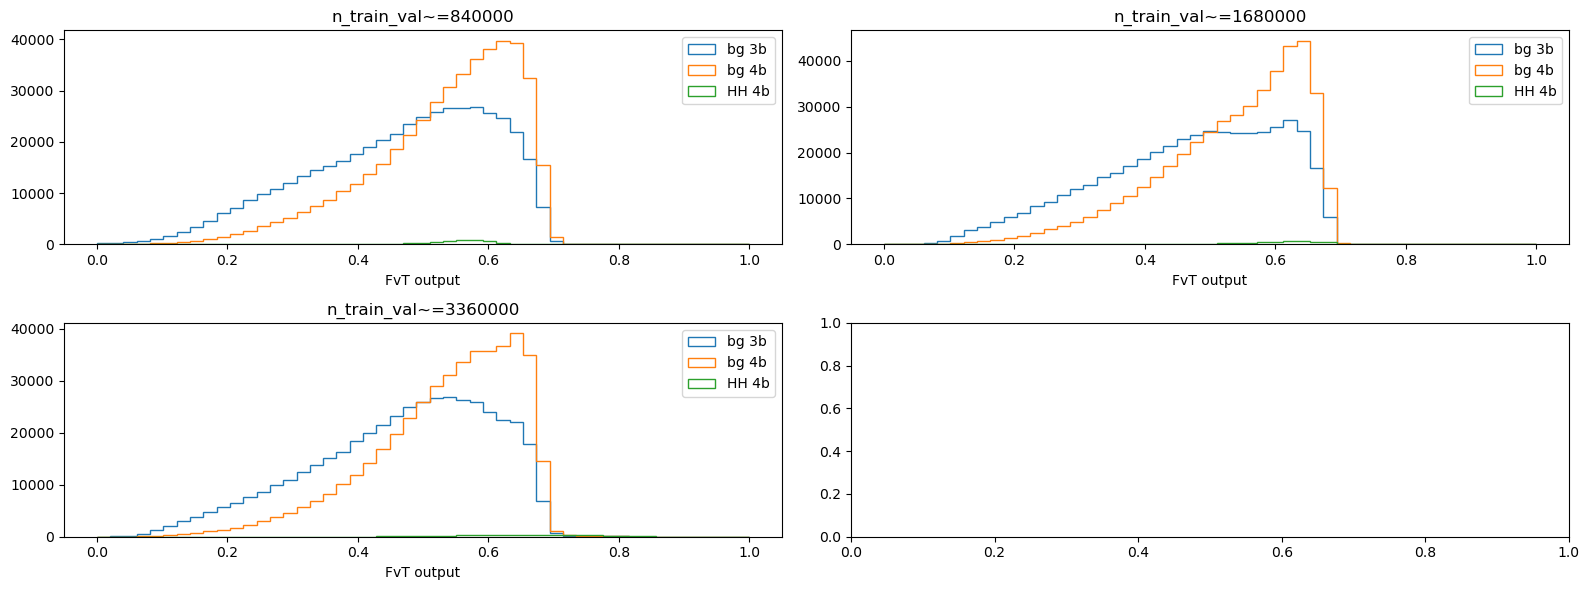

0it [00:00, ?it/s]

successfully loaded {'experiment_name': 'fvt_training_n_samples_1', 'seed': 52, 'n_sample_ratio': 0.25}


1it [00:06,  6.56s/it]

n_sample_ratio=0.25
successfully loaded {'experiment_name': 'fvt_training_n_samples_1', 'seed': 52, 'n_sample_ratio': 0.5}


2it [00:13,  6.51s/it]

n_sample_ratio=0.5
successfully loaded {'experiment_name': 'fvt_training_n_samples_1', 'seed': 52, 'n_sample_ratio': 1.0}


3it [00:19,  6.52s/it]

n_sample_ratio=1.0


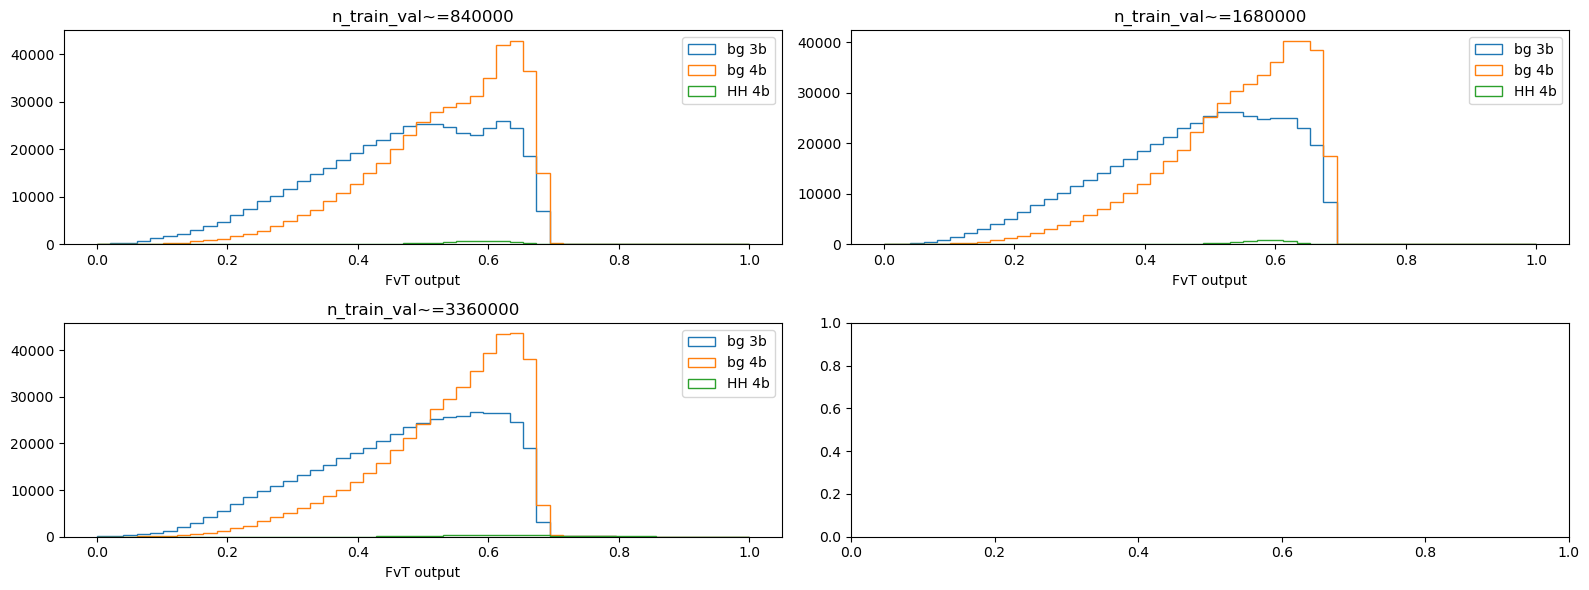

0it [00:00, ?it/s]

successfully loaded {'experiment_name': 'fvt_training_n_samples_1', 'seed': 62, 'n_sample_ratio': 0.25}


1it [00:06,  6.54s/it]

n_sample_ratio=0.25
successfully loaded {'experiment_name': 'fvt_training_n_samples_1', 'seed': 62, 'n_sample_ratio': 0.5}


2it [00:12,  6.47s/it]

n_sample_ratio=0.5
successfully loaded {'experiment_name': 'fvt_training_n_samples_1', 'seed': 62, 'n_sample_ratio': 1.0}


3it [00:19,  6.52s/it]

n_sample_ratio=1.0


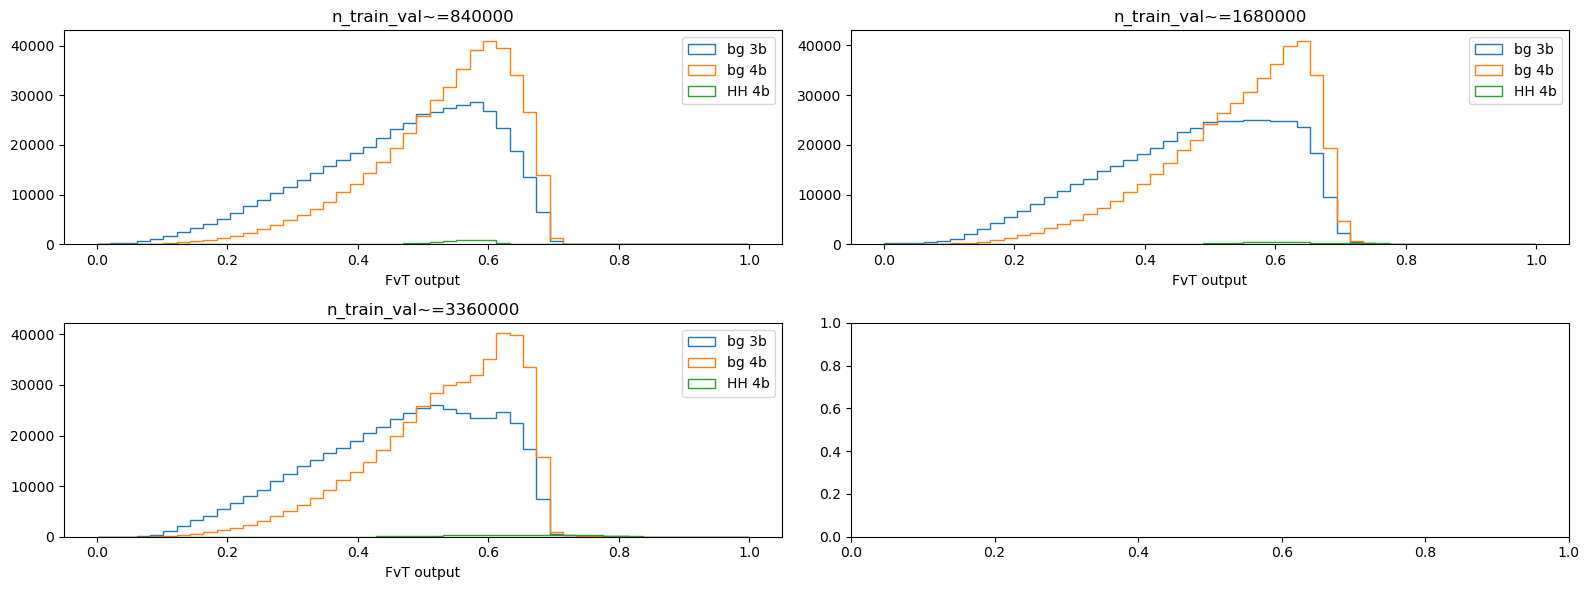

0it [00:00, ?it/s]

successfully loaded {'experiment_name': 'fvt_training_n_samples_1', 'seed': 72, 'n_sample_ratio': 0.25}


1it [00:06,  6.54s/it]

n_sample_ratio=0.25
successfully loaded {'experiment_name': 'fvt_training_n_samples_1', 'seed': 72, 'n_sample_ratio': 0.5}


2it [00:12,  6.45s/it]

n_sample_ratio=0.5
successfully loaded {'experiment_name': 'fvt_training_n_samples_1', 'seed': 72, 'n_sample_ratio': 1.0}


3it [00:19,  6.50s/it]

n_sample_ratio=1.0


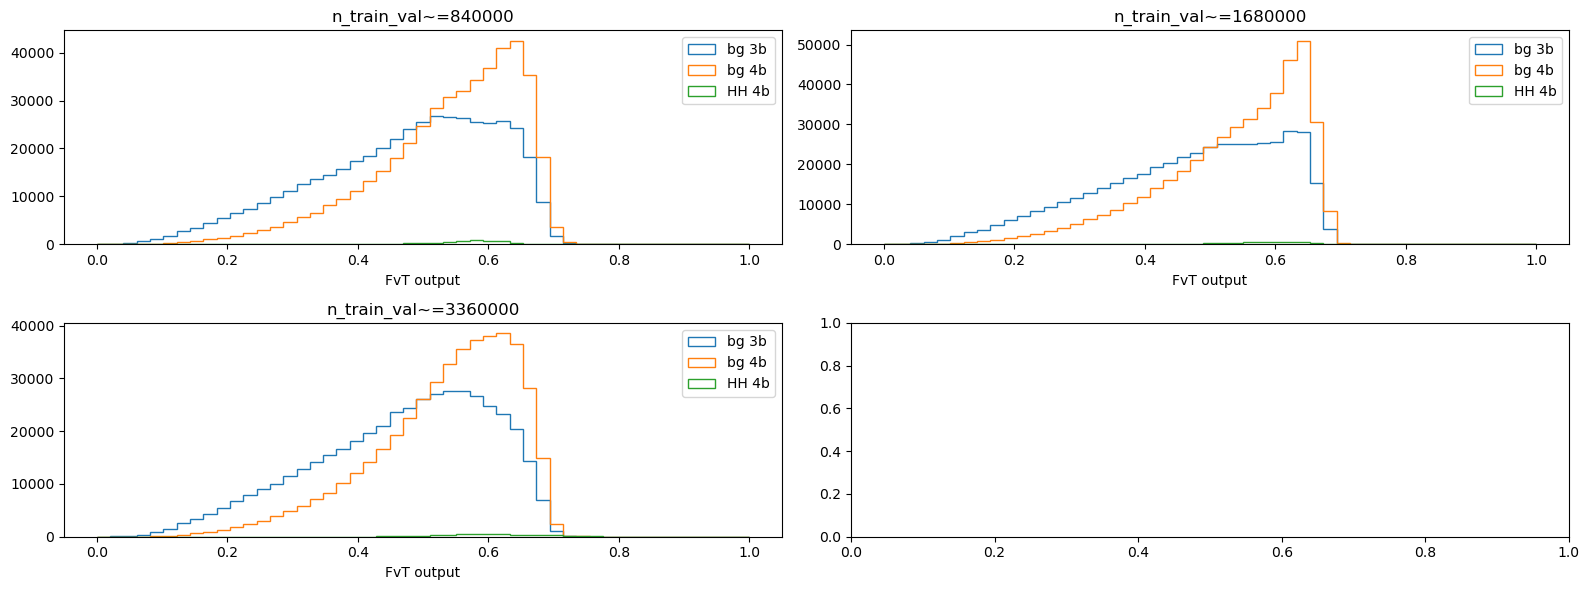

0it [00:00, ?it/s]

successfully loaded {'experiment_name': 'fvt_training_n_samples_1', 'seed': 82, 'n_sample_ratio': 0.25}


1it [00:06,  6.61s/it]

n_sample_ratio=0.25
successfully loaded {'experiment_name': 'fvt_training_n_samples_1', 'seed': 82, 'n_sample_ratio': 0.5}


2it [00:12,  6.46s/it]

n_sample_ratio=0.5
successfully loaded {'experiment_name': 'fvt_training_n_samples_1', 'seed': 82, 'n_sample_ratio': 1.0}


3it [00:19,  6.53s/it]

n_sample_ratio=1.0


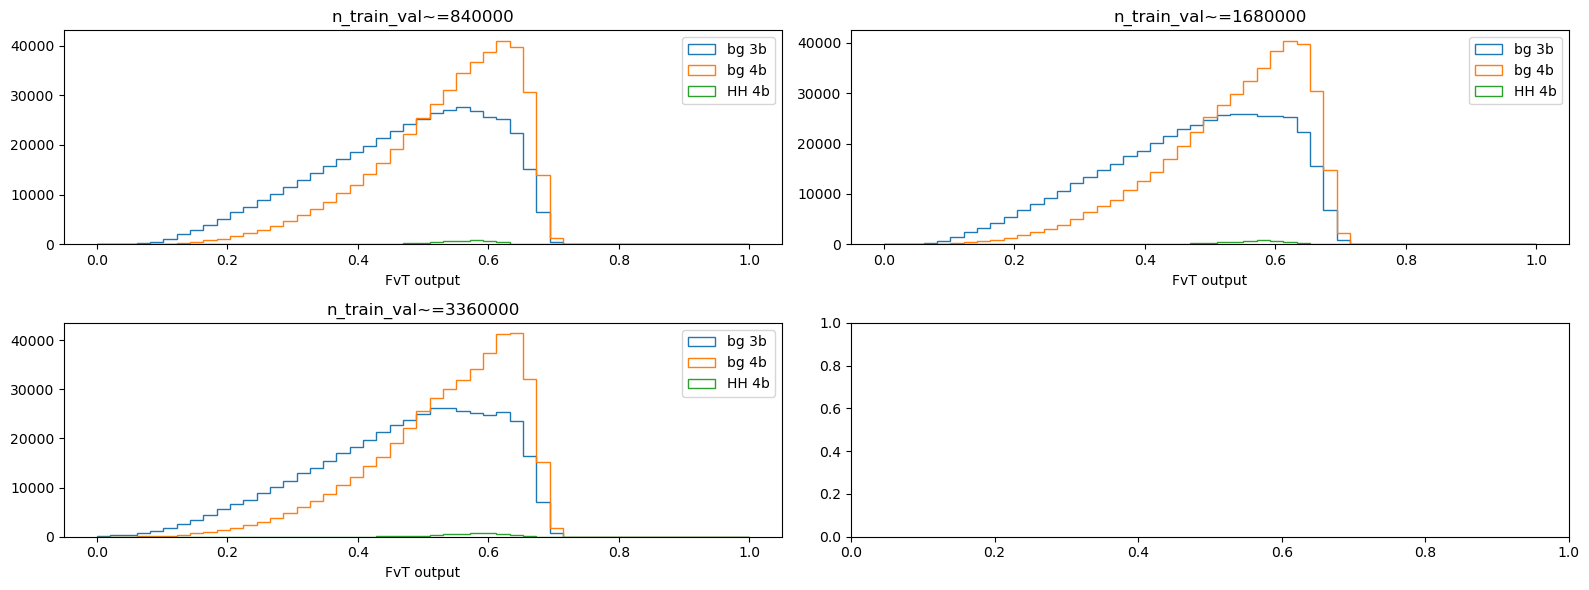

0it [00:00, ?it/s]

successfully loaded {'experiment_name': 'fvt_training_n_samples_1', 'seed': 92, 'n_sample_ratio': 0.25}


1it [00:06,  6.56s/it]

n_sample_ratio=0.25
successfully loaded {'experiment_name': 'fvt_training_n_samples_1', 'seed': 92, 'n_sample_ratio': 0.5}


2it [00:12,  6.43s/it]

n_sample_ratio=0.5
successfully loaded {'experiment_name': 'fvt_training_n_samples_1', 'seed': 92, 'n_sample_ratio': 1.0}


3it [00:19,  6.52s/it]

n_sample_ratio=1.0


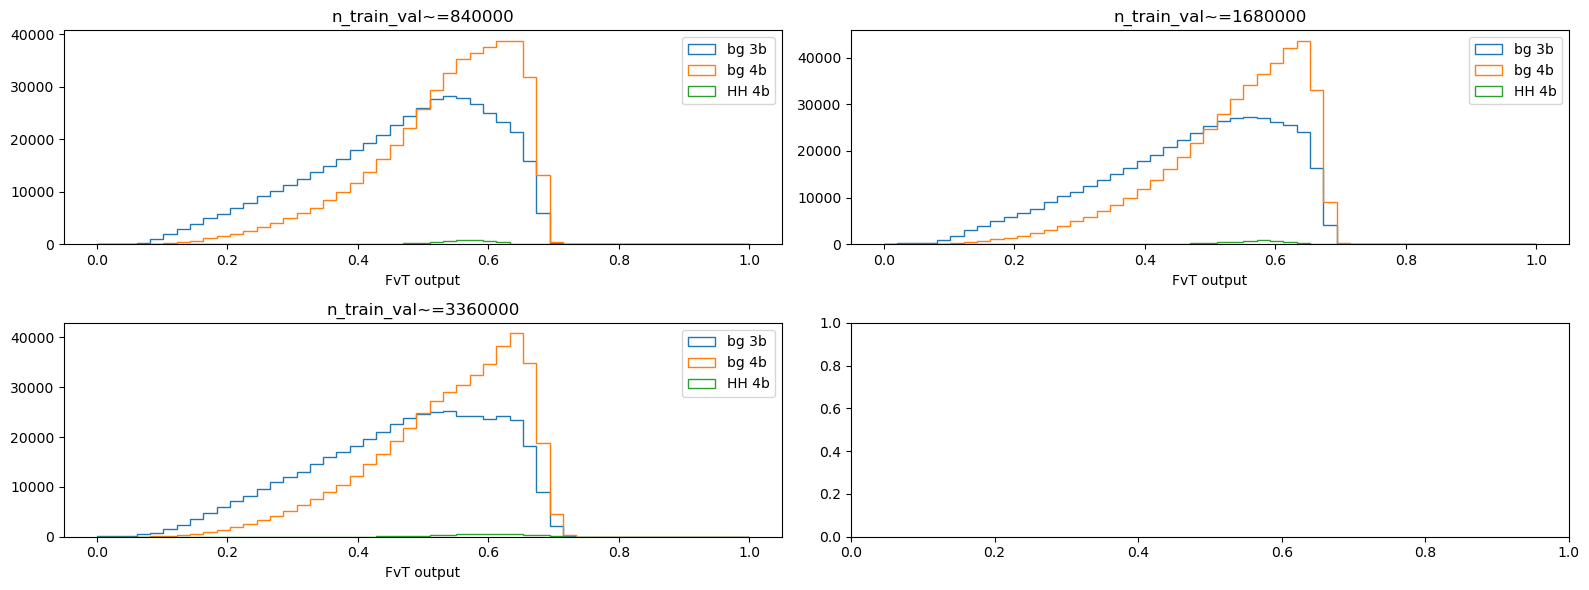

In [7]:
import torch
from dataset import generate_tt_dataset
from training_info import TrainingInfo
import pytorch_lightning as pl
import yaml
from fvt_classifier import FvTClassifier
from code_fragments import att_q_repr_hist, fvt_score_hist
from events_data import EventsData
import tqdm
import numpy as np
import matplotlib.pyplot as plt

config_filename = "configs/fvt_training_n_samples_1.yml"


config = yaml.safe_load(open(config_filename, "r"))
experiment_name = config["experiment_name"]
n_3b = config["n_3b"]
n_all4b = config["n_all4b"]
signal_ratio = config["signal_ratio"]
test_ratio = config["test_ratio"]
# n_sample_ratios = config["n_sample_ratios"]
n_sample_ratios = [0.25, 0.5, 1.0]
seeds = [42, 52, 62, 72, 82, 92]
w_cuts = np.arange(0.01, 1.01, 0.01)

fvt_scores_dict = {seed: {} for seed in seeds}
att_q_reprs_dict = {seed: {} for seed in seeds}
events_test_dict = {}
is_in_regions_list_dict = {seed: {} for seed in seeds}
embeddings_dict = {seed: {} for seed in seeds}

for seed in seeds:
    _, dinfo_test = generate_tt_dataset(
            seed,
            n_3b,
            n_all4b,
            signal_ratio,
            test_ratio,
        )
    events_test = EventsData.from_dataframe(dinfo_test.fetch_data(), features)
    events_test_dict[seed] = events_test

    nrows = 2
    ncols = int(np.ceil(len(n_sample_ratios) / 2))
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(16, 6))

    for ax_cnt, n_sample_ratio in tqdm.tqdm(enumerate(n_sample_ratios)):
        hparam_filter = {"experiment_name": experiment_name, 
                         "seed": seed, 
                         "n_sample_ratio": n_sample_ratio}
        hashes = TrainingInfo.find(hparam_filter)
        assert len(hashes) == 1
        print("successfully loaded", hparam_filter)
        hash = hashes[0]
        tinfo = TrainingInfo.load(hash)

        current_ax = ax[ax_cnt // ncols, ax_cnt % ncols] if ncols > 1 else ax[ax_cnt]
        current_ax.set_title(f"n_train_val~={1000 * ((len(tinfo.dinfo_train) + len(tinfo.dinfo_val)) // 1000)}")
        fvt_model = FvTClassifier.load_from_checkpoint(f"./checkpoints/{hash}_best.ckpt")
        fvt_model.eval()
        device = torch.device("cuda:0")
        fvt_model = fvt_model.to(device)
        events_test.set_model_scores(fvt_model)
        fvt_score_hist(events_test, current_ax)
        
        print(f"n_sample_ratio={n_sample_ratio}")
        # att_q_repr_hist(events_test, title=f"n_sample_ratio={n_sample_ratio}")

        fvt_scores_dict[seed][n_sample_ratio] = events_test.fvt_score
        att_q_reprs_dict[seed][n_sample_ratio] = events_test.att_q_repr

    fig.tight_layout()
    fig.show()

    plt.show()
    plt.close()

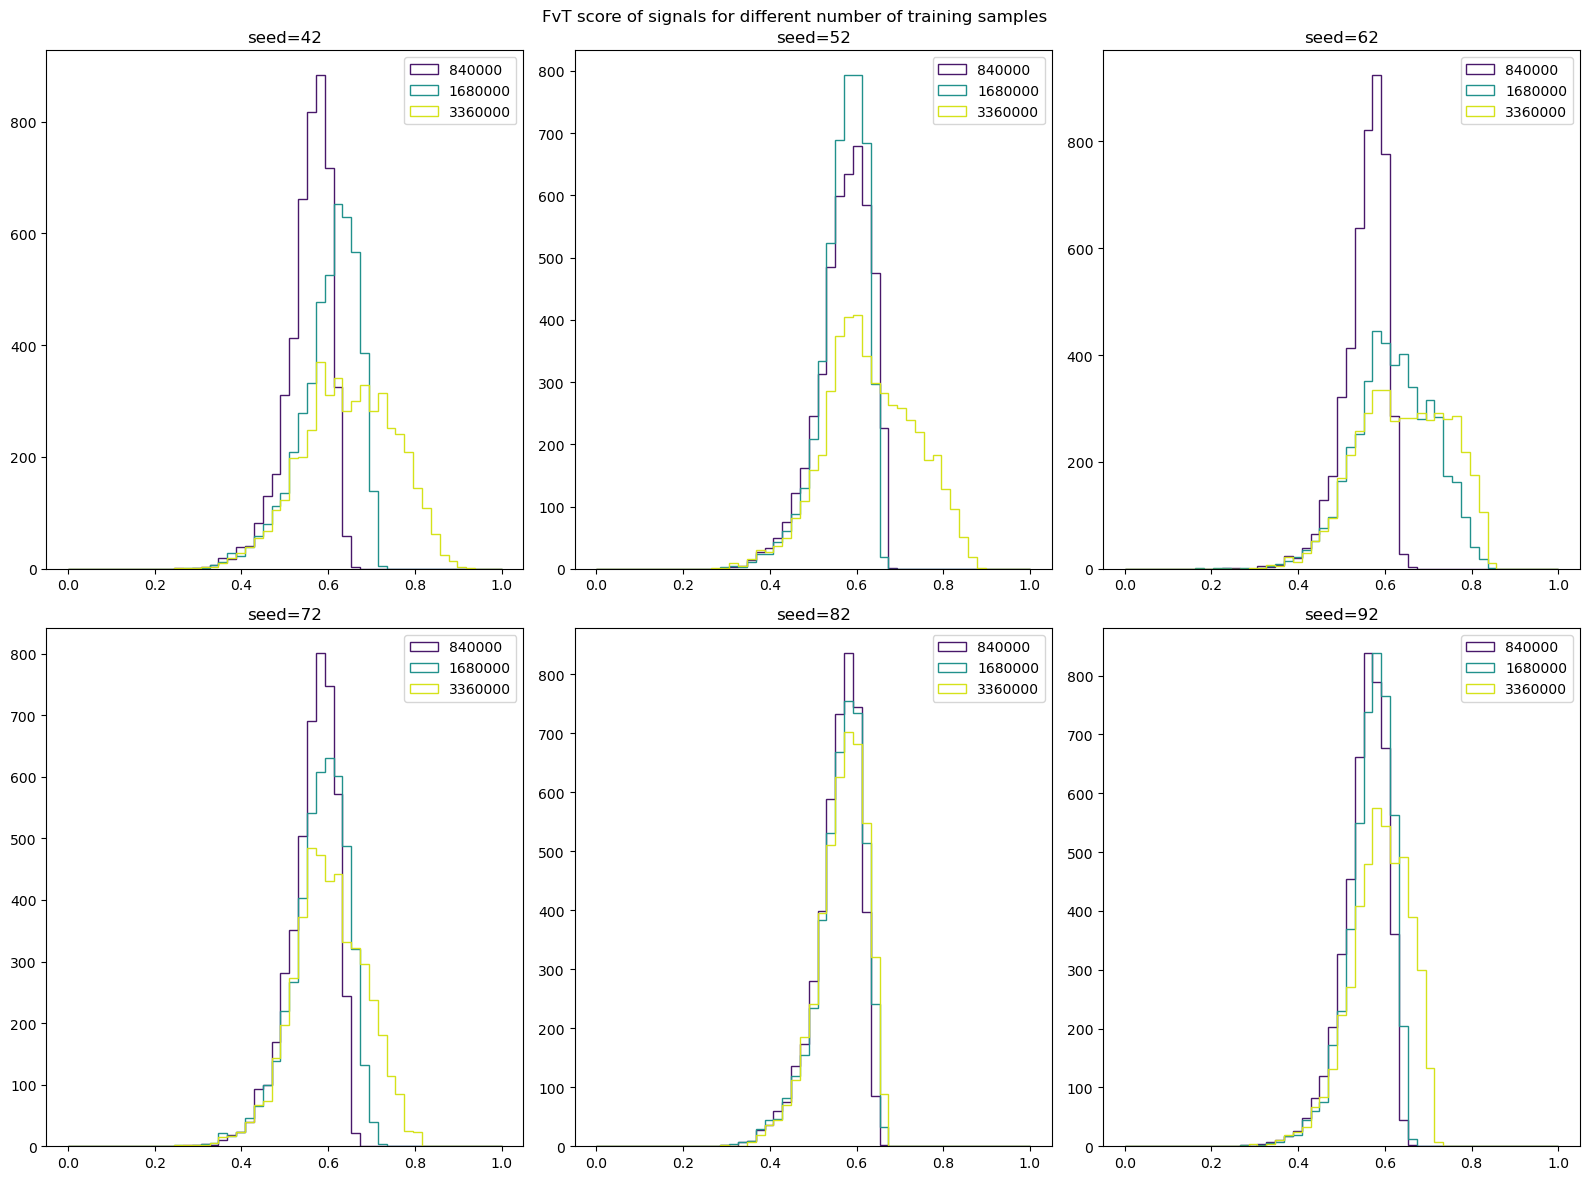

In [8]:
import matplotlib as mpl
cmap = mpl.colormaps["viridis"]

nrows, ncols = 2, 3

bins_range = np.linspace(0, 1, 50)
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(16, 12))
fig.suptitle("FvT score of signals for different number of training samples")
for ax_cnt, seed in enumerate(seeds):
    events = events_test_dict[seed]
    current_ax = ax[ax_cnt // ncols, ax_cnt % ncols]
    current_ax.set_title(f"seed={seed}")
    cmin = np.log(min(n_sample_ratios))
    cmax = np.log(max(n_sample_ratios))
    margin = 0.1
    color = lambda x: cmap((np.log(x) - cmin + margin) / (cmax - cmin + 2 * margin))
    for n_sample_ratio in n_sample_ratios:
        current_ax.hist(fvt_scores_dict[seed][n_sample_ratio][events.is_signal], bins=bins_range, 
                label=int(n_sample_ratio * 3360000), histtype="step", 
                weights=events.weights[events.is_signal], 
                color=color(n_sample_ratio))
    current_ax.legend()
        
plt.tight_layout()
plt.show()
plt.close()

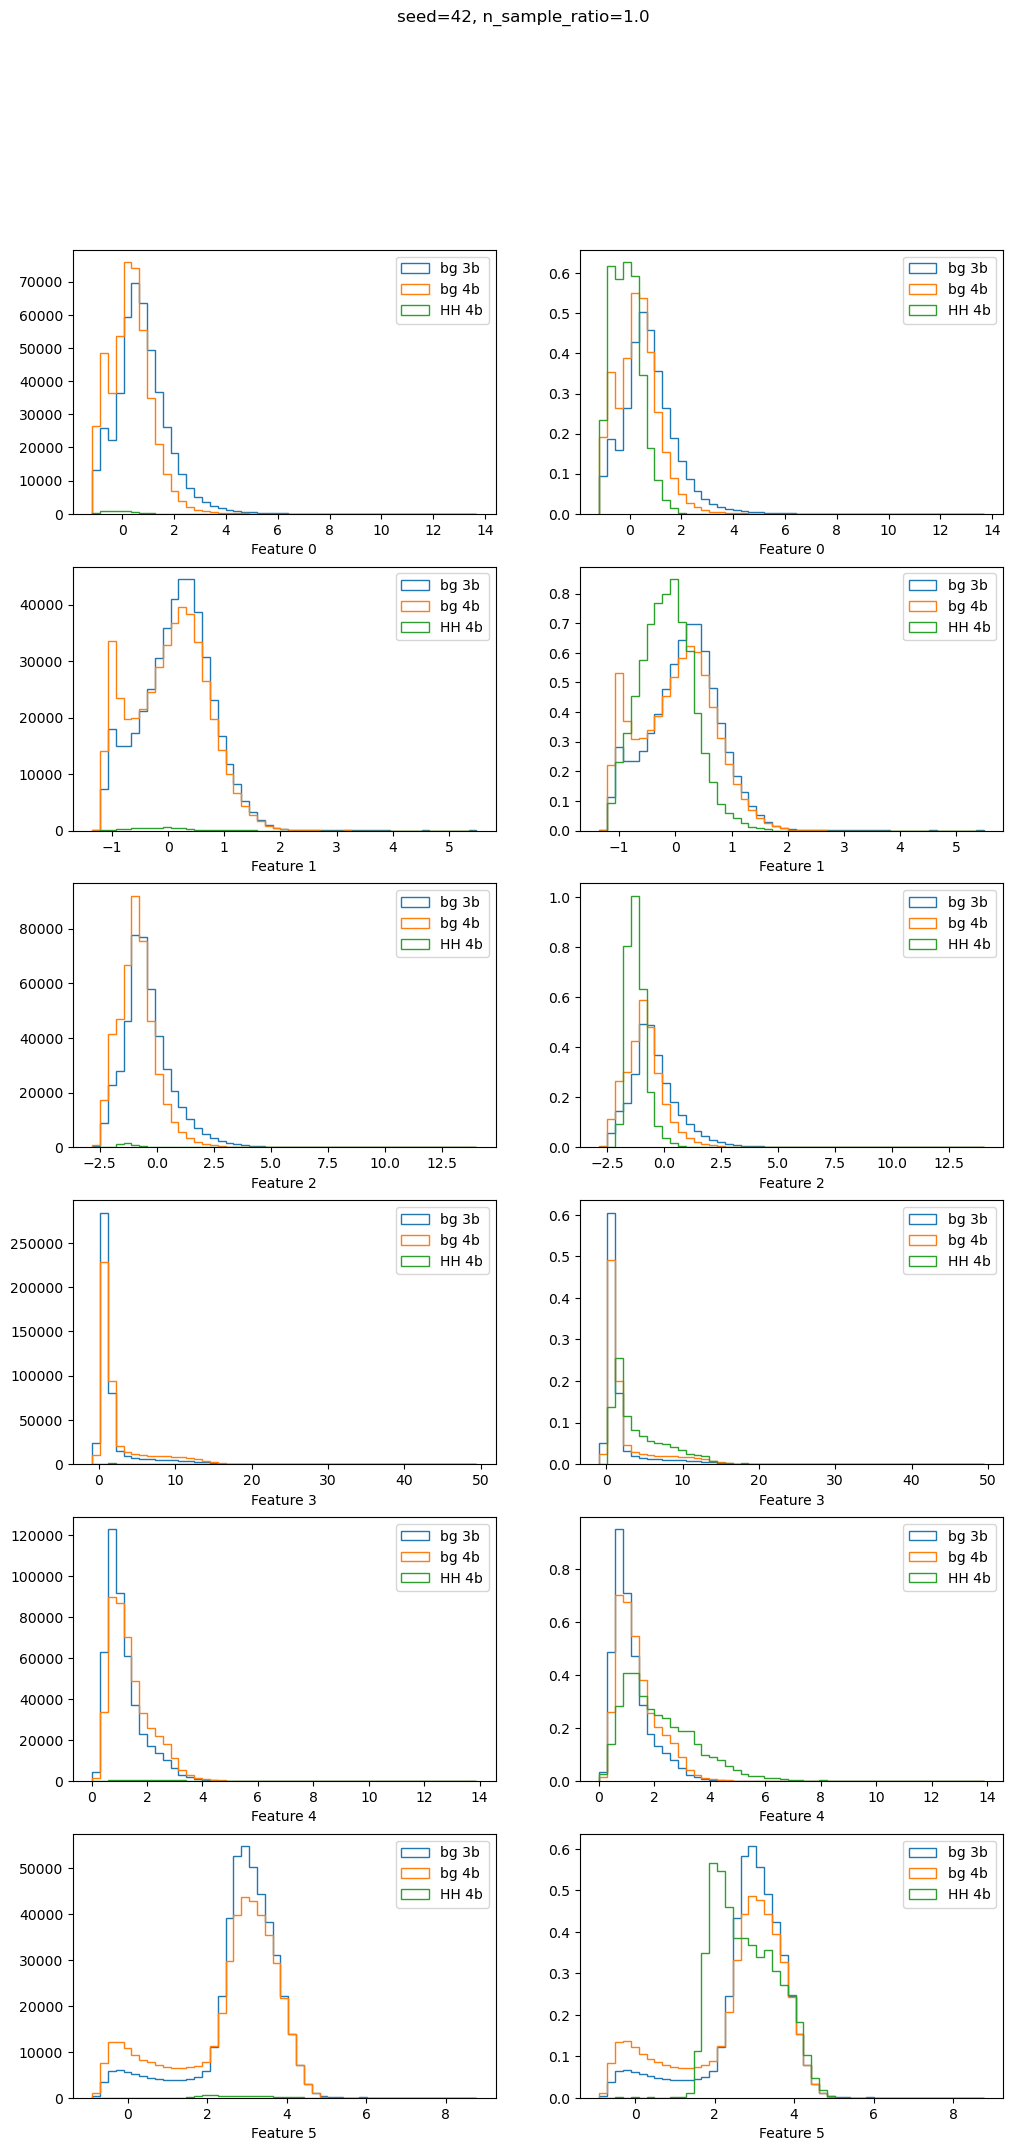

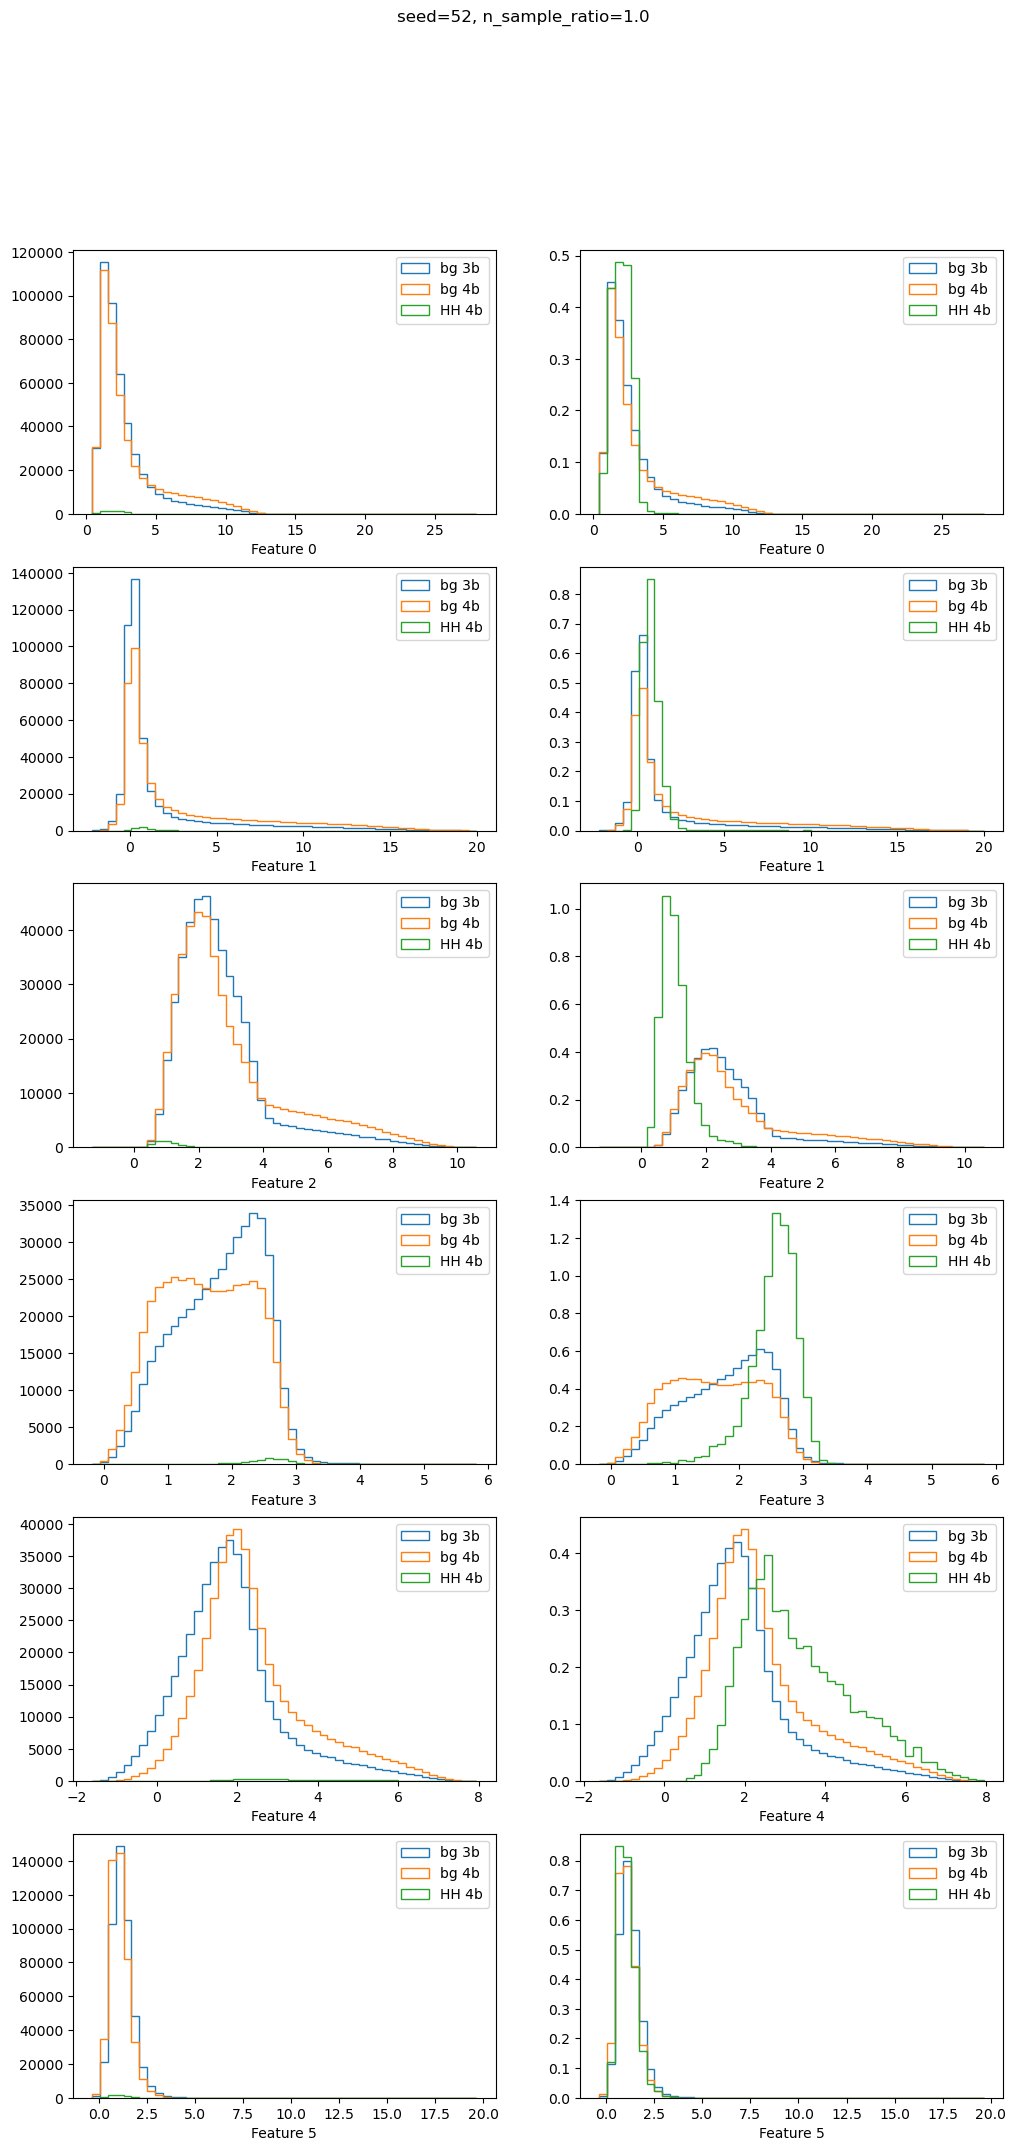

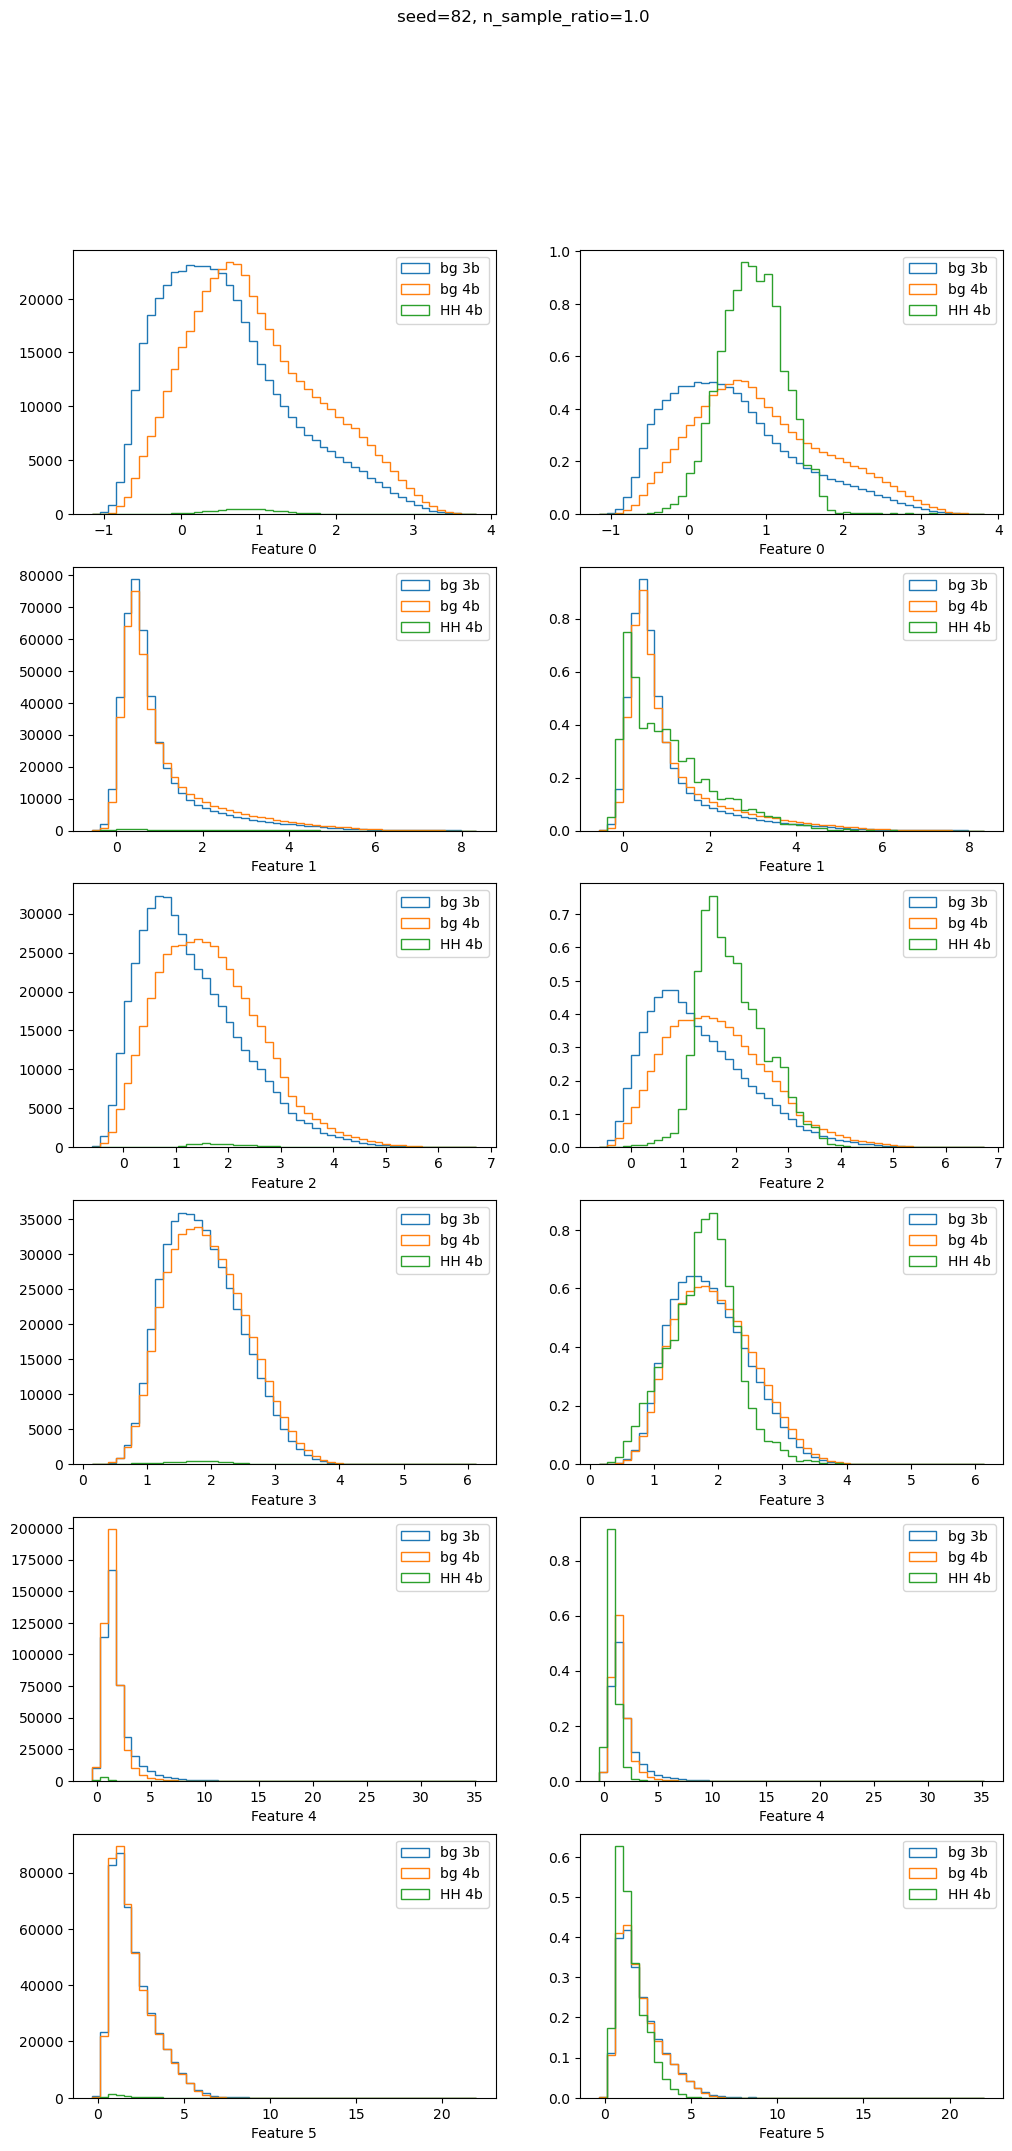

In [61]:
for seed in [42, 52, 82]:
    for n_sample_ratio in [1.0]:
        att_q_repr = att_q_reprs_dict[seed][n_sample_ratio]
        is_3b = events_test_dict[seed].is_3b
        is_bg4b = events_test_dict[seed].is_bg4b
        is_signal = events_test_dict[seed].is_signal
        w = events_test_dict[seed].weights

        fig, ax = plt.subplots(nrows=att_q_repr.shape[1], ncols=2, figsize=(12, 24))
        fig.suptitle(f"seed={seed}, n_sample_ratio={n_sample_ratio}")
        for i in range(att_q_repr.shape[1]):
            bins_range = np.linspace(np.min(att_q_repr[:, i]), np.max(att_q_repr[:, i]), 50)
            ax[i, 0].hist(
                att_q_repr[is_3b, i],
                bins=bins_range,
                label="bg 3b",
                linewidth=1,
                histtype="step",
                density=False,
                weights=w[is_3b],
            )
            ax[i, 0].hist(
                att_q_repr[is_bg4b, i],
                bins=bins_range,
                label="bg 4b",
                linewidth=1,
                histtype="step",
                density=False,
                weights=w[is_bg4b],
            )
            ax[i, 0].hist(
                att_q_repr[is_signal, i],
                bins=bins_range,
                label="HH 4b",
                linewidth=1,
                histtype="step",
                density=False,
                weights=w[is_signal],
            )
            ax[i, 0].legend()
            ax[i, 0].set_xlabel(f"Feature {i}")

            ax[i, 1].hist(
                att_q_repr[is_3b, i],
                bins=bins_range,
                label="bg 3b",
                linewidth=1,
                histtype="step",
                density=True,
                weights=w[is_3b],
            )
            ax[i, 1].hist(
                att_q_repr[is_bg4b, i],
                bins=bins_range,
                label="bg 4b",
                linewidth=1,
                histtype="step",
                density=True,
                weights=w[is_bg4b],
            )
            ax[i, 1].hist(
                att_q_repr[is_signal, i],
                bins=bins_range,
                label="HH 4b",
                linewidth=1,
                histtype="step",
                density=True,
                weights=w[is_signal],
            )
            ax[i, 1].legend()
            ax[i, 1].set_xlabel(f"Feature {i}")

        plt.show()

In [37]:
# import time
# from signal_region import get_regions_via_histogram, get_regions_via_probs_4b
# from xgboost import XGBRegressor
# from sklearn.ensemble import RandomForestRegressor

# n_sample_ratio = 1.0
# using_features = [0, 1, 2, 3, 4, 5]
# w_cuts = np.arange(0.01, 1.01, 0.01)

# for seed in [42, 52, 82]:
#     events = events_test_dict[seed]
#     is_3b = events.is_3b
#     is_bg4b = events.is_bg4b
#     is_signal = events.is_signal
#     is_4b = events.is_4b
#     w = events.weights

#     fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
#     fig.suptitle(f"seed={seed}, n_sample_ratio={n_sample_ratio}")

#     att_q_repr = att_q_reprs_dict[seed][n_sample_ratio]

#     for method in ["xgbreg", "hist", "fvt"]:
#         start_time = time.time()
#         if method == "xgbreg":
#             xgbreg = XGBRegressor(n_estimators=32, max_depth=16, random_state=seed, objective="binary:logistic")
#             xgbreg.fit(att_q_repr, is_4b, sample_weight=w)
#             probs_4b_estimated = xgbreg.predict(att_q_repr)
#             is_in_regions_list = get_regions_via_probs_4b(events, w_cuts, probs_4b_estimated)
#             calibration_plot(probs_4b_estimated, is_4b, bins=20, sample_weights=w, title="XGBoost")
#         elif method == "rfreg":
#             rfreg = RandomForestRegressor(n_estimators=10, max_depth=5, random_state=seed)
#             rfreg.fit(att_q_repr, is_4b, sample_weight=w)
#             probs_4b_estimated = rfreg.predict(att_q_repr)
#             is_in_regions_list = get_regions_via_probs_4b(events, w_cuts, probs_4b_estimated)
#             calibration_plot(probs_4b_estimated, is_4b, bins=20, sample_weights=w, title="RandomForest")
#         elif method == "hist":
#             is_in_regions_list = get_regions_via_histogram(events, w_cuts, n_bins=8)
#         elif method == "fvt":
#             is_in_regions_list = get_regions_via_probs_4b(events, w_cuts, events.fvt_score)
#             calibration_plot(events.fvt_score, is_4b, bins=20, sample_weights=w, title="FvT NN")
#         else:
#             raise ValueError(f"Unknown method: {method}")

#         print(f"Elapsed time: {time.time() - start_time:.2f} s")

#         w_signal = np.array([np.sum(w[is_signal & is_in_regions]) for is_in_regions in is_in_regions_list]) / np.sum(w[is_signal])
#         w_all = np.array([np.sum(w[is_in_regions]) for is_in_regions in is_in_regions_list]) / np.sum(w)
#         w_4b = np.array([np.sum(w[is_4b & is_in_regions]) for is_in_regions in is_in_regions_list]) / np.sum(w[is_4b])

#         ax[0].plot( 
#             w_4b,
#             w_signal,
#             label=method,
#             marker="x",
#             markersize=4
#         )
#         ax[1].plot(
#             w_all,
#             w_signal,
#             label=method,
#             marker="x",
#             markersize=4
#         )

#     ax[0].plot([0, 1], [0, 1], linestyle="--", color="black")
#     ax[0].set_xlabel("4b")
#     ax[0].set_ylabel("Signal efficiency")
#     ax[0].legend()

#     ax[1].plot([0, 1], [0, 1], linestyle="--", color="black")
#     ax[1].set_xlabel("w_cut")
#     ax[1].set_ylabel("% all samples")
#     ax[1].legend()

#     plt.show()
#     plt.close()


Elapsed time: 0.10 s
Elapsed time: 38.66 s
Elapsed time: 3.51 s
Elapsed time: 0.80 s
Elapsed time: 0.79 s


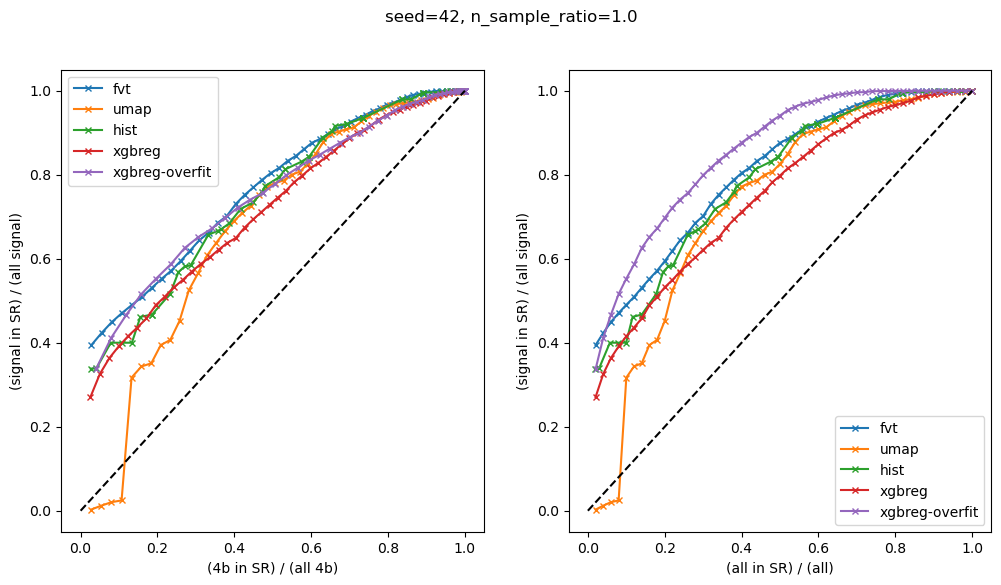

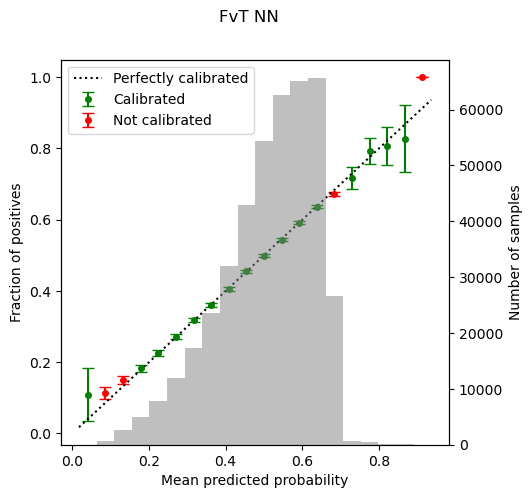

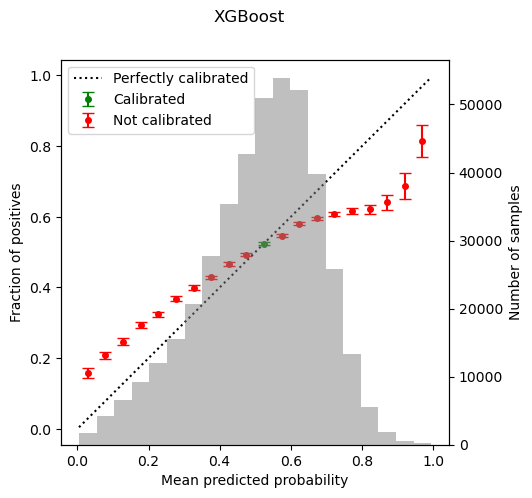

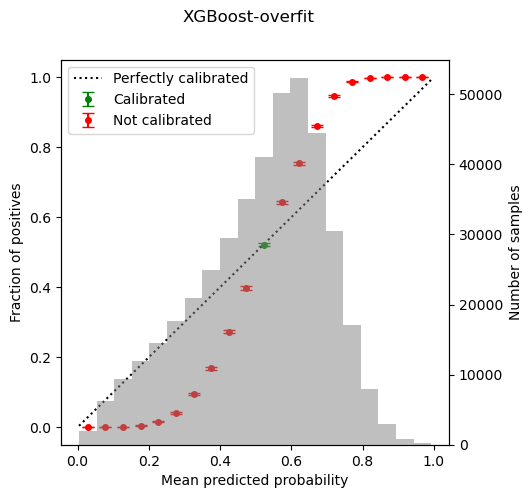

Elapsed time: 0.10 s
Elapsed time: 39.49 s
Elapsed time: 4.47 s
Elapsed time: 0.88 s
Elapsed time: 1.06 s


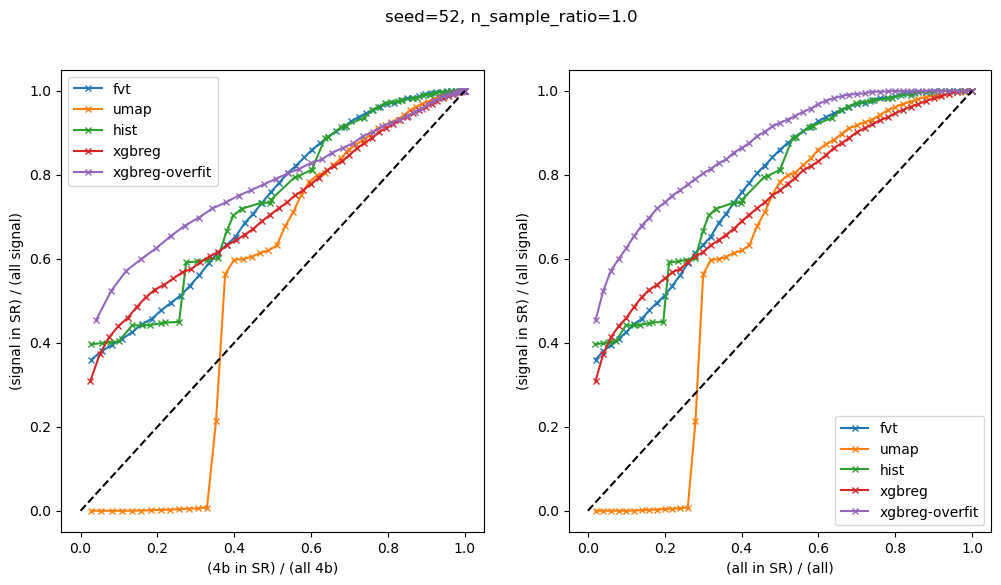

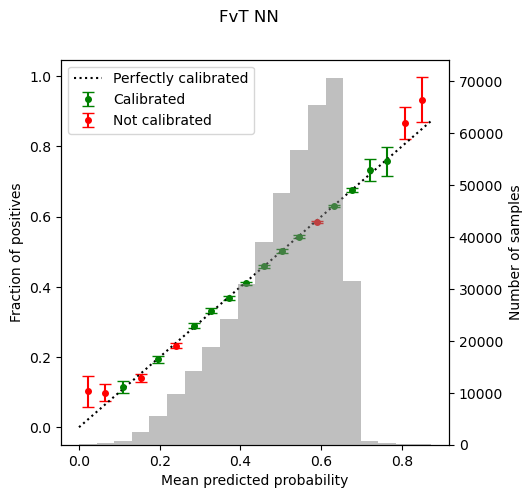

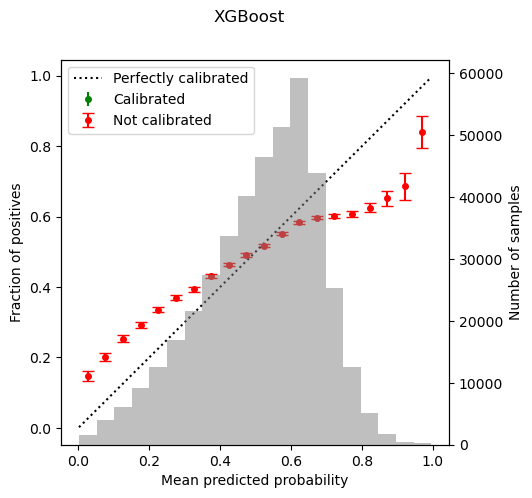

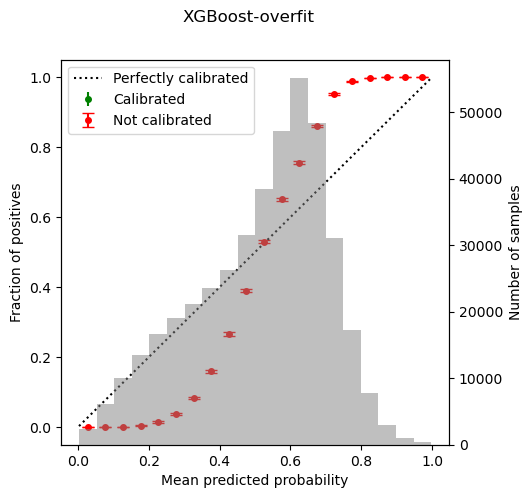

Elapsed time: 0.10 s
Elapsed time: 39.85 s
Elapsed time: 10.80 s
Elapsed time: 0.86 s
Elapsed time: 0.85 s


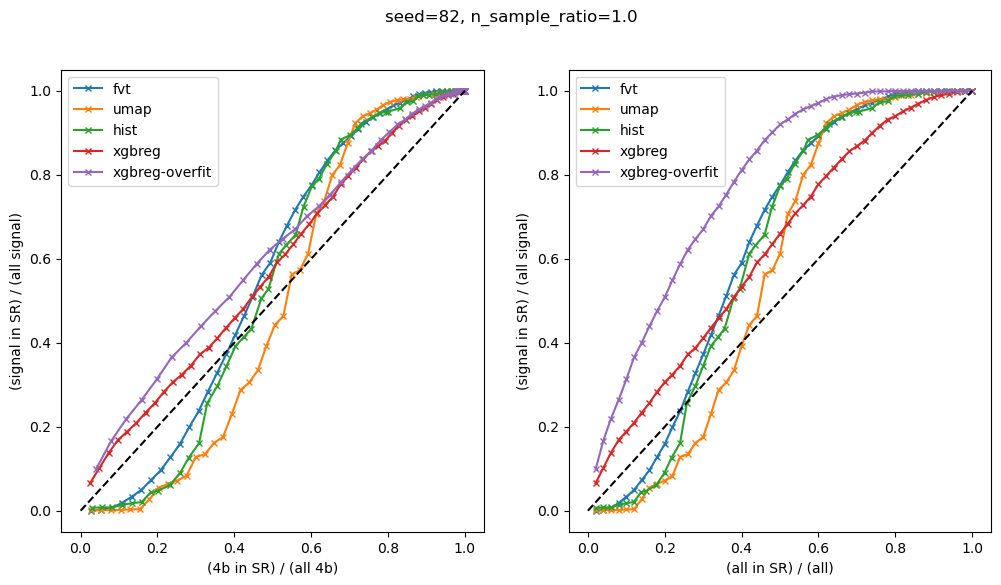

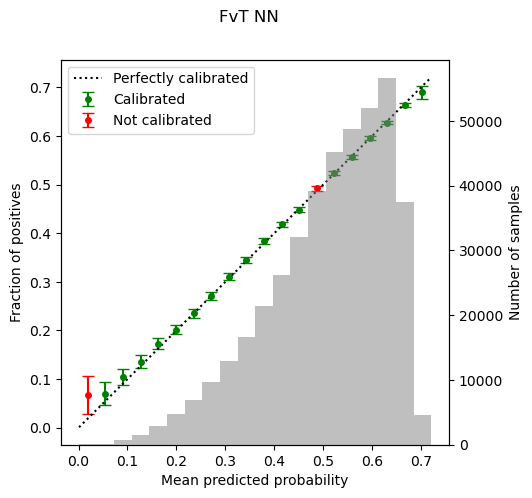

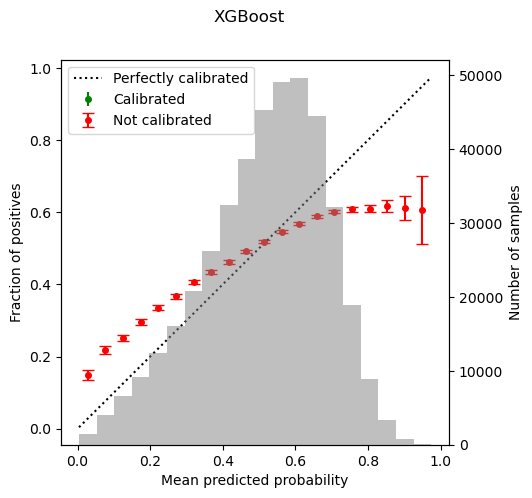

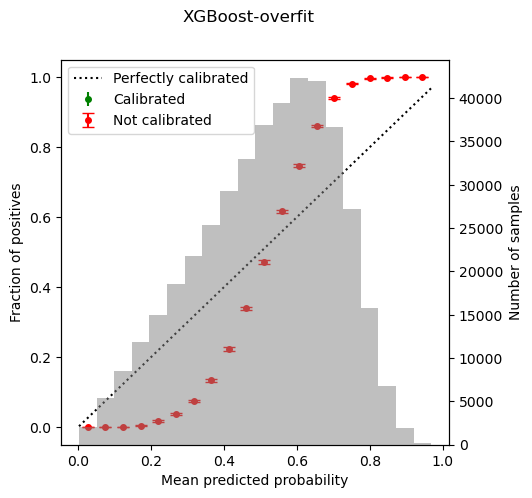

In [41]:
import time
from plots import calibration_plot
from signal_region import get_regions_via_histogram, get_regions_via_probs_4b, get_fvt_cut_regions
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor

n_sample_ratio = 1.0
using_features = [0, 1, 2, 3, 4, 5]
w_cuts = np.arange(0.02, 1.02, 0.02)

for seed in [42, 52, 82]:
    events = events_test_dict[seed]

    events_sr_train, events_sr_test = events.split(0.5, seed=seed)
    hash = TrainingInfo.find({"experiment_name": experiment_name, "seed": seed,
                                "signal_ratio": 0.01, "n_sample_ratio": 1.0})[0]
    fvt_model = FvTClassifier.load_from_checkpoint(f"./checkpoints/{hash}_best.ckpt")
    fvt_model.eval()
    device = torch.device("cuda:0")
    fvt_model = fvt_model.to(device)
    events_sr_train.set_model_scores(fvt_model)
    events_sr_test.set_model_scores(fvt_model)

    is_3b = events_sr_test.is_3b
    is_bg4b = events_sr_test.is_bg4b
    is_signal = events_sr_test.is_signal
    is_4b = events_sr_test.is_4b
    w = events_sr_test.weights

    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
    fig.suptitle(f"seed={seed}, n_sample_ratio={n_sample_ratio}")

    att_q_repr = att_q_reprs_dict[seed][n_sample_ratio]

    for method in ["fvt", "umap", "hist", "xgbreg", "xgbreg-overfit"]:
        start_time = time.time()
        if method == "xgbreg":
            xgbreg = XGBRegressor(n_estimators=32, max_depth=16, random_state=seed, objective="binary:logistic")
            xgbreg.fit(events_sr_train.att_q_repr, events_sr_train.is_4b, sample_weight=events_sr_train.weights)
            probs_4b_estimated = xgbreg.predict(events_sr_test.att_q_repr)
            is_in_regions_list = get_regions_via_probs_4b(events_sr_test, w_cuts, probs_4b_estimated)
            calibration_plot(probs_4b_estimated, events_sr_test.is_4b, bins=20, 
                            sample_weights=events_sr_test.weights, title="XGBoost")
        elif method == "xgbreg-overfit":
            xgbreg = XGBRegressor(n_estimators=32, max_depth=16, random_state=seed, objective="binary:logistic")
            xgbreg.fit(events_sr_test.att_q_repr, events_sr_test.is_4b, sample_weight=events_sr_test.weights)
            probs_4b_estimated = xgbreg.predict(events_sr_test.att_q_repr)
            is_in_regions_list = get_regions_via_probs_4b(events_sr_test, w_cuts, probs_4b_estimated)
            calibration_plot(probs_4b_estimated, events_sr_test.is_4b, bins=20, 
                            sample_weights=events_sr_test.weights, title="XGBoost-overfit")
        elif method == "rfreg":
            rfreg = RandomForestRegressor(n_estimators=10, max_depth=5, random_state=seed)
            rfreg.fit(events_sr_train.att_q_repr, events_sr_train.is_4b, sample_weight=events_sr_train.weights)
            probs_4b_estimated = rfreg.predict(events_sr_test.att_q_repr)
            is_in_regions_list = get_regions_via_probs_4b(events_sr_test, w_cuts, probs_4b_estimated)
            calibration_plot(probs_4b_estimated, events_sr_test.is_4b, bins=20, 
                            sample_weights=events_sr_test.weights, title="RandomForest")
        elif method == "hist":
            is_in_regions_list = get_regions_via_histogram(events_sr_test, w_cuts, n_bins=10)
        elif method == "fvt":
            is_in_regions_list = get_regions_via_probs_4b(events_sr_test, w_cuts, events_sr_test.fvt_score)
            calibration_plot(events_sr_test.fvt_score, events_sr_test.is_4b, bins=20, 
                            sample_weights=events_sr_test.weights, title="FvT NN")
        elif method == "umap":
            is_in_regions_list = get_fvt_cut_regions(events_sr_test, 0.0, w_cuts, seed=seed)
        else:
            raise ValueError(f"Unknown method: {method}")

        print(f"Elapsed time: {time.time() - start_time:.2f} s")


        w_signal = np.array([np.sum(w[is_signal & is_in_regions]) for is_in_regions in is_in_regions_list]) / np.sum(w[is_signal])
        w_4b = np.array([np.sum(w[is_4b & is_in_regions]) for is_in_regions in is_in_regions_list]) / np.sum(w[is_4b])
        w_all = np.array([np.sum(w[is_in_regions]) for is_in_regions in is_in_regions_list]) / np.sum(w)

        ax[0].plot( 
            w_4b,
            w_signal,
            label=method,
            marker="x",
            markersize=4
        )
        ax[1].plot(
            w_all,
            w_signal,
            label=method,
            marker="x",
            markersize=4
        )

    ax[0].plot([0, 1], [0, 1], linestyle="--", color="black")
    ax[0].set_xlabel("(4b in SR) / (all 4b)")
    ax[0].set_ylabel("(signal in SR) / (all signal)")
    ax[0].legend()

    ax[1].plot([0, 1], [0, 1], linestyle="--", color="black")
    ax[1].set_xlabel("(all in SR) / (all)")
    ax[1].set_ylabel("(signal in SR) / (all signal)")
    ax[1].legend()

    plt.show()
    plt.close()


Elapsed time: 3.45 s
Elapsed time: 0.86 s
Elapsed time: 0.80 s


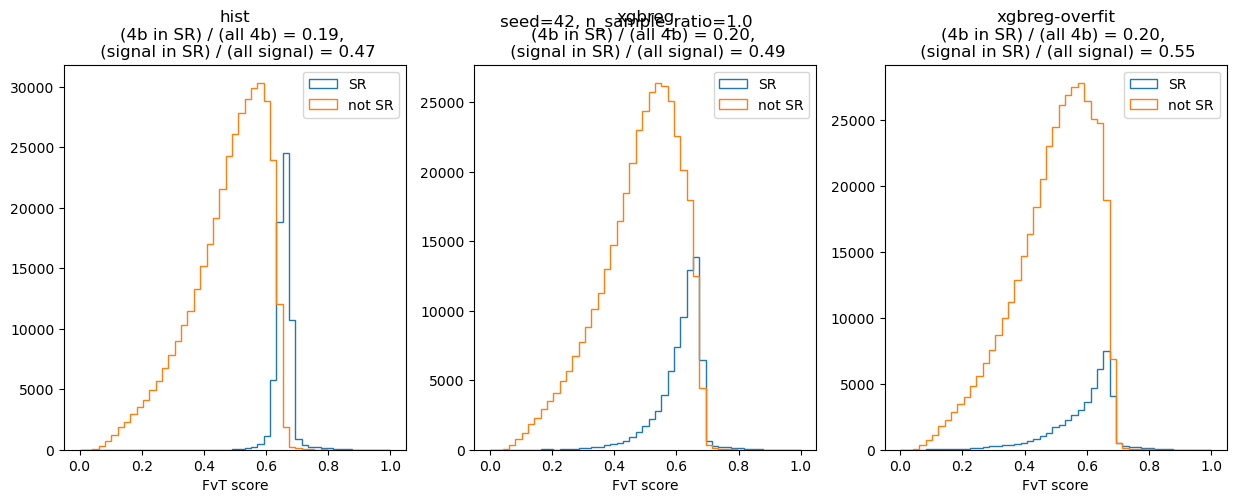

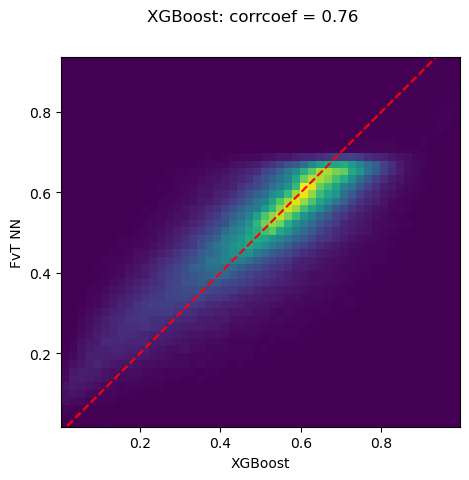

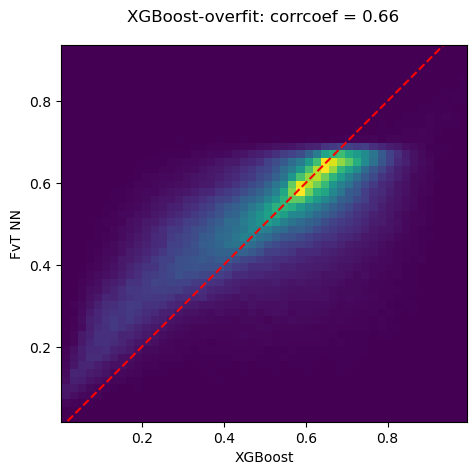

Elapsed time: 4.41 s
Elapsed time: 0.99 s
Elapsed time: 0.80 s


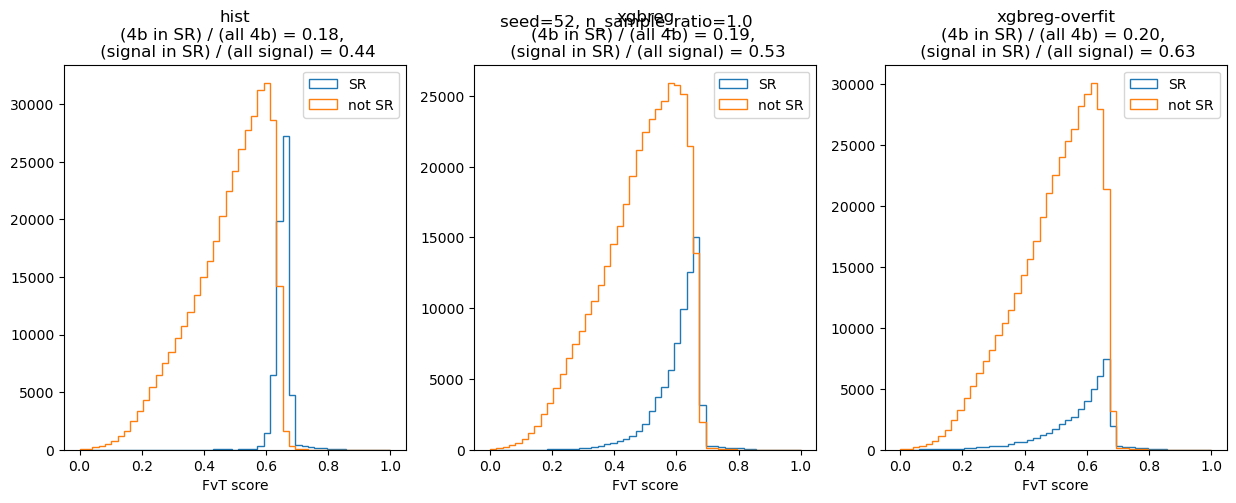

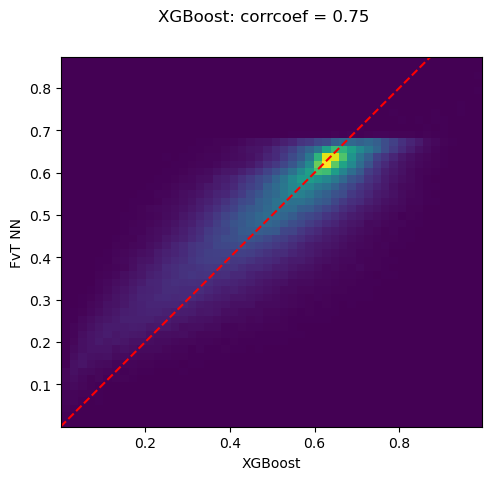

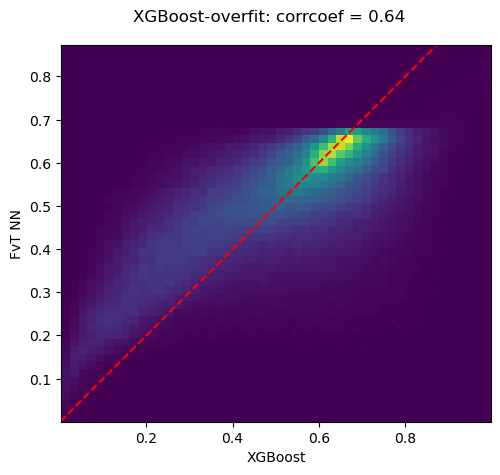

Elapsed time: 10.72 s
Elapsed time: 0.87 s
Elapsed time: 0.83 s


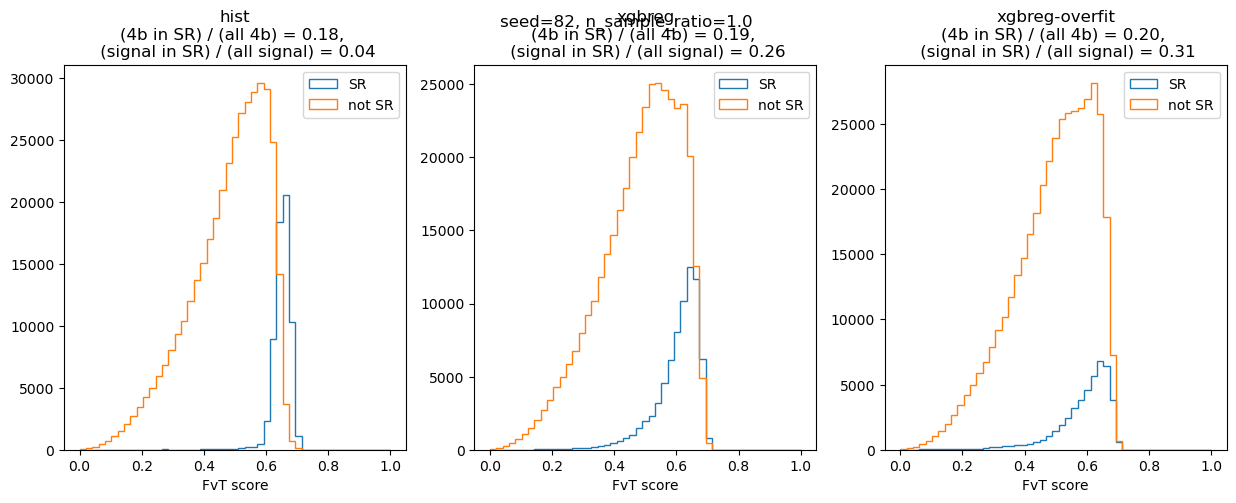

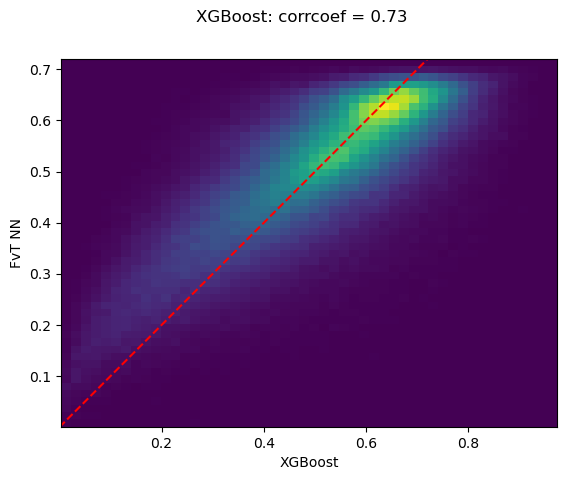

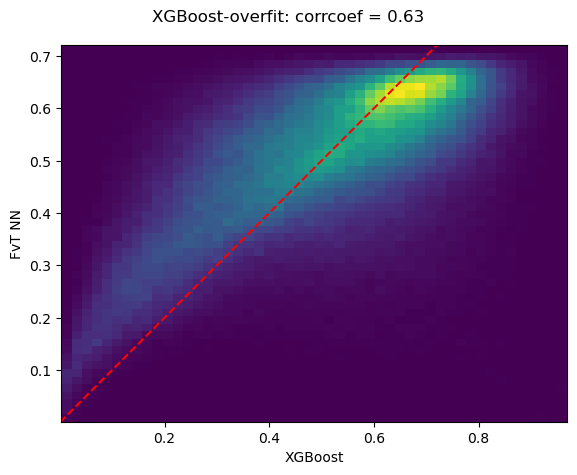

In [68]:
import time
from signal_region import get_regions_via_histogram, get_regions_via_probs_4b, get_fvt_cut_regions
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor

n_sample_ratio = 1.0
using_features = [0, 1, 2, 3, 4, 5]
w_cuts = np.arange(0.02, 1.02, 0.02)

for seed in [42, 52, 82]:
    events = events_test_dict[seed]

    events_sr_train, events_sr_test = events.split(0.5, seed=seed)
    hash = TrainingInfo.find({"experiment_name": experiment_name, "seed": seed,
                                "signal_ratio": 0.01, "n_sample_ratio": 1.0})[0]
    fvt_model = FvTClassifier.load_from_checkpoint(f"./checkpoints/{hash}_best.ckpt")
    fvt_model.eval()
    device = torch.device("cuda:0")
    fvt_model = fvt_model.to(device)
    events_sr_train.set_model_scores(fvt_model)
    events_sr_test.set_model_scores(fvt_model)

    is_3b = events_sr_test.is_3b
    is_bg4b = events_sr_test.is_bg4b
    is_signal = events_sr_test.is_signal
    is_4b = events_sr_test.is_4b
    w = events_sr_test.weights

    att_q_repr = att_q_reprs_dict[seed][n_sample_ratio]
    
    methods = ["hist", "xgbreg", "xgbreg-overfit"]

    fig, ax = plt.subplots(nrows=1, ncols=len(methods), figsize=(5 * len(methods), 7))
    fig.suptitle(f"seed={seed}, n_sample_ratio={n_sample_ratio}")

    for ax_cnt, method in enumerate(methods):
        start_time = time.time()
        if method == "xgbreg":
            xgbreg = XGBRegressor(n_estimators=32, max_depth=16, random_state=seed, objective="binary:logistic")
            xgbreg.fit(events_sr_train.att_q_repr, events_sr_train.is_4b, sample_weight=events_sr_train.weights)
            probs_4b_estimated = xgbreg.predict(events_sr_test.att_q_repr)
            is_in_regions_list = get_regions_via_probs_4b(events_sr_test, w_cuts, probs_4b_estimated)
            fig_1, ax_1 = plt.subplots()
            fig_1.suptitle("XGBoost: corrcoef = {:.2f}".format(np.corrcoef(probs_4b_estimated, events_sr_test.fvt_score)[0, 1]))
            ax_1.hist2d(probs_4b_estimated, events_sr_test.fvt_score, bins=50, weights=events_sr_test.weights)
            ax_1.plot([0, 1], [0, 1], linestyle="--", color="red")
            ax_1.set_xlabel("XGBoost")
            ax_1.set_ylabel("FvT NN")
            ax_1.set_aspect("equal")

            
        elif method == "xgbreg-overfit":
            xgbreg = XGBRegressor(n_estimators=32, max_depth=16, random_state=seed, objective="binary:logistic")
            xgbreg.fit(events_sr_test.att_q_repr, events_sr_test.is_4b, sample_weight=events_sr_test.weights)
            probs_4b_estimated = xgbreg.predict(events_sr_test.att_q_repr)
            is_in_regions_list = get_regions_via_probs_4b(events_sr_test, w_cuts, probs_4b_estimated)
            fig_1, ax_1 = plt.subplots()
            fig_1.suptitle("XGBoost-overfit: corrcoef = {:.2f}".format(np.corrcoef(probs_4b_estimated, events_sr_test.fvt_score)[0, 1]))
            ax_1.hist2d(probs_4b_estimated, events_sr_test.fvt_score, bins=50, weights=events_sr_test.weights)
            ax_1.plot([0, 1], [0, 1], linestyle="--", color="red")
            ax_1.set_xlabel("XGBoost")
            ax_1.set_ylabel("FvT NN")
            ax_1.set_aspect("equal")


        elif method == "rfreg":
            rfreg = RandomForestRegressor(n_estimators=10, max_depth=5, random_state=seed)
            rfreg.fit(events_sr_train.att_q_repr, events_sr_train.is_4b, sample_weight=events_sr_train.weights)
            probs_4b_estimated = rfreg.predict(events_sr_test.att_q_repr)
            is_in_regions_list = get_regions_via_probs_4b(events_sr_test, w_cuts, probs_4b_estimated)
        elif method == "hist":
            is_in_regions_list = get_regions_via_histogram(events_sr_test, w_cuts, n_bins=10)
        elif method == "fvt":
            is_in_regions_list = get_regions_via_probs_4b(events_sr_test, w_cuts, events_sr_test.fvt_score)
        elif method == "umap":
            is_in_regions_list = get_fvt_cut_regions(events_sr_test, 0.0, w_cuts, seed=seed)
        else:
            raise ValueError(f"Unknown method: {method}")

        print(f"Elapsed time: {time.time() - start_time:.2f} s")

        w_cut_4b = 0.2
        for i in range(len(is_in_regions_list)):
            is_in_region = is_in_regions_list[i]
            w_4b_ratio = np.sum(w[is_4b & is_in_region]) / np.sum(w[is_4b])
            if w_4b_ratio > w_cut_4b:
                is_in_region = is_in_regions_list[i - 1]
                break

        bins_range = np.linspace(0, 1, 50)

        w_signal = np.sum(w[is_signal & is_in_region]) / np.sum(w[is_signal])
        w_4b = np.sum(w[is_4b & is_in_region]) / np.sum(w[is_4b])

        current_ax = ax[ax_cnt]
        current_ax.set_title(method + "\n" + "(4b in SR) / (all 4b) = {:.2f}, \n (signal in SR) / (all signal) = {:.2f}".format(w_4b, w_signal))
        current_ax.hist(
            events_sr_test.fvt_score[is_in_region],
            bins=bins_range,
            label="SR",
            histtype="step",
            weights=w[is_in_region],
        )
        current_ax.hist(
            events_sr_test.fvt_score[~is_in_region],
            bins=bins_range,
            label="not SR",
            histtype="step",
            weights=w[~is_in_region],
        )
        current_ax.set_xlabel("FvT score")
        current_ax.legend()
    
    plt.tight_layout()
    plt.show()
    plt.close()

Elapsed time: 3.49 s


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/soheuny/miniconda3/envs/coffea_torch/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:653: Checkpoint directory /home/soheuny/HH4bsim/playground/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type       | Params
----------------------------------------
0 | encoder  | FvTEncoder | 920   
1 | select_q | conv1d     | 8     
2 | out      | conv1d     | 16    
----------------------------------------
895       Trainable params
49        Non-trainable params
944       Total params
0.004     Total estimated model params size (MB)


Epoch 9: 100%|██████████| 232/232 [00:05<00:00, 44.87it/s, v_num=1, val_loss=0.663, train_loss=0.666]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 232/232 [00:05<00:00, 44.72it/s, v_num=1, val_loss=0.663, train_loss=0.666]


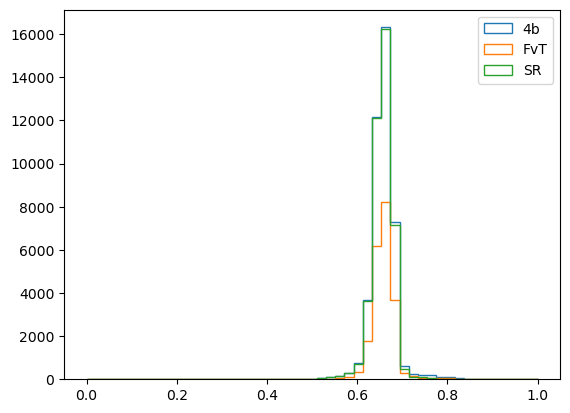

Elapsed time: 0.75 s


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type       | Params
----------------------------------------
0 | encoder  | FvTEncoder | 920   
1 | select_q | conv1d     | 8     
2 | out      | conv1d     | 16    
----------------------------------------
895       Trainable params
49        Non-trainable params
944       Total params
0.004     Total estimated model params size (MB)


Epoch 9: 100%|██████████| 227/227 [00:03<00:00, 60.32it/s, v_num=2, val_loss=0.662, train_loss=0.663]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 227/227 [00:03<00:00, 60.02it/s, v_num=2, val_loss=0.662, train_loss=0.663]


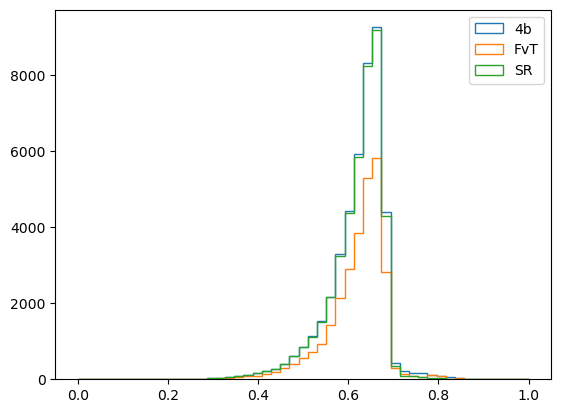

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type       | Params
----------------------------------------
0 | encoder  | FvTEncoder | 920   
1 | select_q | conv1d     | 8     
2 | out      | conv1d     | 16    
----------------------------------------
895       Trainable params
49        Non-trainable params
944       Total params
0.004     Total estimated model params size (MB)


Elapsed time: 0.87 s
Epoch 9: 100%|██████████| 244/244 [00:04<00:00, 53.02it/s, v_num=3, val_loss=0.663, train_loss=0.663]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 244/244 [00:04<00:00, 52.84it/s, v_num=3, val_loss=0.663, train_loss=0.663]


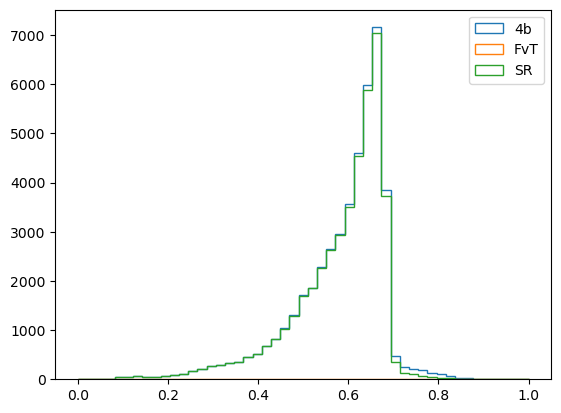

Elapsed time: 4.51 s


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type       | Params
----------------------------------------
0 | encoder  | FvTEncoder | 920   
1 | select_q | conv1d     | 8     
2 | out      | conv1d     | 16    
----------------------------------------
895       Trainable params
49        Non-trainable params
944       Total params
0.004     Total estimated model params size (MB)


Epoch 9: 100%|██████████| 233/233 [00:05<00:00, 43.23it/s, v_num=4, val_loss=0.664, train_loss=0.665]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 233/233 [00:05<00:00, 42.11it/s, v_num=4, val_loss=0.664, train_loss=0.665]


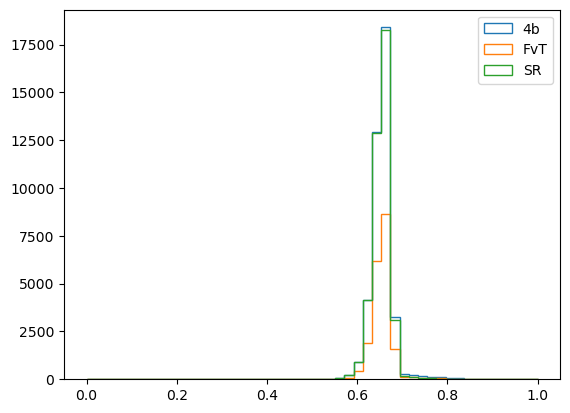

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Elapsed time: 0.75 s


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type       | Params
----------------------------------------
0 | encoder  | FvTEncoder | 920   
1 | select_q | conv1d     | 8     
2 | out      | conv1d     | 16    
----------------------------------------
895       Trainable params
49        Non-trainable params
944       Total params
0.004     Total estimated model params size (MB)


Epoch 9: 100%|██████████| 227/227 [00:03<00:00, 62.02it/s, v_num=5, val_loss=0.661, train_loss=0.662]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 227/227 [00:03<00:00, 60.03it/s, v_num=5, val_loss=0.661, train_loss=0.662]


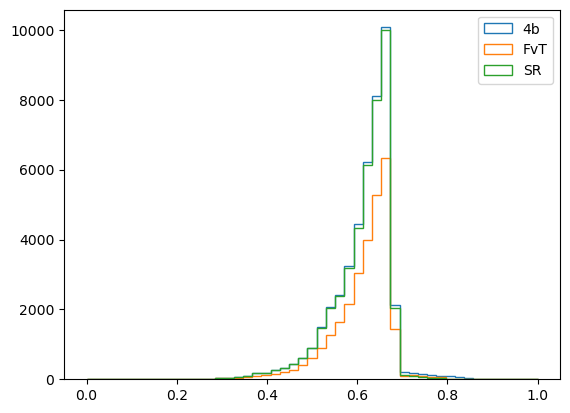

Elapsed time: 0.76 s


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type       | Params
----------------------------------------
0 | encoder  | FvTEncoder | 920   
1 | select_q | conv1d     | 8     
2 | out      | conv1d     | 16    
----------------------------------------
895       Trainable params
49        Non-trainable params
944       Total params
0.004     Total estimated model params size (MB)


Epoch 6:   0%|          | 0/245 [00:00<?, ?it/s, v_num=6, val_loss=0.662, train_loss=0.663]          

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f3d1756fba0>
Traceback (most recent call last):
  File "/home/soheuny/miniconda3/envs/coffea_torch/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/home/soheuny/miniconda3/envs/coffea_torch/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1443, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/home/soheuny/miniconda3/envs/coffea_torch/lib/python3.11/multiprocessing/process.py", line 149, in join
    res = self._popen.wait(timeout)
          ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/soheuny/miniconda3/envs/coffea_torch/lib/python3.11/multiprocessing/popen_fork.py", line 40, in wait
    if not wait([self.sentinel], timeout):
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/soheuny/miniconda3/envs/coffea_torch/lib/python3.11/multiprocessing/connection.py", line 948, in wait
    ready = s

Epoch 9: 100%|██████████| 245/245 [00:03<00:00, 63.68it/s, v_num=6, val_loss=0.661, train_loss=0.662]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 245/245 [00:03<00:00, 61.77it/s, v_num=6, val_loss=0.661, train_loss=0.662]


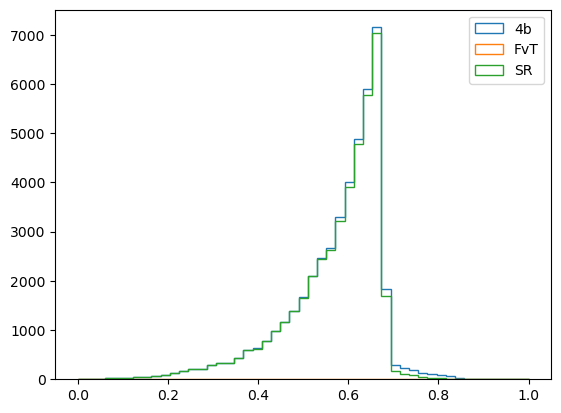

KeyboardInterrupt: 

In [70]:
# import time
# from signal_region import get_regions_via_histogram, get_regions_via_probs_4b, get_fvt_cut_regions
# from xgboost import XGBRegressor
# from sklearn.ensemble import RandomForestRegressor

# n_sample_ratio = 1.0
# using_features = [0, 1, 2, 3, 4, 5]
# w_cuts = np.arange(0.02, 1.02, 0.02)

# for seed in [42, 52, 82]:
#     events = events_test_dict[seed]

#     events_sr_train, events_sr_test = events.split(0.5, seed=seed)
#     hash = TrainingInfo.find({"experiment_name": experiment_name, "seed": seed,
#                                 "signal_ratio": 0.01, "n_sample_ratio": 1.0})[0]
#     fvt_model = FvTClassifier.load_from_checkpoint(f"./checkpoints/{hash}_best.ckpt")
#     fvt_model.eval()
#     device = torch.device("cuda:0")
#     fvt_model = fvt_model.to(device)
#     events_sr_train.set_model_scores(fvt_model)
#     events_sr_test.set_model_scores(fvt_model)

#     is_3b = events_sr_test.is_3b
#     is_bg4b = events_sr_test.is_bg4b
#     is_signal = events_sr_test.is_signal
#     is_4b = events_sr_test.is_4b
#     w = events_sr_test.weights

#     att_q_repr = att_q_reprs_dict[seed][n_sample_ratio]
    
#     methods = ["hist", "xgbreg", "xgbreg-overfit"]

#     for ax_cnt, method in enumerate(methods):
#         start_time = time.time()
#         if method == "xgbreg":
#             xgbreg = XGBRegressor(n_estimators=32, max_depth=16, random_state=seed, objective="binary:logistic")
#             xgbreg.fit(events_sr_train.att_q_repr, events_sr_train.is_4b, sample_weight=events_sr_train.weights)
#             probs_4b_estimated = xgbreg.predict(events_sr_test.att_q_repr)
#             is_in_regions_list = get_regions_via_probs_4b(events_sr_test, w_cuts, probs_4b_estimated)
#         elif method == "xgbreg-overfit":
#             xgbreg = XGBRegressor(n_estimators=32, max_depth=16, random_state=seed, objective="binary:logistic")
#             xgbreg.fit(events_sr_test.att_q_repr, events_sr_test.is_4b, sample_weight=events_sr_test.weights)
#             probs_4b_estimated = xgbreg.predict(events_sr_test.att_q_repr)
#             is_in_regions_list = get_regions_via_probs_4b(events_sr_test, w_cuts, probs_4b_estimated)
#         elif method == "rfreg":
#             rfreg = RandomForestRegressor(n_estimators=10, max_depth=5, random_state=seed)
#             rfreg.fit(events_sr_train.att_q_repr, events_sr_train.is_4b, sample_weight=events_sr_train.weights)
#             probs_4b_estimated = rfreg.predict(events_sr_test.att_q_repr)
#             is_in_regions_list = get_regions_via_probs_4b(events_sr_test, w_cuts, probs_4b_estimated)
#         elif method == "hist":
#             is_in_regions_list = get_regions_via_histogram(events_sr_test, w_cuts, n_bins=10)
#         elif method == "fvt":
#             is_in_regions_list = get_regions_via_probs_4b(events_sr_test, w_cuts, events_sr_test.fvt_score)
#         elif method == "umap":
#             is_in_regions_list = get_fvt_cut_regions(events_sr_test, 0.0, w_cuts, seed=seed)
#         else:
#             raise ValueError(f"Unknown method: {method}")

#         print(f"Elapsed time: {time.time() - start_time:.2f} s")

#         w_cut_4b = 0.2
#         for i in range(len(is_in_regions_list)):
#             is_in_region = is_in_regions_list[i]
#             w_4b_ratio = np.sum(w[is_4b & is_in_region]) / np.sum(w[is_4b])
#             if w_4b_ratio > w_cut_4b:
#                 is_in_region = is_in_regions_list[i - 1]
#                 break

#         # new FvT classifier

#         sr_model = FvTClassifier(
#         num_classes=2,
#         dim_input_jet_features=4,
#         dim_dijet_features=6,
#         dim_quadjet_features=6,
#         run_name="",
#         device=torch.device("cuda:0"),
#         lr=1e-3,
#         )
#         device = torch.device("cuda:0")
#         batch_size = 1024
        
#         events_sr_test_train, events_sr_test_val = events_sr_test[~is_in_region].split(2/3, seed=seed)
#         events_sr_test_train.fit_batch_size(batch_size)
#         events_sr_test_val.fit_batch_size(batch_size)

#         sr_model.fit(events_sr_test_train.to_tensor_dataset(), 
#                      events_sr_test_val.to_tensor_dataset(), 
#                      batch_size=1024, max_epochs=5)
#         sr_model.eval()
#         events_in_sr = events_sr_test[is_in_region]

#         # SR model
#         events_in_sr.set_model_scores(sr_model)
#         weights_rw = np.where(events_in_sr.is_4b, 
#                               events_in_sr.weights, 
#                               ((events_in_sr.fvt_score / events_in_sr.total_weight_4b) 
#                                / ((1 - events_in_sr.fvt_score) / (events_in_sr.total_weight - events_in_sr.total_weight_4b)) 
#                                * events_in_sr.weights))

#         # FvT model
#         events_in_sr.set_model_scores(fvt_model)
#         weights_fvt = np.where(events_in_sr.is_4b, 
#                                events_in_sr.weights, 
#                                ((events_in_sr.fvt_score / events_in_sr.total_weight_4b) 
#                                / ((1 - events_in_sr.fvt_score) / (events_in_sr.total_weight - events_in_sr.total_weight_4b)) 
#                                * events_in_sr.weights))
        
#         bins_range = np.linspace(0, 1, 50)
#         plt.hist(events_in_sr.fvt_score[events_in_sr.is_4b], 
#                  weights=events_in_sr.weights[events_in_sr.is_4b],
#                  bins=bins_range, label="4b", histtype="step")
#         plt.hist(events_in_sr.fvt_score[events_in_sr.is_3b],
#                 weights=weights_fvt[events_in_sr.is_3b],
#                 bins=bins_range, label="FvT", histtype="step")
#         plt.hist(events_in_sr.fvt_score[events_in_sr.is_bg4b],
#                 weights=weights_rw[events_in_sr.is_bg4b],
#                 bins=bins_range, label="SR", histtype="step") 
#         plt.legend()
#         plt.show()
#         plt.close()



        


In [37]:
# XGB hyparams tuning

import pandas as pd
from itertools import product
import cupy as cp

n_sample_ratio = 1.0
using_features = [0, 1, 2, 3, 4, 5]
w_cuts = np.arange(0.01, 1.01, 0.01)

max_depths = [2**i for i in range(1, 5)]
n_estimators = [2**i for i in range(3, 9)]

performance_dict = {seed: {} for seed in seeds}

for seed in seeds:
    events = events_test_dict[seed]
    is_3b = events.is_3b
    is_bg4b = events.is_bg4b
    is_signal = events.is_signal
    is_4b = events.is_4b
    w = events.weights

    hash = TrainingInfo.find({"experiment_name": experiment_name, "seed": seed, "n_sample_ratio": n_sample_ratio})[0]
    tinfo = TrainingInfo.load(hash)
    fvt_model = FvTClassifier.load_from_checkpoint(f"./checkpoints/{hash}_best.ckpt")
    fvt_model.eval()
    device = torch.device("cuda:0")
    fvt_model = fvt_model.to(device)
    events_sr_train, events_sr_test = events.split(0.5, seed=seed)
    events_sr_train.set_model_scores(fvt_model)
    events_sr_test.set_model_scores(fvt_model)

    att_q_repr = att_q_reprs_dict[seed][n_sample_ratio]
    X_train = cp.array(events_sr_train.att_q_repr)
    y_train = cp.array(events_sr_train.is_4b)
    w_train = cp.array(events_sr_train.weights)

    for n_estimator, max_depth in tqdm.tqdm(product(n_estimators, max_depths)):
        start_time = time.time()
        xgbreg = XGBRegressor(n_estimators=n_estimator, max_depth=max_depth, random_state=seed)
        xgbreg.fit(X_train, y_train, sample_weight=w_train)
        
        probs_4b_estimated = xgbreg.predict(events_sr_test.att_q_repr)
        is_in_regions_list = get_regions_via_probs_4b(events_sr_test, w_cuts, probs_4b_estimated)

        w_signal = np.array([np.sum(events_sr_test.weights[events_sr_test.is_signal & is_in_regions]) 
                             for is_in_regions in is_in_regions_list]) / np.sum(
                                 events_sr_test.weights[events_sr_test.is_signal])
        w_4b = np.array([np.sum(events_sr_test.weights[events_sr_test.is_4b & is_in_regions]) 
                             for is_in_regions in is_in_regions_list]) / np.sum(
                                 events_sr_test.weights[events_sr_test.is_4b])

        # calculate area under (w_4b, w_signal) curve

        auc = 0
        for i in range(1, len(w_4b)):
            auc += (w_4b[i] - w_4b[i - 1]) * (w_signal[i] + w_signal[i - 1]) / 2

        performance_dict[seed][(n_estimator, max_depth)] = auc
        
df = pd.DataFrame(performance_dict)

24it [00:25,  1.08s/it]
24it [00:25,  1.08s/it]
24it [00:27,  1.14s/it]
24it [00:25,  1.07s/it]
24it [00:28,  1.17s/it]
24it [00:26,  1.09s/it]


In [38]:
df.T.describe()

8                                       16                       \
             2         4         8         16        2         4         8    
count  6.000000  6.000000  6.000000  6.000000  6.000000  6.000000  6.000000   
mean   0.634155  0.660344  0.672354  0.632287  0.652913  0.673279  0.674089   
std    0.078210  0.085196  0.064179  0.045476  0.078291  0.073342  0.062161   
min    0.517017  0.506608  0.569332  0.558103  0.513821  0.550543  0.576693   
25%    0.596023  0.636616  0.636646  0.607834  0.629315  0.638485  0.636713   
50%    0.629925  0.687953  0.692749  0.649547  0.671519  0.696269  0.694112   
75%    0.698727  0.721158  0.720052  0.664346  0.710509  0.730788  0.722030   
max    0.721680  0.727821  0.732196  0.673316  0.721865  0.735079  0.730698   

                      32             ...       64                  128  \
             16        2         4   ...        8         16        2    
count  6.000000  6.000000  6.000000  ...  6.000000  6.000000  6.000000   
mean   0.632971  0.671957  0.677216  ...  0.667040  0.618163  0.681044   
std    0.048390  0.075805  0.070540  ...  0.056070  0.036528  0.070870   
min    0.554299  0.543471  0.561062  ...  0.581802  0.556163  0.566615   
25%    0.606765  0.638781  0.641228  ...  0.630248  0.601221  0.642112   
50%    0.649964  0.695152  0.699771  ...  0.687529  0.633463  0.704734   
75%    0.669866  0.730536  0.731419  ...  0.707938  0.643212  0.733312   
max    0.674734  0.735646  0.739008  ...  0.719483  0.648950  0.746102   

                                          256                                
             4         8         16        2         4         8         16  
count  6.000000  6.000000  6.000000  6.000000  6.000000  6.000000  6.000000  
mean   0.678837  0.656749  0.611062  0.682928  0.674754  0.649113  0.606286  
std    0.064798  0.052047  0.033289  0.069563  0.062281  0.044783  0.033311  
min    0.577808  0.573685  0.551556  0.574141  0.578809  0.575889  0.551656  
25%    0.639014  0.626800  0.600006  0.640544  0.635115  0.625420  0.590139  
50%    0.703313  0.677680  0.624160  0.707416  0.698990  0.666322  0.614777  
75%    0.724042  0.691144  0.634080  0.734701  0.718403  0.678813  0.629294  
max    0.740057  0.705979  0.637152  0.746546  0.733036  0.691384  0.640445  

[8 rows x 24 columns]

Best hparams: n_estimator=256, max_depth=2


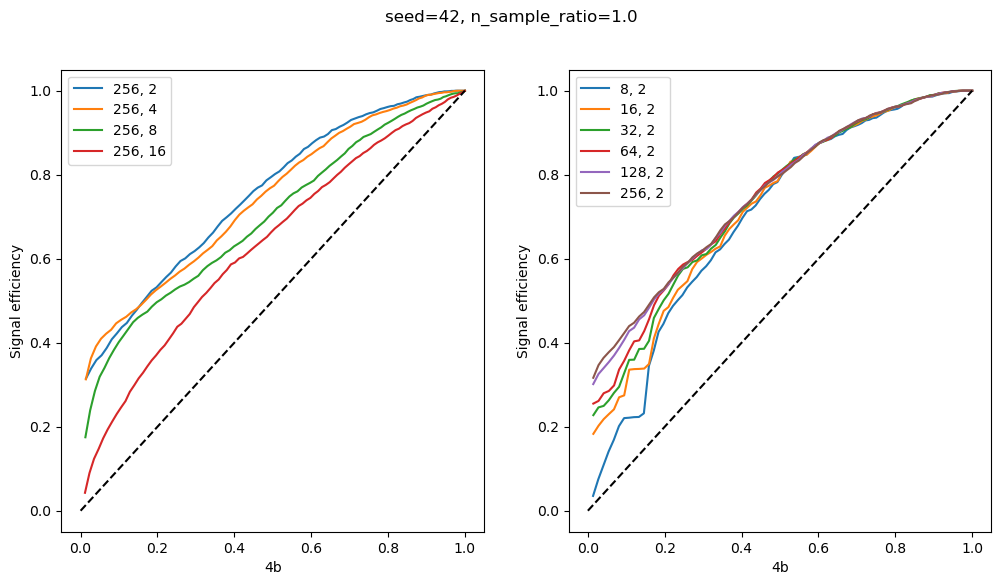

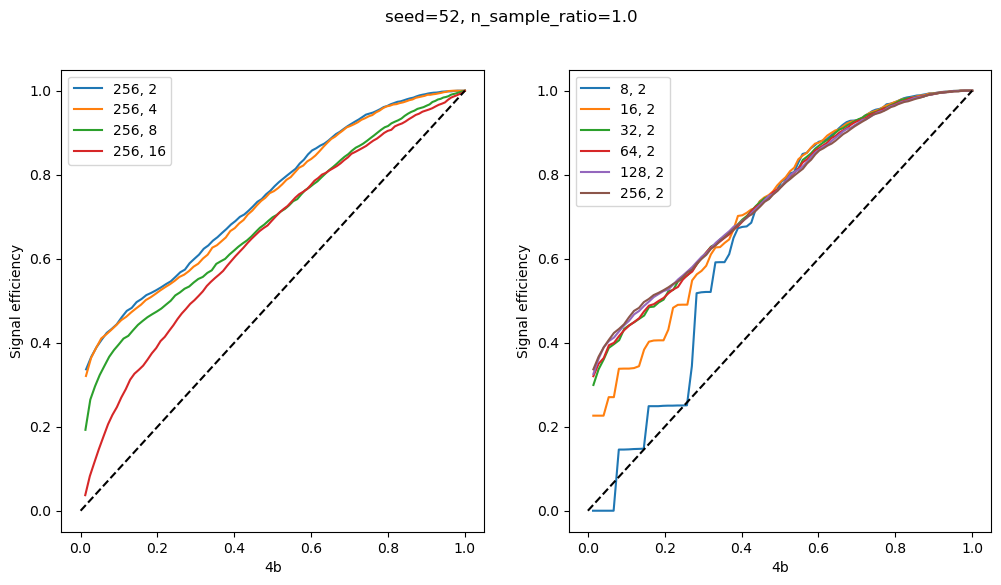

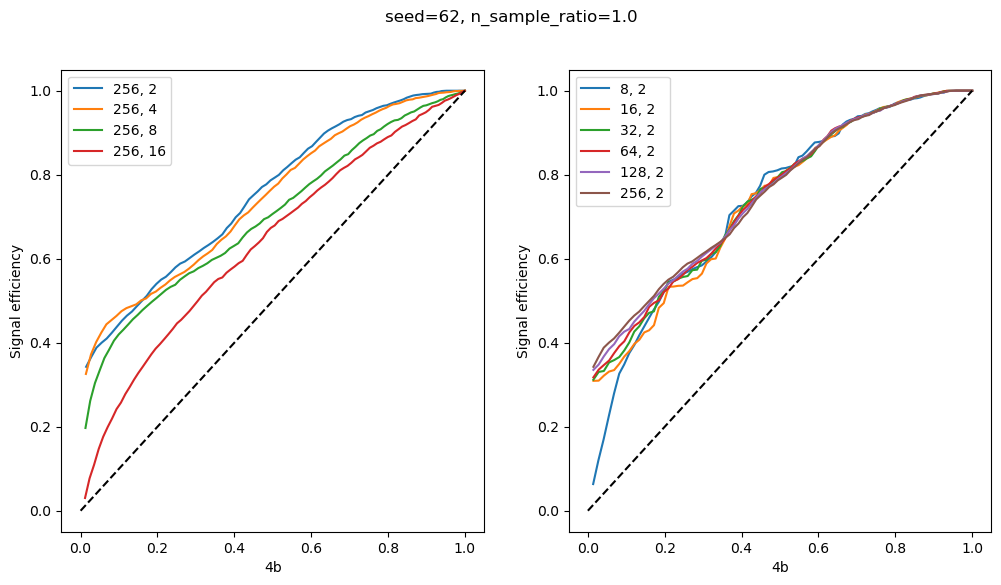

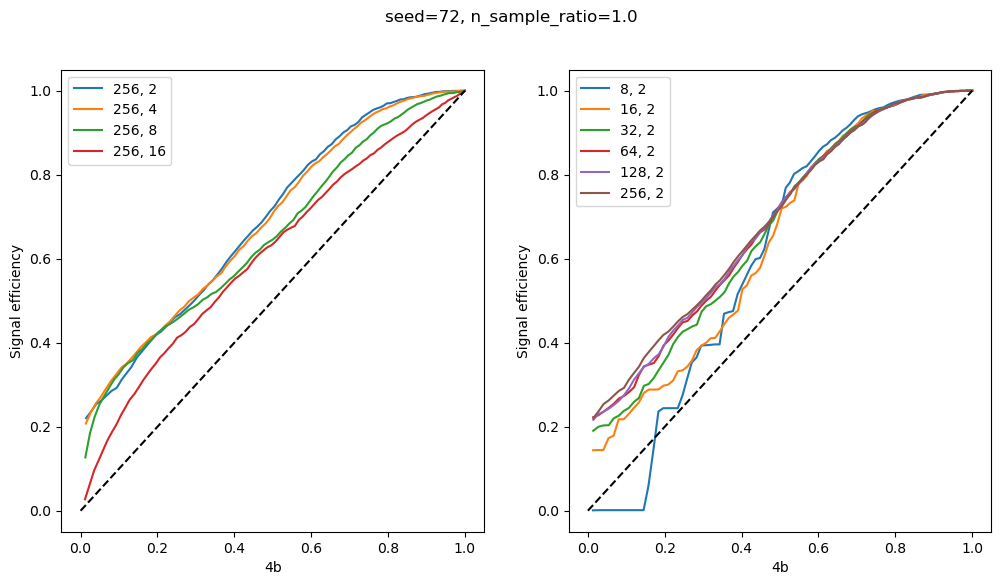

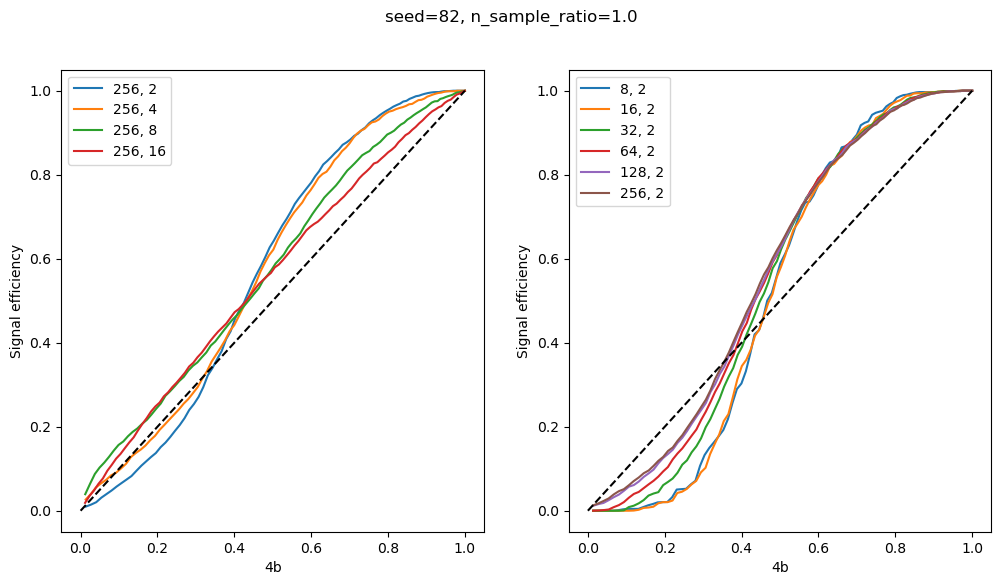

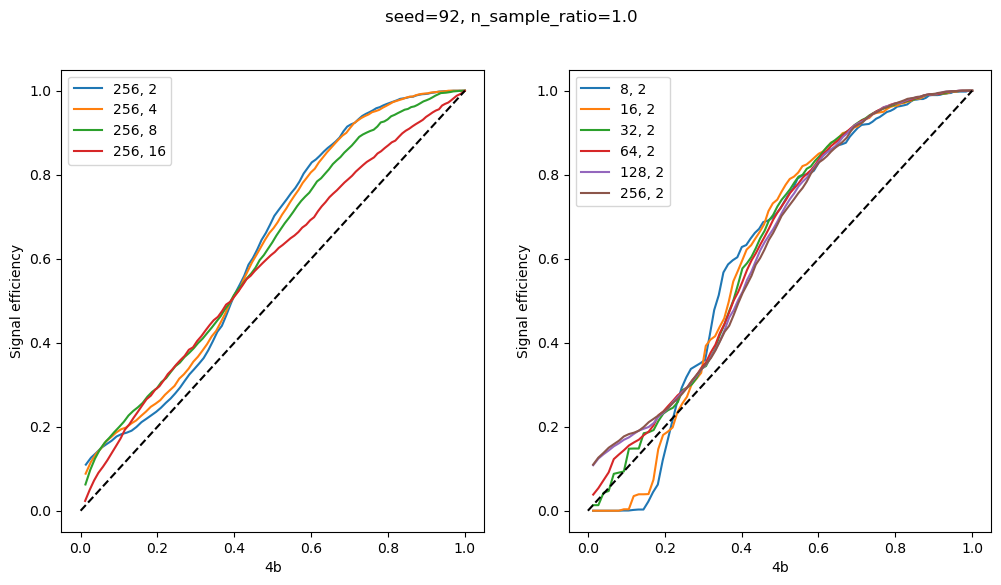

In [39]:
best_n_estimator, best_max_depth = df.T.describe().loc["mean"].idxmax()

print(f"Best hparams: n_estimator={best_n_estimator}, max_depth={best_max_depth}")
# plots for best params

for seed in seeds:
    events = events_test_dict[seed]
    is_3b = events.is_3b
    is_bg4b = events.is_bg4b
    is_signal = events.is_signal
    is_4b = events.is_4b
    w = events.weights

    hash = TrainingInfo.find({"experiment_name": experiment_name, "seed": seed, "n_sample_ratio": n_sample_ratio})[0]
    tinfo = TrainingInfo.load(hash)
    fvt_model = FvTClassifier.load_from_checkpoint(f"./checkpoints/{hash}_best.ckpt")
    fvt_model.eval()
    device = torch.device("cuda:0")
    fvt_model = fvt_model.to(device)
    events_sr_train, events_sr_test = events.split(0.5, seed=seed)
    events_sr_train.set_model_scores(fvt_model)
    events_sr_test.set_model_scores(fvt_model)    

    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
    fig.suptitle(f"seed={seed}, n_sample_ratio={n_sample_ratio}")

    att_q_repr = att_q_reprs_dict[seed][n_sample_ratio]
    X_train = cp.array(events_sr_train.att_q_repr)
    y_train = cp.array(events_sr_train.is_4b)
    w_train = cp.array(events_sr_train.weights)

    for max_depth in max_depths:
        xgbreg = XGBRegressor(n_estimators=best_n_estimator, max_depth=max_depth, random_state=seed)
        xgbreg.fit(X_train, y_train, sample_weight=w_train)

        probs_4b_estimated = xgbreg.predict(events_sr_test.att_q_repr)
        is_in_regions_list = get_regions_via_probs_4b(events_sr_test, w_cuts, probs_4b_estimated)

        w_signal = np.array([np.sum(events_sr_test.weights[events_sr_test.is_signal & is_in_regions]) 
                             for is_in_regions in is_in_regions_list]) / np.sum(
                                 events_sr_test.weights[events_sr_test.is_signal])
        w_4b = np.array([np.sum(events_sr_test.weights[events_sr_test.is_4b & is_in_regions]) 
                             for is_in_regions in is_in_regions_list]) / np.sum(
                                 events_sr_test.weights[events_sr_test.is_4b])
        w_all = np.array([np.sum(events_sr_test.weights[is_in_regions])
                            for is_in_regions in is_in_regions_list]) / np.sum(events_sr_test.weights)


        ax[0].plot( 
            w_4b,
            w_signal,
            label=f"{best_n_estimator}, {max_depth}",
        )

    ax[0].plot([0, 1], [0, 1], linestyle="--", color="black")
    ax[0].set_xlabel("4b")
    ax[0].set_ylabel("Signal efficiency")
    ax[0].legend()
    
    for n_estimator in n_estimators:
        xgbreg = XGBRegressor(n_estimators=n_estimator, max_depth=best_max_depth, random_state=seed)
        xgbreg.fit(X_train, y_train, sample_weight=w_train)

        probs_4b_estimated = xgbreg.predict(events_sr_test.att_q_repr)
        is_in_regions_list = get_regions_via_probs_4b(events_sr_test, w_cuts, probs_4b_estimated)

        w_signal = np.array([np.sum(events_sr_test.weights[events_sr_test.is_signal & is_in_regions]) 
                             for is_in_regions in is_in_regions_list]) / np.sum(
                                 events_sr_test.weights[events_sr_test.is_signal])
        w_4b = np.array([np.sum(events_sr_test.weights[events_sr_test.is_4b & is_in_regions])
                                for is_in_regions in is_in_regions_list]) / np.sum(
                                    events_sr_test.weights[events_sr_test.is_4b])
        w_all = np.array([np.sum(events_sr_test.weights[is_in_regions])
                            for is_in_regions in is_in_regions_list]) / np.sum(events_sr_test.weights)


        ax[1].plot( 
            w_4b,
            w_signal,
            label=f"{n_estimator}, {best_max_depth}",
        )

    ax[1].plot([0, 1], [0, 1], linestyle="--", color="black")
    
    ax[1].set_xlabel("4b")
    ax[1].set_ylabel("Signal efficiency")
    ax[1].legend()

    plt.show()
    plt.close()

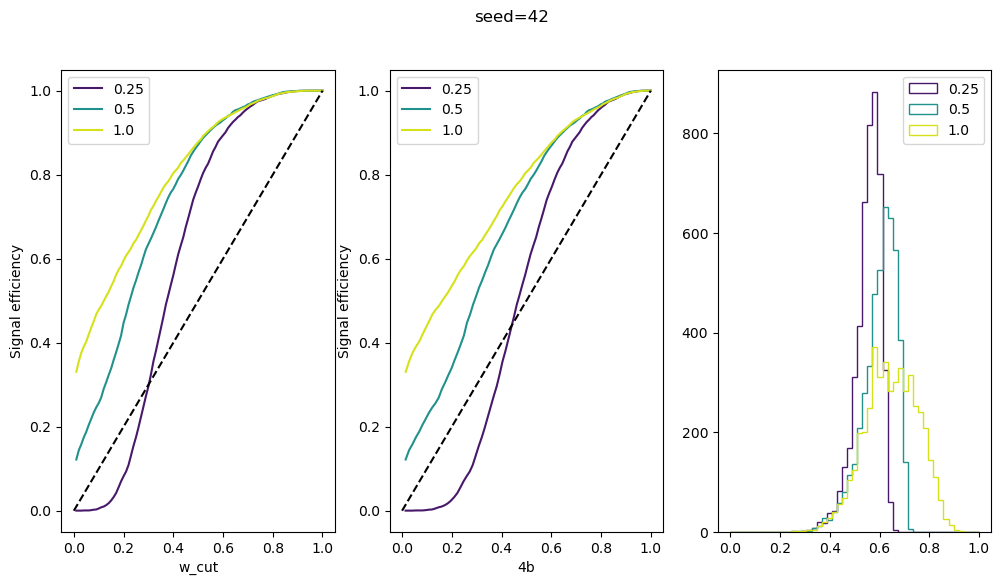

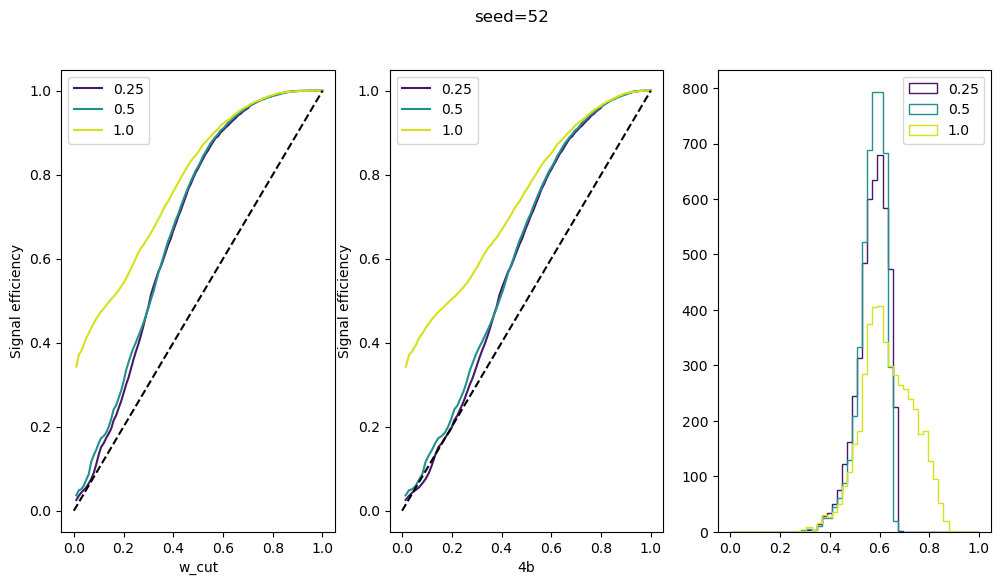

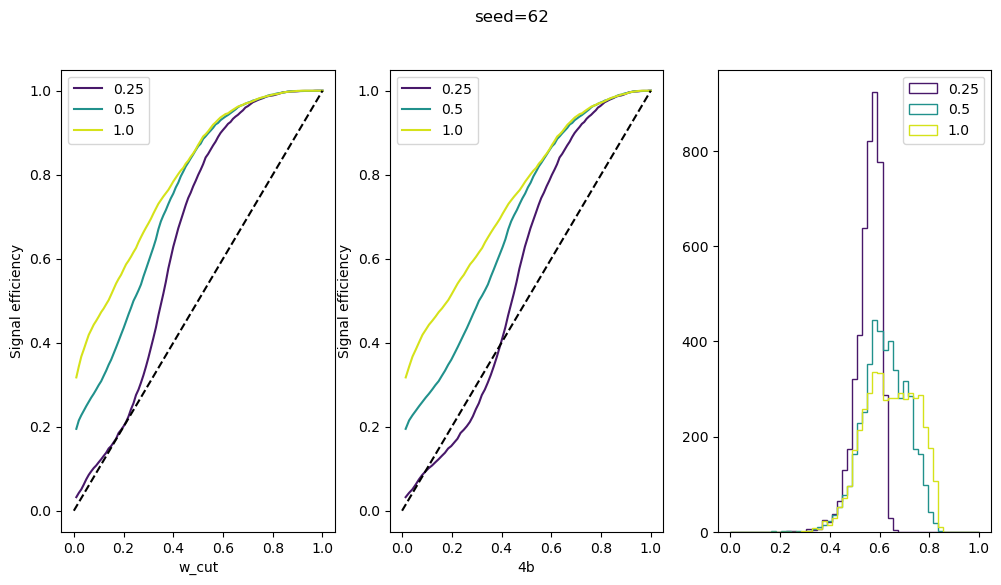

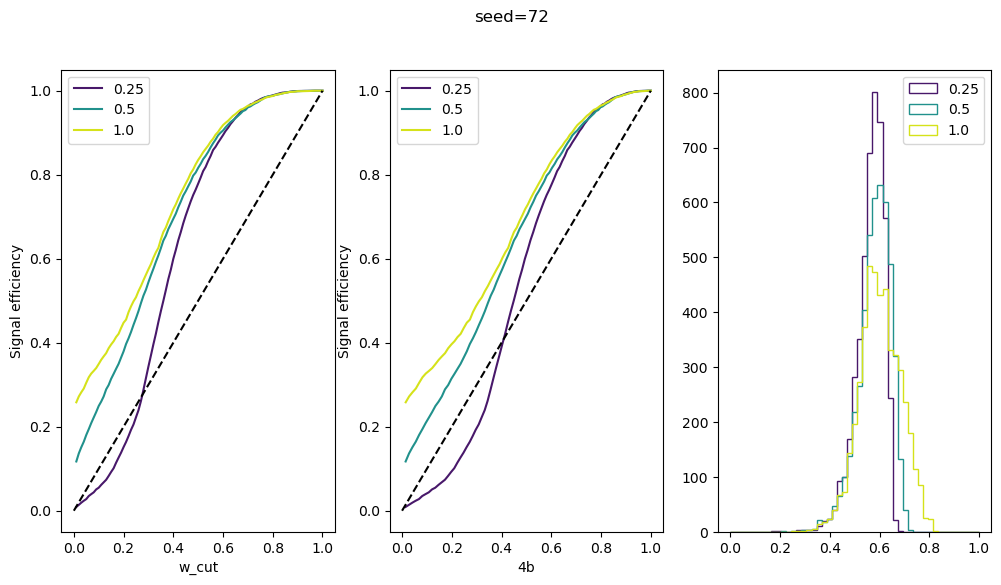

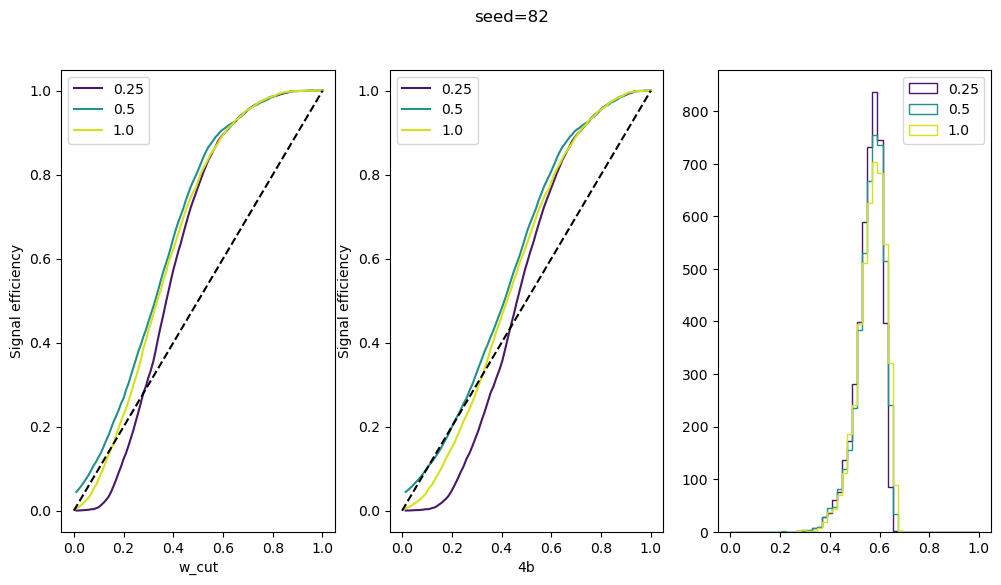

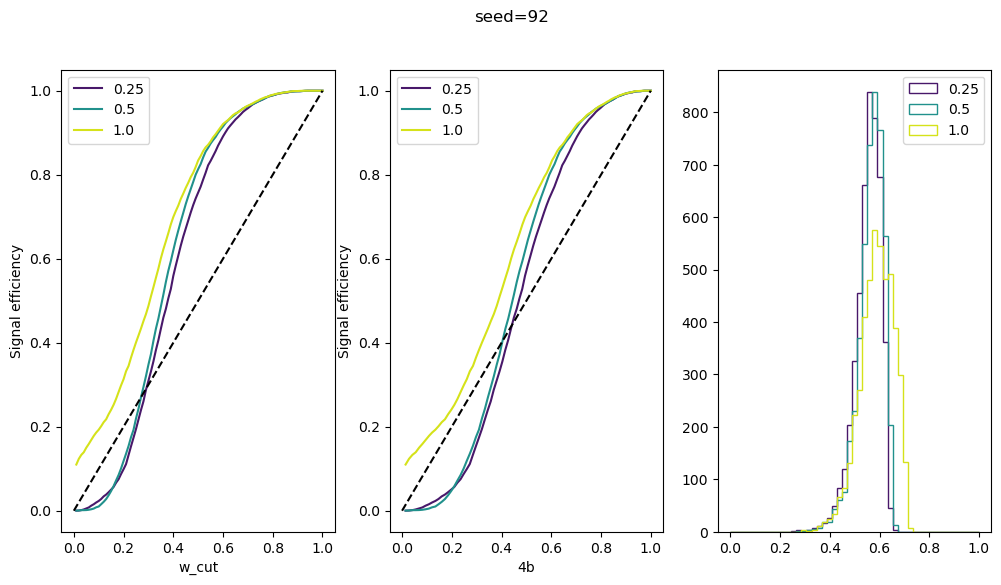

In [46]:
cmin = np.log(min(n_sample_ratios))
cmax = np.log(max(n_sample_ratios))
margin = 0.1
color = lambda x: cmap((np.log(x) - cmin + margin) / (cmax - cmin + 2 * margin))

for seed in seeds:
    events = events_test_dict[seed]

    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 6))
    fig.suptitle(f"seed={seed}")

    for n_sample_ratio in n_sample_ratios:
        hash = TrainingInfo.find({"experiment_name": experiment_name, "seed": seed, "n_sample_ratio": n_sample_ratio})[0]
        tinfo = TrainingInfo.load(hash)
        fvt_model = FvTClassifier.load_from_checkpoint(f"./checkpoints/{hash}_best.ckpt")
        fvt_model.eval()
        device = torch.device("cuda:0")
        fvt_model = fvt_model.to(device)
        events.set_model_scores(fvt_model)

        xgbreg = XGBRegressor(n_estimators=best_n_estimator, max_depth=best_max_depth, random_state=seed)
        xgbreg.fit(events.att_q_repr, events.is_4b, sample_weight=events.weights)
        probs_4b_estimated = xgbreg.predict(events.att_q_repr)
        is_in_regions_list = get_regions_via_probs_4b(events, w_cuts, probs_4b_estimated)

        w_signal = np.array([np.sum(events.weights[events.is_signal & is_in_regions]) 
                             for is_in_regions in is_in_regions_list]) / np.sum(events.weights[events.is_signal])
        w_4b = np.array([np.sum(events.weights[events.is_4b & is_in_regions]) 
                         for is_in_regions in is_in_regions_list]) / np.sum(events.weights[events.is_4b])
        w_all = np.array([np.sum(events.weights[is_in_regions]) for is_in_regions in is_in_regions_list]) / np.sum(events.weights)

        ax[0].plot( 
            w_all,
            w_signal,
            label=f"{n_sample_ratio}",
            color=color(n_sample_ratio),
        )
        
        ax[1].plot( 
            w_4b,
            w_signal,
            label=f"{n_sample_ratio}",
            color=color(n_sample_ratio),
        )

        bins_range = np.linspace(0, 1, 50)
        ax[2].hist(events.fvt_score[events.events.is_signal], bins=bins_range, 
                    label=n_sample_ratio, histtype="step", 
                    weights=events.weights[events.events.is_signal], 
                    color=color(n_sample_ratio))    

    ax[0].plot([0, 1], [0, 1], linestyle="--", color="black")
    ax[0].set_xlabel("w_cut")
    ax[0].set_ylabel("Signal efficiency")
    ax[0].legend()
    
    ax[1].plot([0, 1], [0, 1], linestyle="--", color="black")
    ax[1].set_xlabel("4b")
    ax[1].set_ylabel("Signal efficiency")
    ax[1].legend()

    ax[2].legend()
    
    plt.show()
    plt.close()

# Overfitting is the key?
With and without validation

TypeError: train_test_split() got multiple values for argument 'test_size'

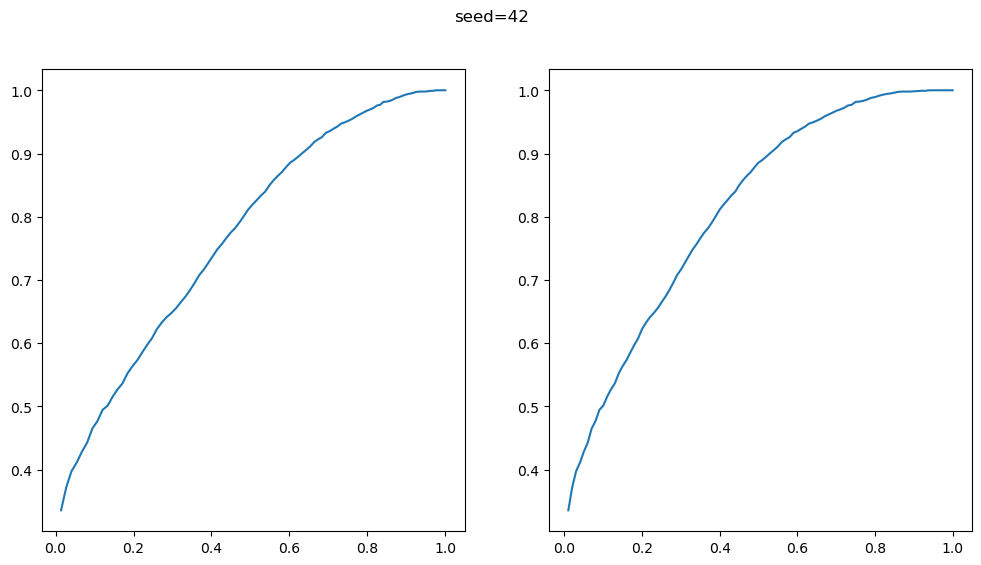

In [41]:
n_sample_ratio = 1.0

for seed in seeds:
    events = events_test_dict[seed]
    is_3b = events.is_3b
    is_bg4b = events.is_bg4b
    is_signal = events.is_signal
    is_4b = events.is_4b
    w = events.weights


    hash = TrainingInfo.find({"experiment_name": experiment_name, "seed": seed, "n_sample_ratio": n_sample_ratio})[0]
    tinfo = TrainingInfo.load(hash)
    fvt_model = FvTClassifier.load_from_checkpoint(f"./checkpoints/{hash}_best.ckpt")
    fvt_model.eval()
    device = torch.device("cuda:0")
    fvt_model = fvt_model.to(device)
    events_sr_train, events_sr_test = events.split(0.5, seed=seed)
    events_sr_train.set_model_scores(fvt_model)
    events_sr_test.set_model_scores(fvt_model)

    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
    fig.suptitle(f"seed={seed}")
    att_q_repr = att_q_reprs_dict[seed][n_sample_ratio]

    for validation in [False, True]:
        if validation:
            X_train, X_val, y_train, y_val, w_train, w_val = train_test_split(
                events_sr_train.att_q_repr, events_sr_train.is_4b, events_sr_train.weights, 
                test_size=0.2, random_state=seed)
            
            dtrain = xgb.DMatrix(X_train, label=y_train, weight=w_train)
            dval = xgb.DMatrix(X_val, label=y_val, weight=w_val)
            
            param = {
                "max_depth": best_max_depth,
                "objective": "binary:logistic",
                "eval_metric": "logloss",
                "seed": seed,
            }
            num_round = best_n_estimator
            bst = xgb.train(param, dtrain, num_round, evals=[(dval, "eval")], 
                            early_stopping_rounds=100, verbose_eval=False)
            
            dtest = xgb.DMatrix(events_sr_test.att_q_repr)
            probs_4b_estimated = bst.predict(dtest)
        else:
            xgbreg = XGBRegressor(n_estimators=best_n_estimator, max_depth=best_max_depth, random_state=seed, 
                                  objective="binary:logistic", eval_metric="logloss")
            xgbreg.fit(events_sr_train.att_q_repr, events_sr_train.is_4b, 
                      sample_weight=events_sr_train.weights)
            
            probs_4b_estimated = xgbreg.predict(events_sr_test.att_q_repr)


        is_in_regions_list = get_regions_via_probs_4b(events_sr_test, w_cuts, probs_4b_estimated)
        
        w_sr_test = events_sr_test.weights
        is_signal_sr_test = events_sr_test.is_signal
        is_4b_sr_test = events_sr_test.is_4b

        w_signal = np.array([np.sum(w_sr_test[is_signal_sr_test & is_in_regions]) 
                             for is_in_regions in is_in_regions_list]) / np.sum(w_sr_test[is_signal_sr_test])
        w_4b = np.array([np.sum(w_sr_test[is_4b_sr_test & is_in_regions]) 
                             for is_in_regions in is_in_regions_list]) / np.sum(w_sr_test[is_4b_sr_test])
        w_all = np.array([np.sum(w_sr_test[is_in_regions]) for is_in_regions in is_in_regions_list]) / np.sum(w_sr_test)

        ax[1].plot( 
            w_all,
            w_signal,
            label="validation" if validation else "Without validation",
        )
        
        ax[0].plot( 
            w_4b,
            w_signal,
            label="validation" if validation else "Without validation",
        )

        bins_range = np.linspace(0, 1, 50)
        

    ax[1].plot([0, 1], [0, 1], linestyle="--", color="black")
    ax[1].set_xlabel("w_cut")
    ax[1].set_ylabel("Signal efficiency")
    ax[1].legend()
    
    ax[0].plot([0, 1], [0, 1], linestyle="--", color="black")
    ax[0].set_xlabel("4b")
    ax[0].set_ylabel("Signal efficiency")
    ax[0].legend()
    
    plt.show()
    plt.close()

In [47]:
X_train = cp.array(events_sr_train.att_q_repr)
y_train = cp.array(events_sr_train.is_4b)
w_train = cp.array(events_sr_train.weights)

xgbreg = XGBRegressor(n_estimators=best_n_estimator, max_depth=best_max_depth, random_state=seed)

start_time = time.time()
xgbreg.fit(X_train, y_train, sample_weight=w_train)
print(f"Elapsed time: {time.time() - start_time:.2f} s")

X_train = events_sr_train.att_q_repr
y_train = events_sr_train.is_4b
w_train = events_sr_train.weights

start_time = time.time()
xgbreg.fit(X_train, y_train, sample_weight=w_train)
print(f"Elapsed time: {time.time() - start_time:.2f} s")


Elapsed time: 0.36 s
Elapsed time: 0.50 s


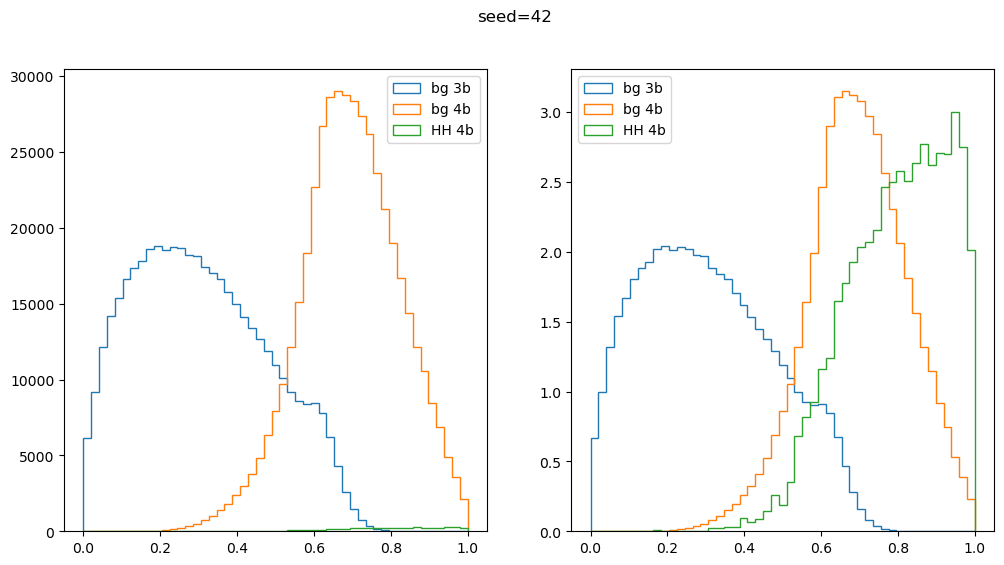

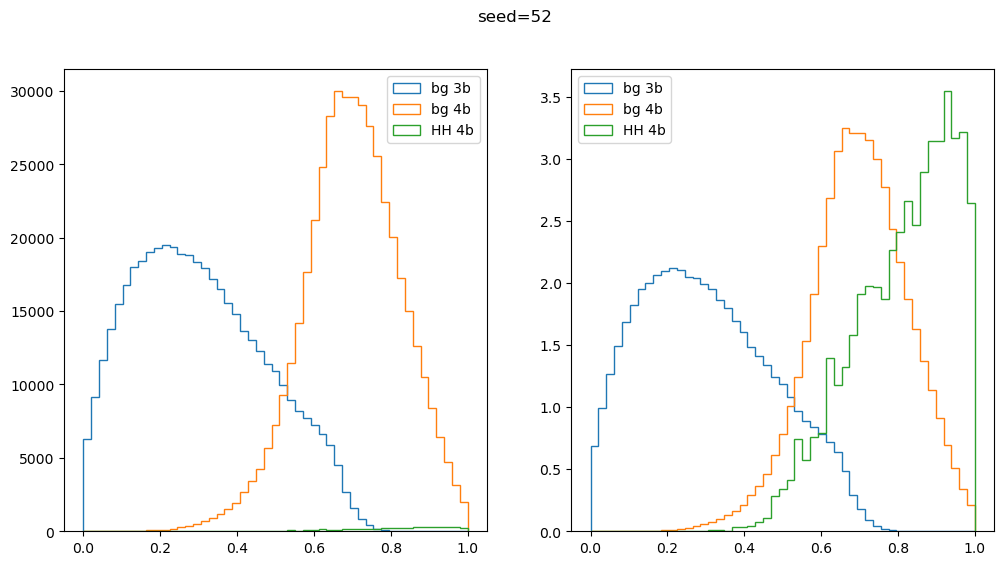

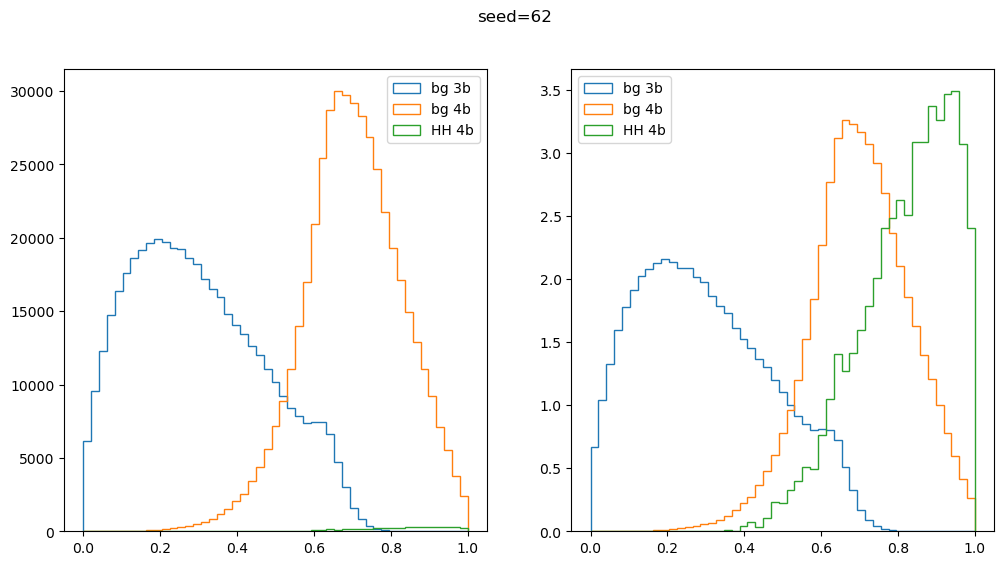

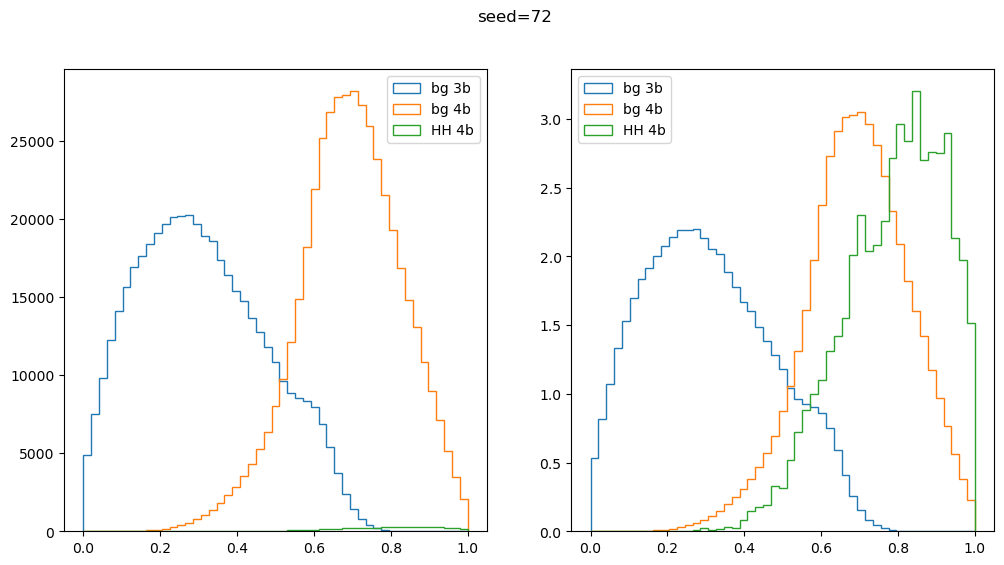

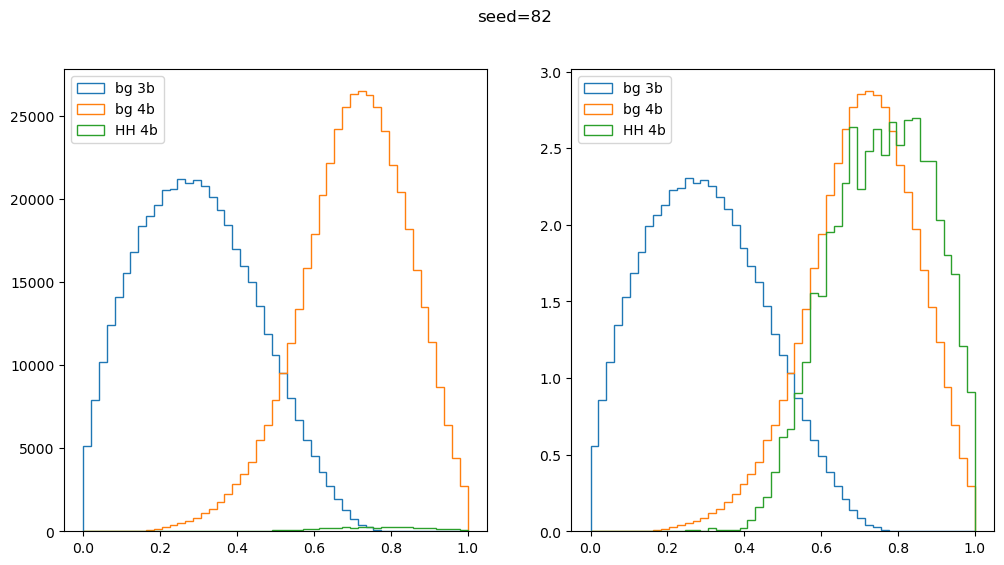

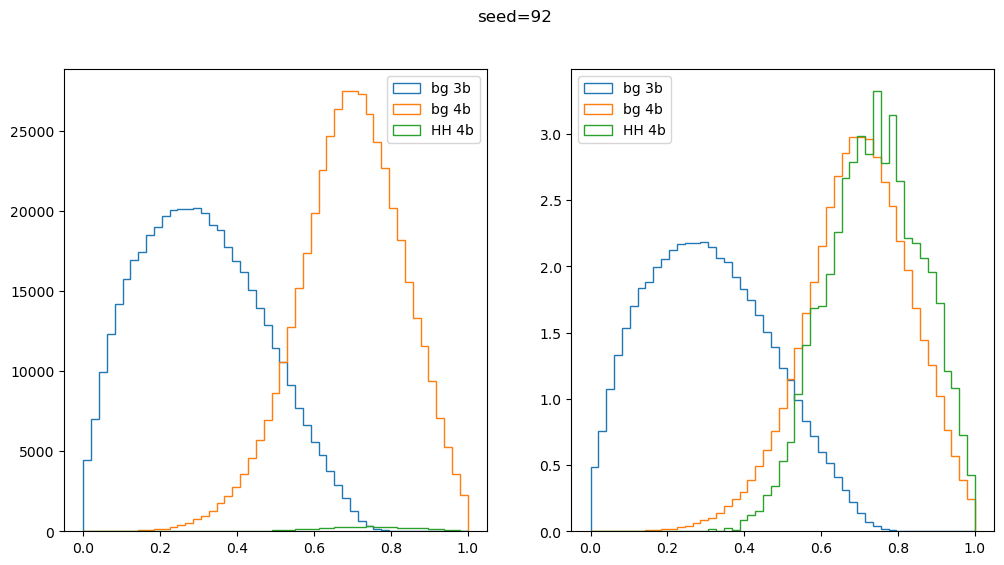

In [10]:
n_sample_ratio = 1.0

for seed in seeds:
    events = events_test_dict[seed]
    is_3b = events.is_3b
    is_bg4b = events.is_bg4b
    is_signal = events.is_signal
    is_4b = events.is_4b
    w = events.weights
    
    hash = TrainingInfo.find({"experiment_name": experiment_name, "seed": seed, "n_sample_ratio": n_sample_ratio})[0]
    tinfo = TrainingInfo.load(hash)
    fvt_model = FvTClassifier.load_from_checkpoint(f"./checkpoints/{hash}_best.ckpt")
    fvt_model.eval()
    device = torch.device("cuda:0")
    fvt_model = fvt_model.to(device)
    events_sr_train, events_sr_test = events.split(0.5, seed=seed)
    events_sr_train.set_model_scores(fvt_model)
    events_sr_test.set_model_scores(fvt_model)

    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
    fig.suptitle(f"seed={seed}")

    xgbreg = XGBRegressor(n_estimators=best_n_estimator, max_depth=best_max_depth, random_state=seed)
    xgbreg.fit(events_sr_train.att_q_repr, events_sr_train.is_4b, sample_weight=events_sr_train.weights)
    probs_4b_estimated = xgbreg.predict(events_sr_test.att_q_repr)
    is_in_regions_list = get_regions_via_probs_4b(events_sr_test, w_cuts, probs_4b_estimated)

    bins_range = np.linspace(0, 1, 50)
    ax[0].hist(probs_4b_estimated[is_3b], bins=bins_range, weights=w[is_3b], label="bg 3b", histtype="step")
    ax[0].hist(probs_4b_estimated[is_bg4b], bins=bins_range, weights=w[is_bg4b], label="bg 4b", histtype="step")
    ax[0].hist(probs_4b_estimated[is_signal], bins=bins_range, weights=w[is_signal], label="HH 4b", histtype="step")
    
    ax[1].hist(probs_4b_estimated[is_3b], bins=bins_range, weights=w[is_3b], label="bg 3b", histtype="step", density=True)
    ax[1].hist(probs_4b_estimated[is_bg4b], bins=bins_range, weights=w[is_bg4b], label="bg 4b", histtype="step", density=True)
    ax[1].hist(probs_4b_estimated[is_signal], bins=bins_range, weights=w[is_signal], label="HH 4b", histtype="step", density=True)
        
    ax[0].legend()
    ax[1].legend()
    
    plt.show()
    plt.close()

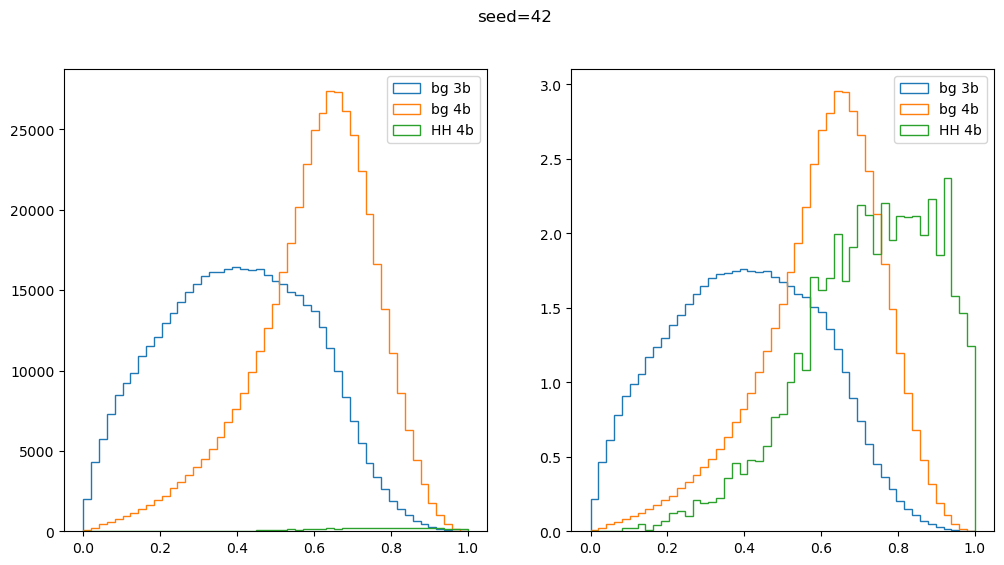

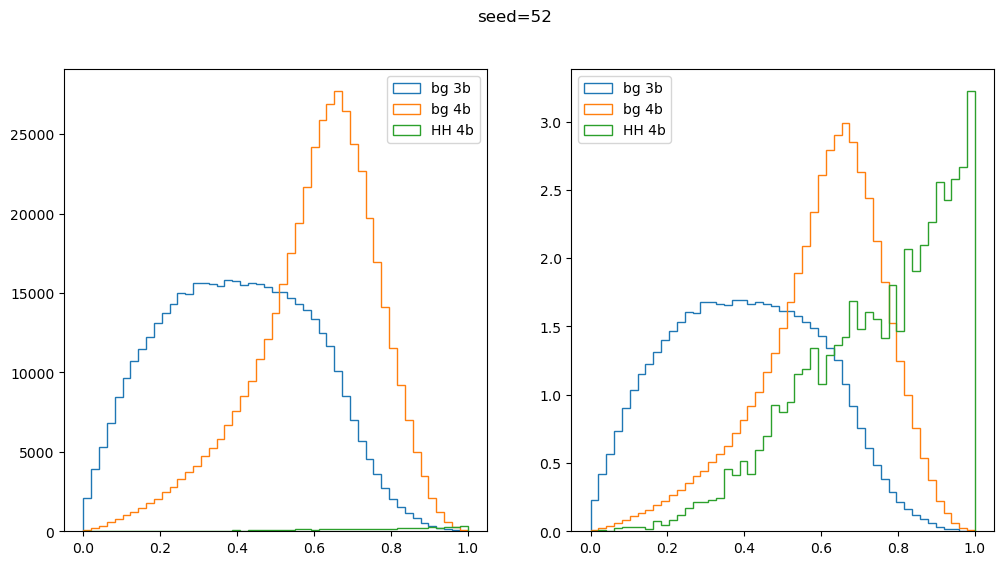

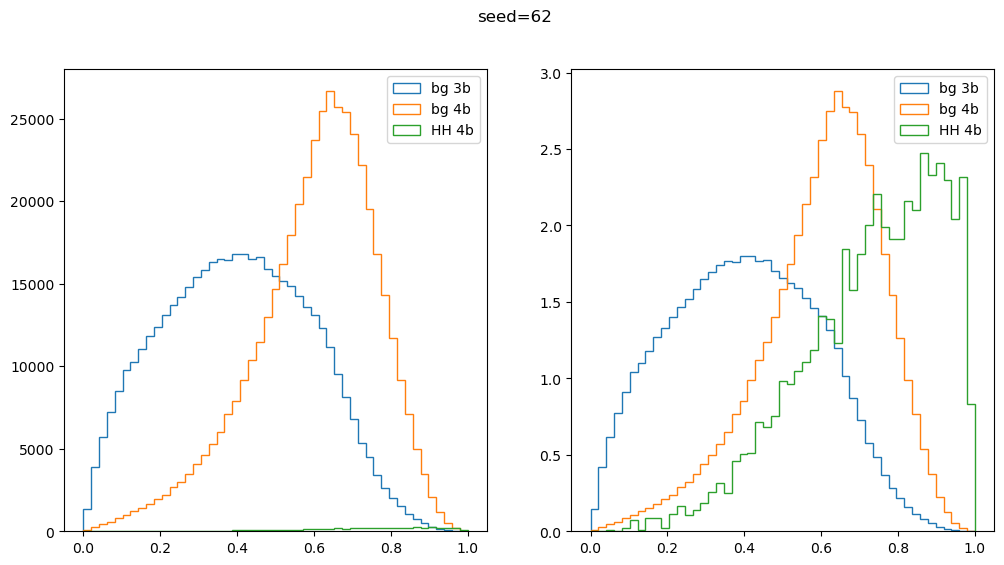

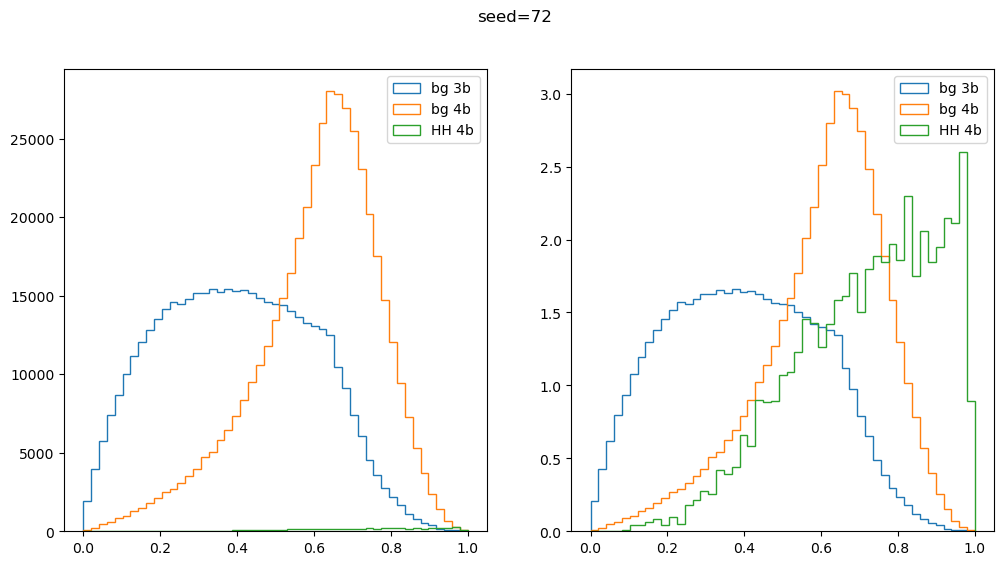

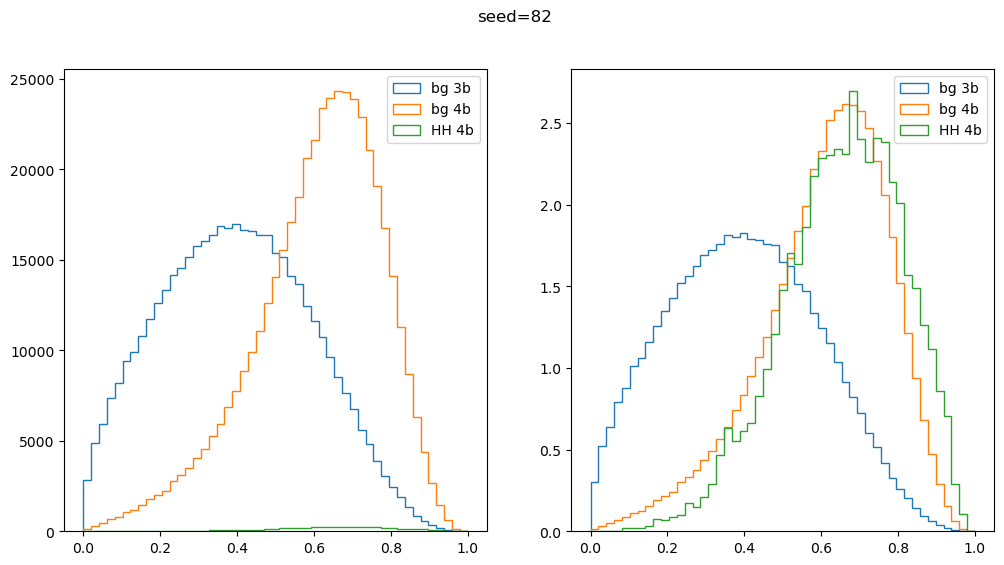

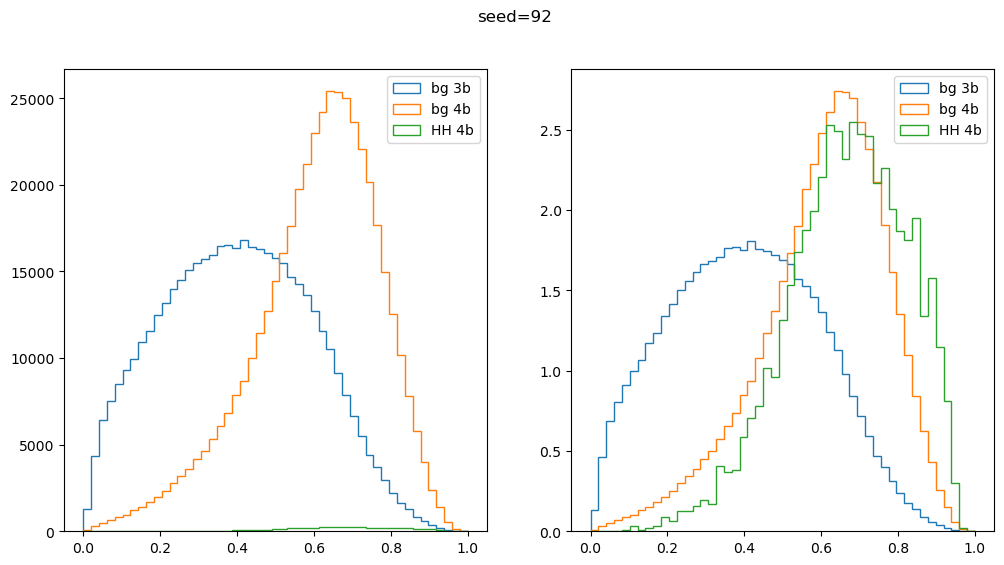

In [11]:
import xgboost as xgb
from sklearn.model_selection import train_test_split

n_sample_ratio = 1.0

for seed in seeds:
    events = events_test_dict[seed]
    is_3b = events.is_3b
    is_bg4b = events.is_bg4b
    is_signal = events.is_signal
    is_4b = events.is_4b
    w = events.weights

    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
    fig.suptitle(f"seed={seed}")

    att_q_repr = att_q_reprs_dict[seed][n_sample_ratio]

    X_train, X_val, y_train, y_val, w_train, w_val = train_test_split(
        att_q_repr, is_4b, w, test_size=0.5, random_state=seed)
    
    dtrain = xgb.DMatrix(X_train, label=y_train, weight=w_train)
    dval = xgb.DMatrix(X_val, label=y_val, weight=w_val)
    dall = xgb.DMatrix(att_q_repr, label=is_4b, weight=w)
    
    param = {
        "max_depth": best_max_depth,
        "objective": "binary:logistic",
        "eval_metric": "logloss",
    }
    num_round = best_n_estimator

    bst = xgb.train(param, dtrain, num_round, evals=[(dval, "eval")], early_stopping_rounds=100, verbose_eval=False)
    

    probs_4b_estimated = bst.predict(dall)
    is_in_regions_list = get_regions_via_probs_4b(events, w_cuts, probs_4b_estimated)
    
    w_signal = np.array([np.sum(w[is_signal & is_in_regions]) for is_in_regions in is_in_regions_list]) / np.sum(w[is_signal])
    w_all = np.array([np.sum(w[is_in_regions]) for is_in_regions in is_in_regions_list]) / np.sum(w)

    bins_range = np.linspace(0, 1, 50)
    ax[0].hist(probs_4b_estimated[is_3b], bins=bins_range, weights=w[is_3b], label="bg 3b", histtype="step")
    ax[0].hist(probs_4b_estimated[is_bg4b], bins=bins_range, weights=w[is_bg4b], label="bg 4b", histtype="step")
    ax[0].hist(probs_4b_estimated[is_signal], bins=bins_range, weights=w[is_signal], label="HH 4b", histtype="step")
    ax[0].legend()
    
    
    ax[1].hist(probs_4b_estimated[is_3b], bins=bins_range, weights=w[is_3b], label="bg 3b", histtype="step", 
               density=True)
    ax[1].hist(probs_4b_estimated[is_bg4b], bins=bins_range, weights=w[is_bg4b], label="bg 4b", histtype="step", 
               density=True)
    ax[1].hist(probs_4b_estimated[is_signal], bins=bins_range, weights=w[is_signal], label="HH 4b", histtype="step", 
               density=True)
    ax[1].legend()

    plt.show()
    plt.close()

/home/soheuny/miniconda3/envs/coffea_torch/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Elapsed time: 1.33 s
Elapsed time: 5.90 s


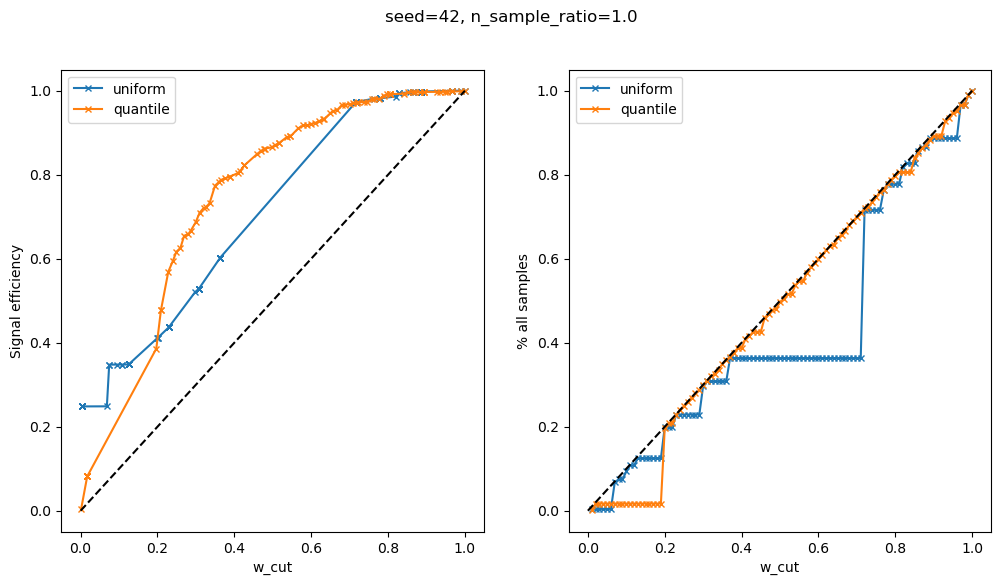

Elapsed time: 2.28 s
Elapsed time: 6.30 s


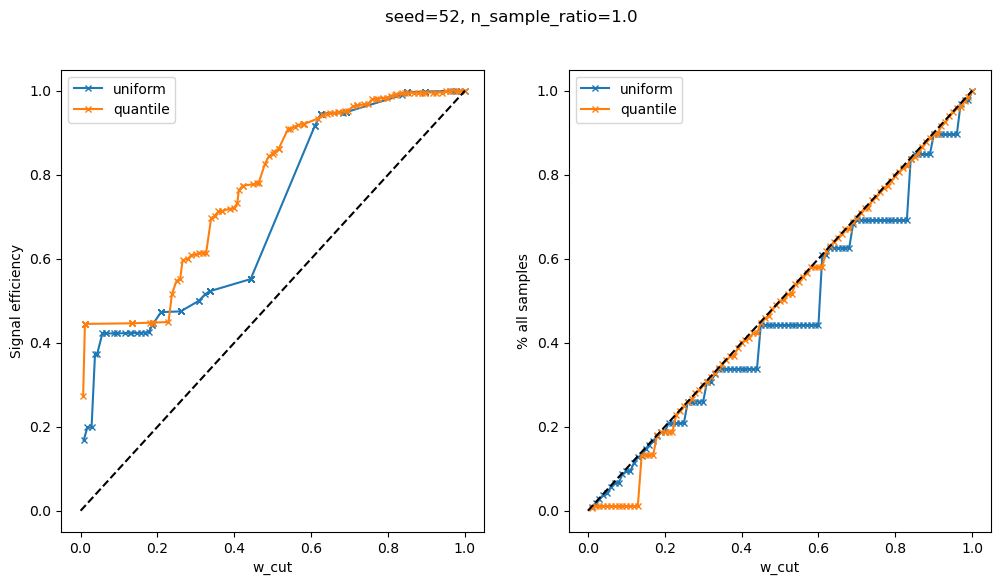

Elapsed time: 2.36 s
Elapsed time: 6.09 s


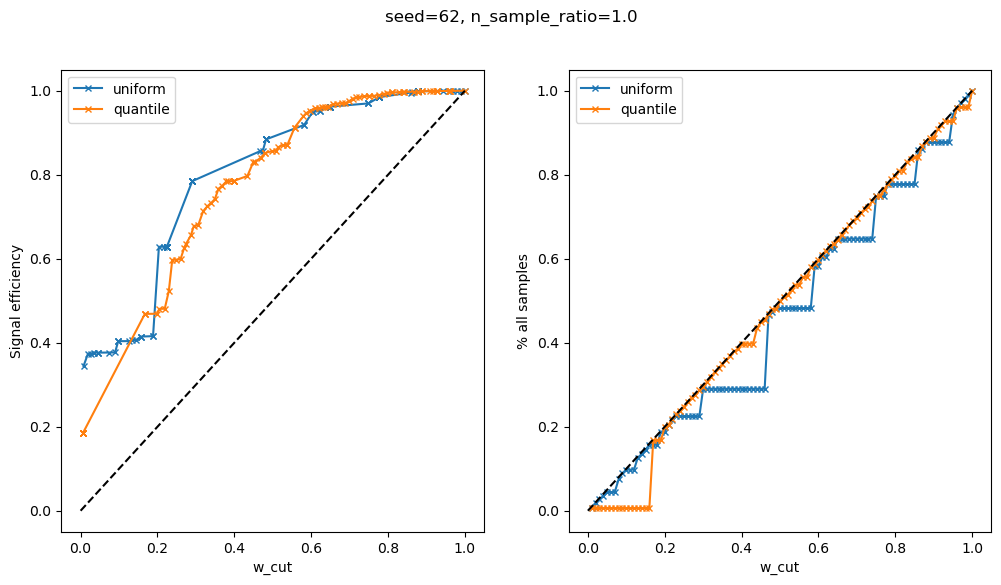

Elapsed time: 4.93 s
Elapsed time: 5.73 s


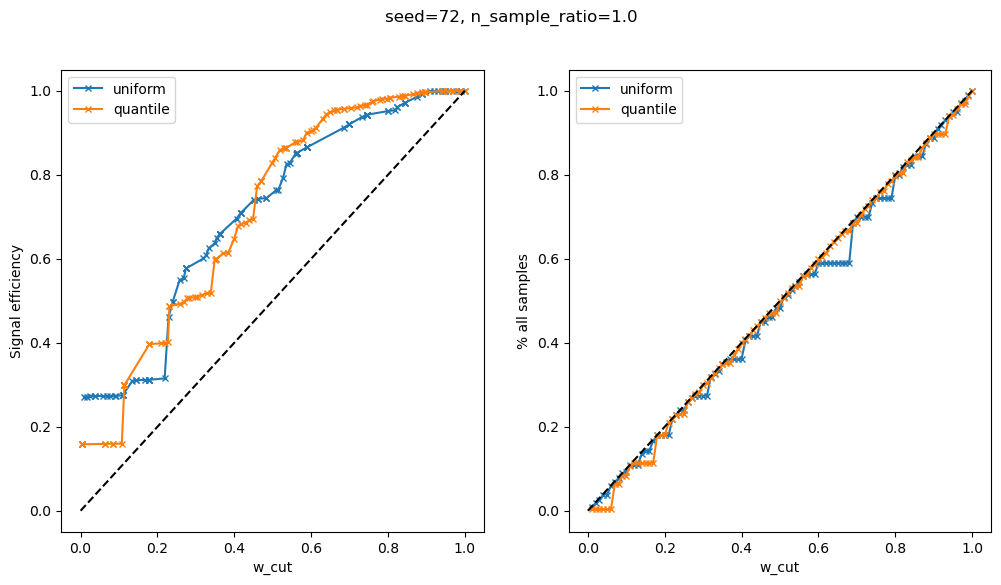

Elapsed time: 5.28 s
Elapsed time: 6.52 s


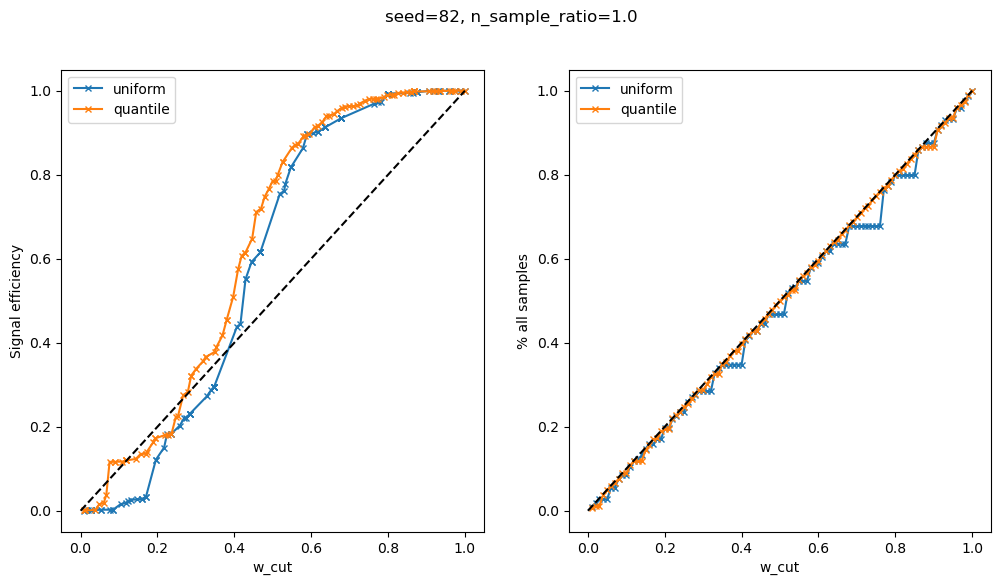

Elapsed time: 0.81 s
Elapsed time: 5.95 s


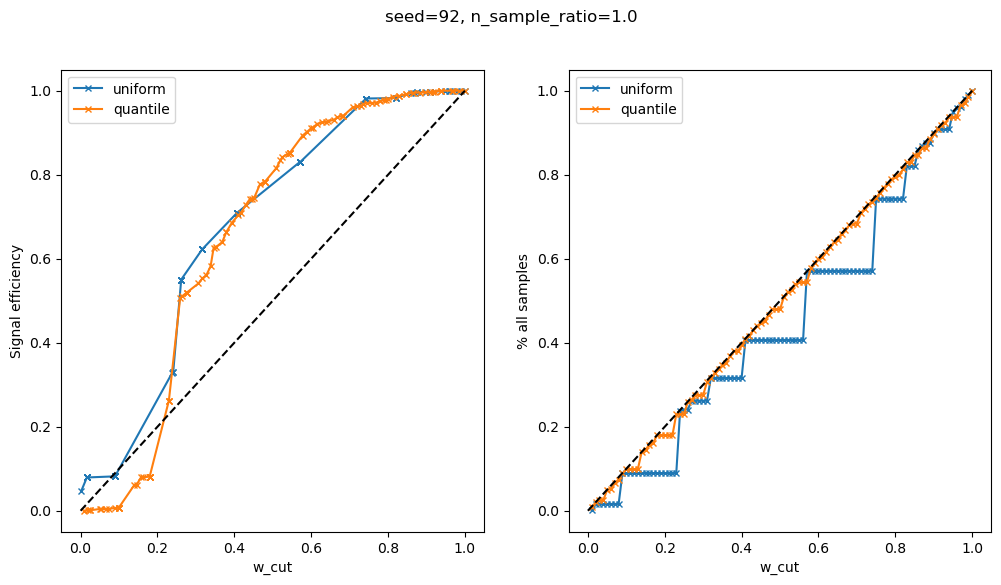

In [ ]:
import time
from signal_region import get_regions_via_histogram

n_sample_ratio = 1.0
using_features = [0, 1, 2, 3, 4, 5]
w_cuts = np.arange(0.01, 1.01, 0.01)

for seed in seeds:
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
    fig.suptitle(f"seed={seed}, n_sample_ratio={n_sample_ratio}")
    # for binning_method in ["uniform"]:
    for binning_method in ["uniform", "quantile"]:
        events = events_test_dict[seed]
        is_3b = events.is_3b
        is_bg4b = events.is_bg4b
        is_signal = events.is_signal
        w = events.weights

        nbins = 6 if binning_method == "uniform" else 3
        
        # for n_sample_ratio in n_sample_ratios:
        att_q_repr = att_q_reprs_dict[seed][n_sample_ratio]

        start_time = time.time()
        is_in_regions_list = get_regions_via_histogram(events, w_cuts, binning_method, nbins)
        print(f"Elapsed time: {time.time() - start_time:.2f} s")

        w_signal = np.array([np.sum(w[is_signal & is_in_regions]) for is_in_regions in is_in_regions_list]) / np.sum(w[is_signal])
        w_all = np.array([np.sum(w[is_in_regions]) for is_in_regions in is_in_regions_list]) / np.sum(w)

        ax[0].plot( 
            w_all,
            w_signal,
            label=binning_method,
            marker="x",
            markersize=5
        )
        ax[1].plot(
            w_cuts,
            w_all,
            label=binning_method,
            marker="x",
            markersize=5
        )

    ax[0].plot([0, 1], [0, 1], linestyle="--", color="black")
    ax[0].set_xlabel("w_cut")
    ax[0].set_ylabel("Signal efficiency")
    ax[0].legend()

    ax[1].plot([0, 1], [0, 1], linestyle="--", color="black")
    ax[1].set_xlabel("w_cut")
    ax[1].set_ylabel("% all samples")
    ax[1].legend()

    plt.show()
    plt.close()


quantile
nonzero bins 1850
% nonzero bins 0.4517


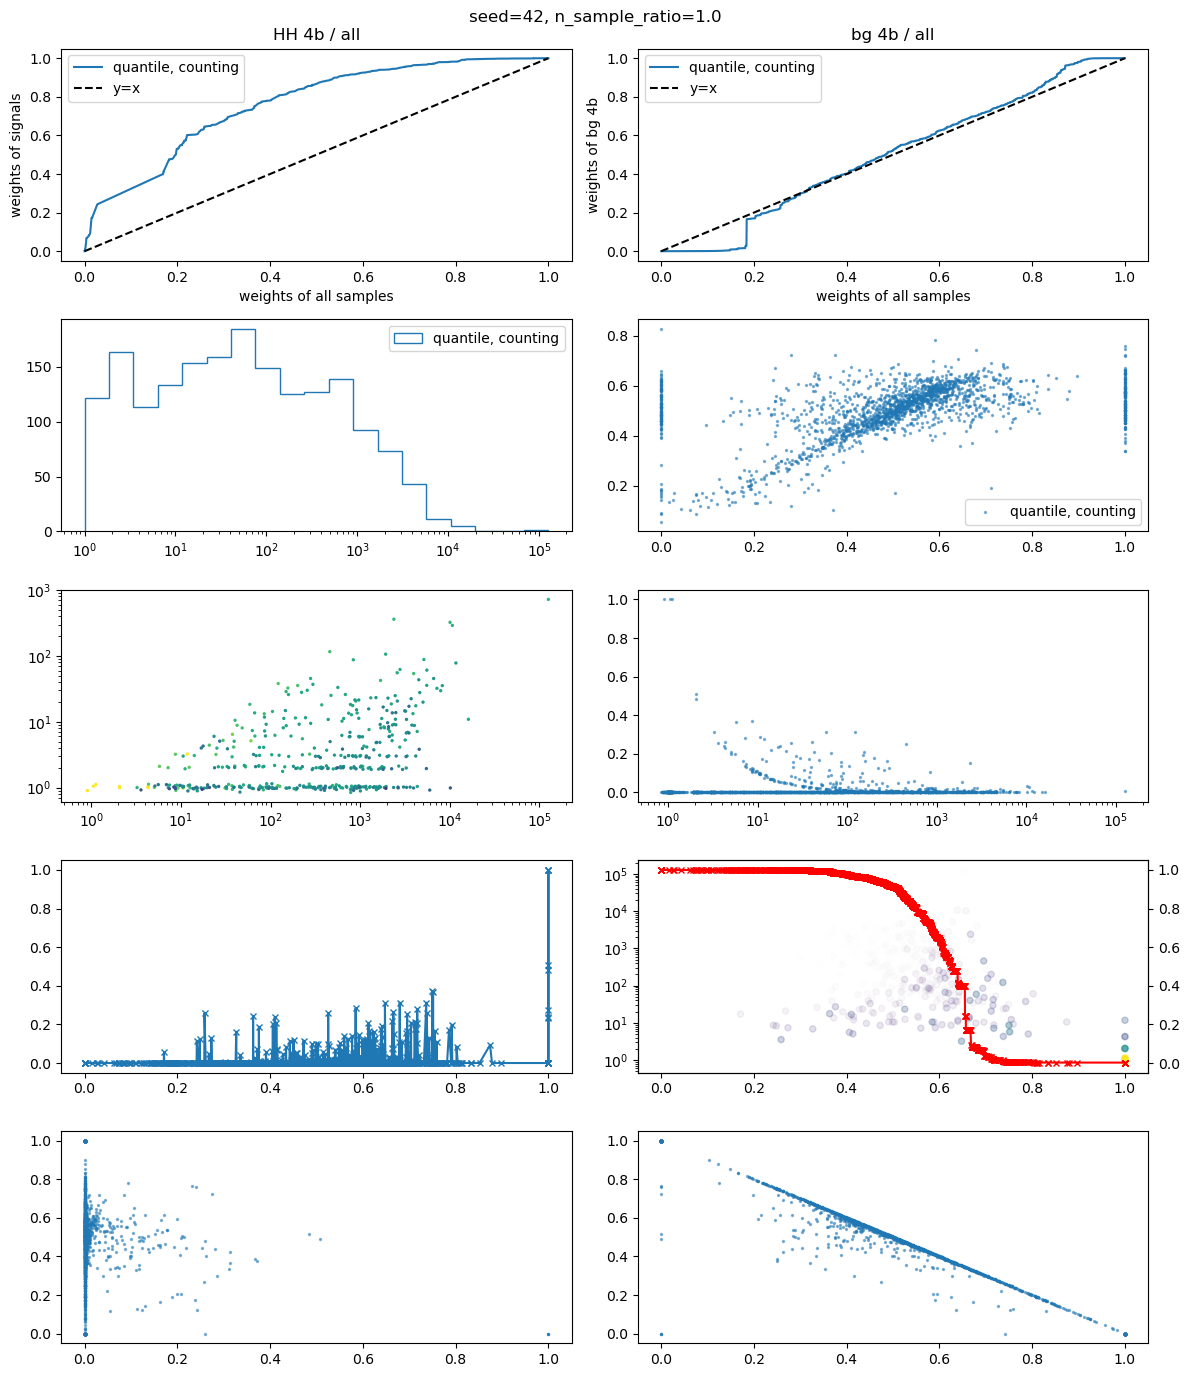

quantile
nonzero bins 1996
% nonzero bins 0.4873


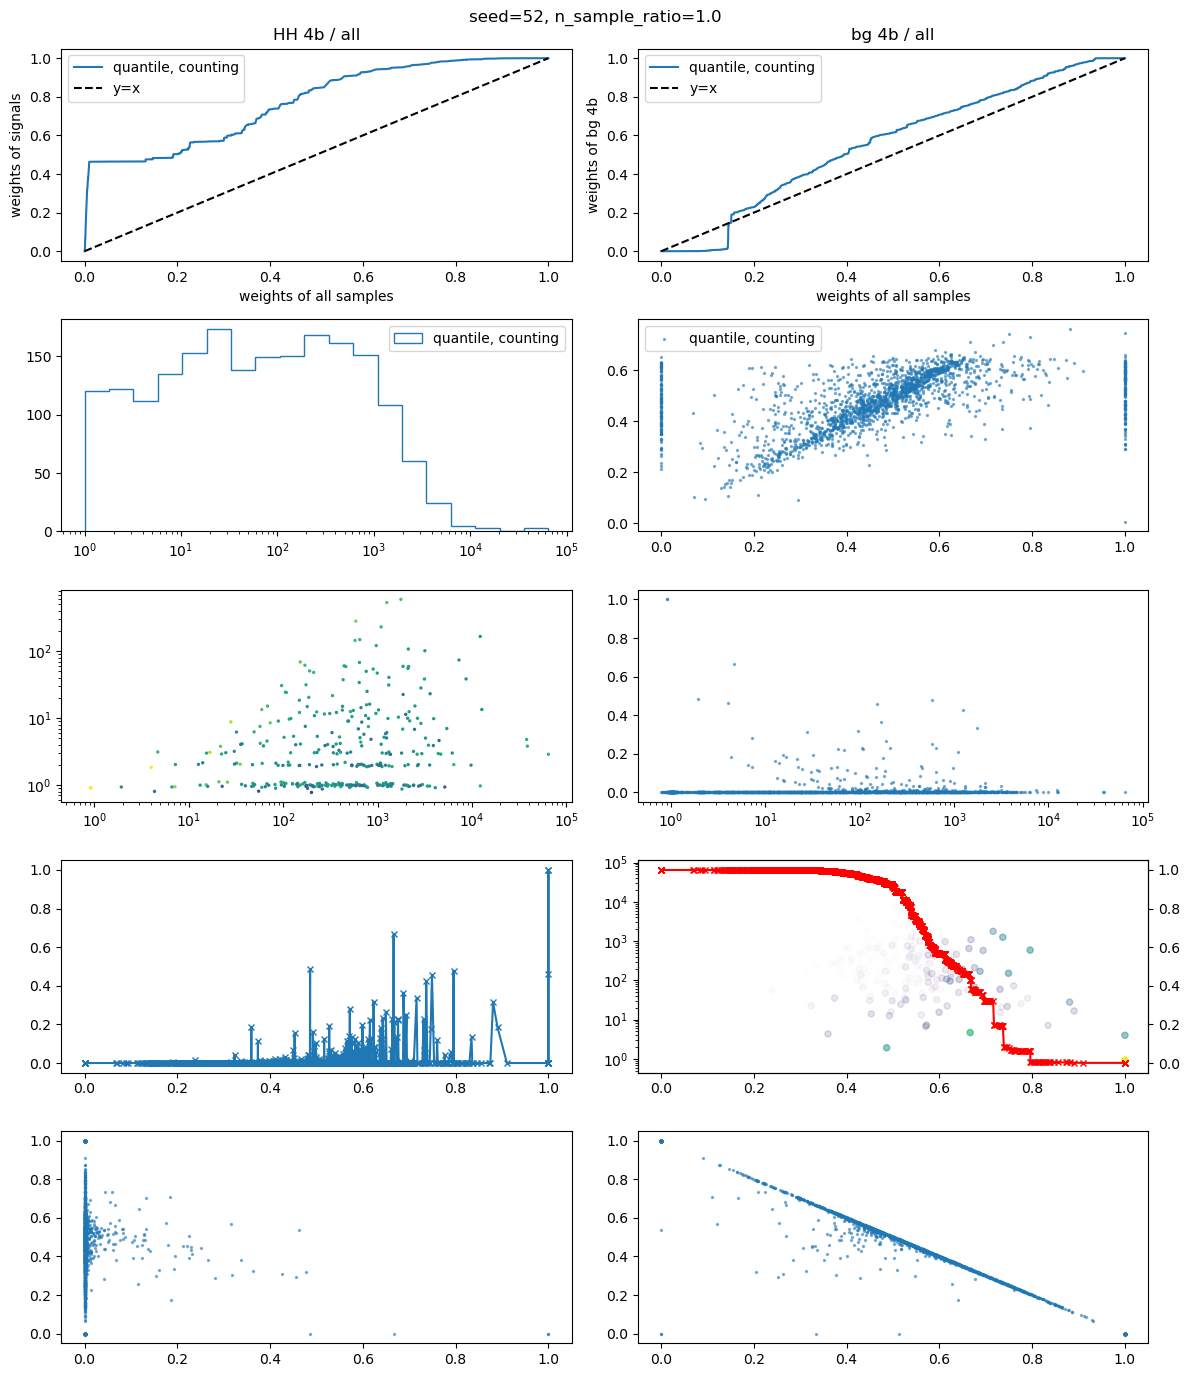

quantile
nonzero bins 2080
% nonzero bins 0.5078


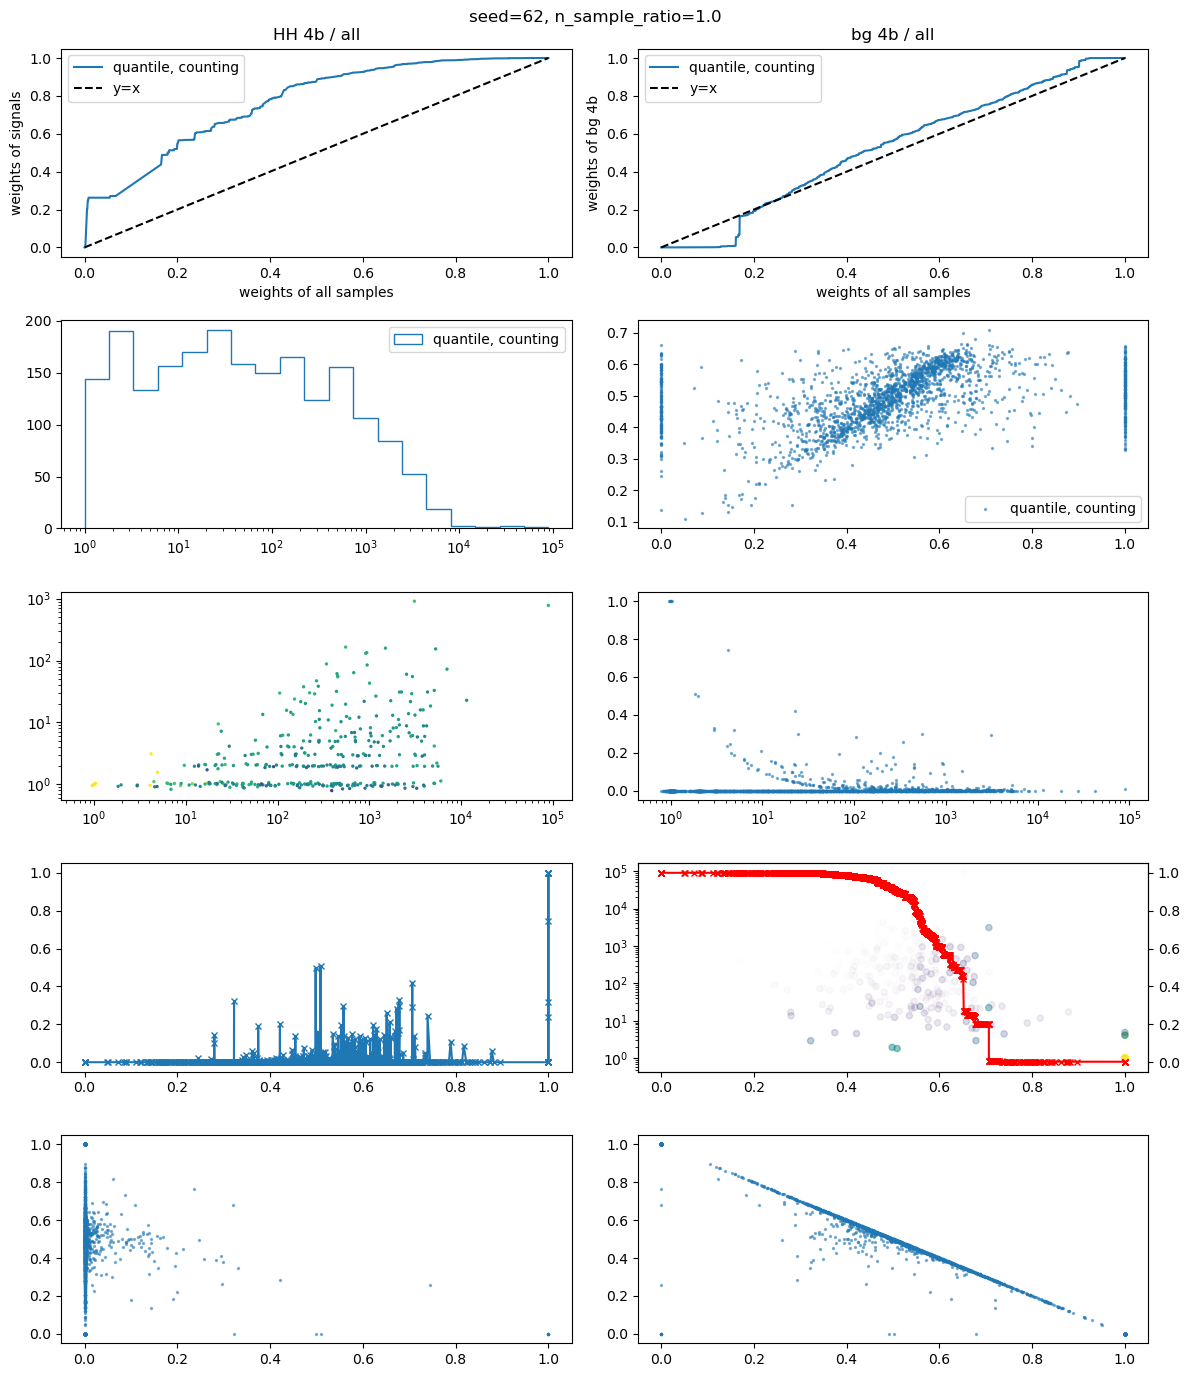

quantile
nonzero bins 1729
% nonzero bins 0.4221


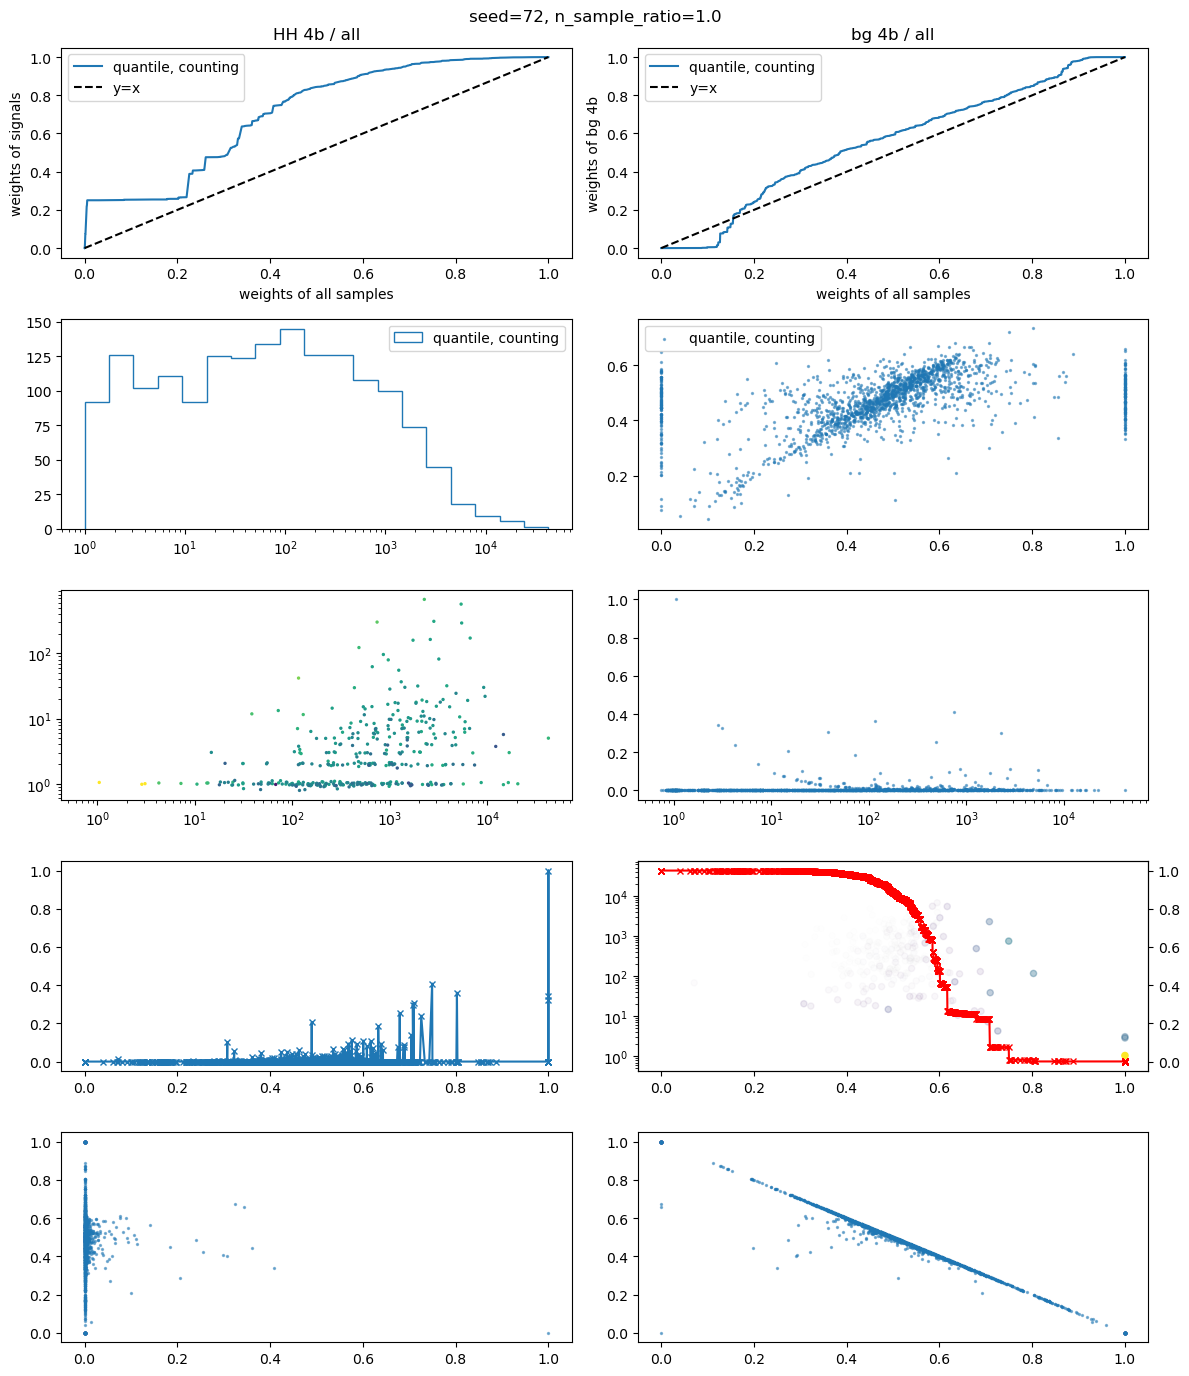

quantile
nonzero bins 2407
% nonzero bins 0.5876


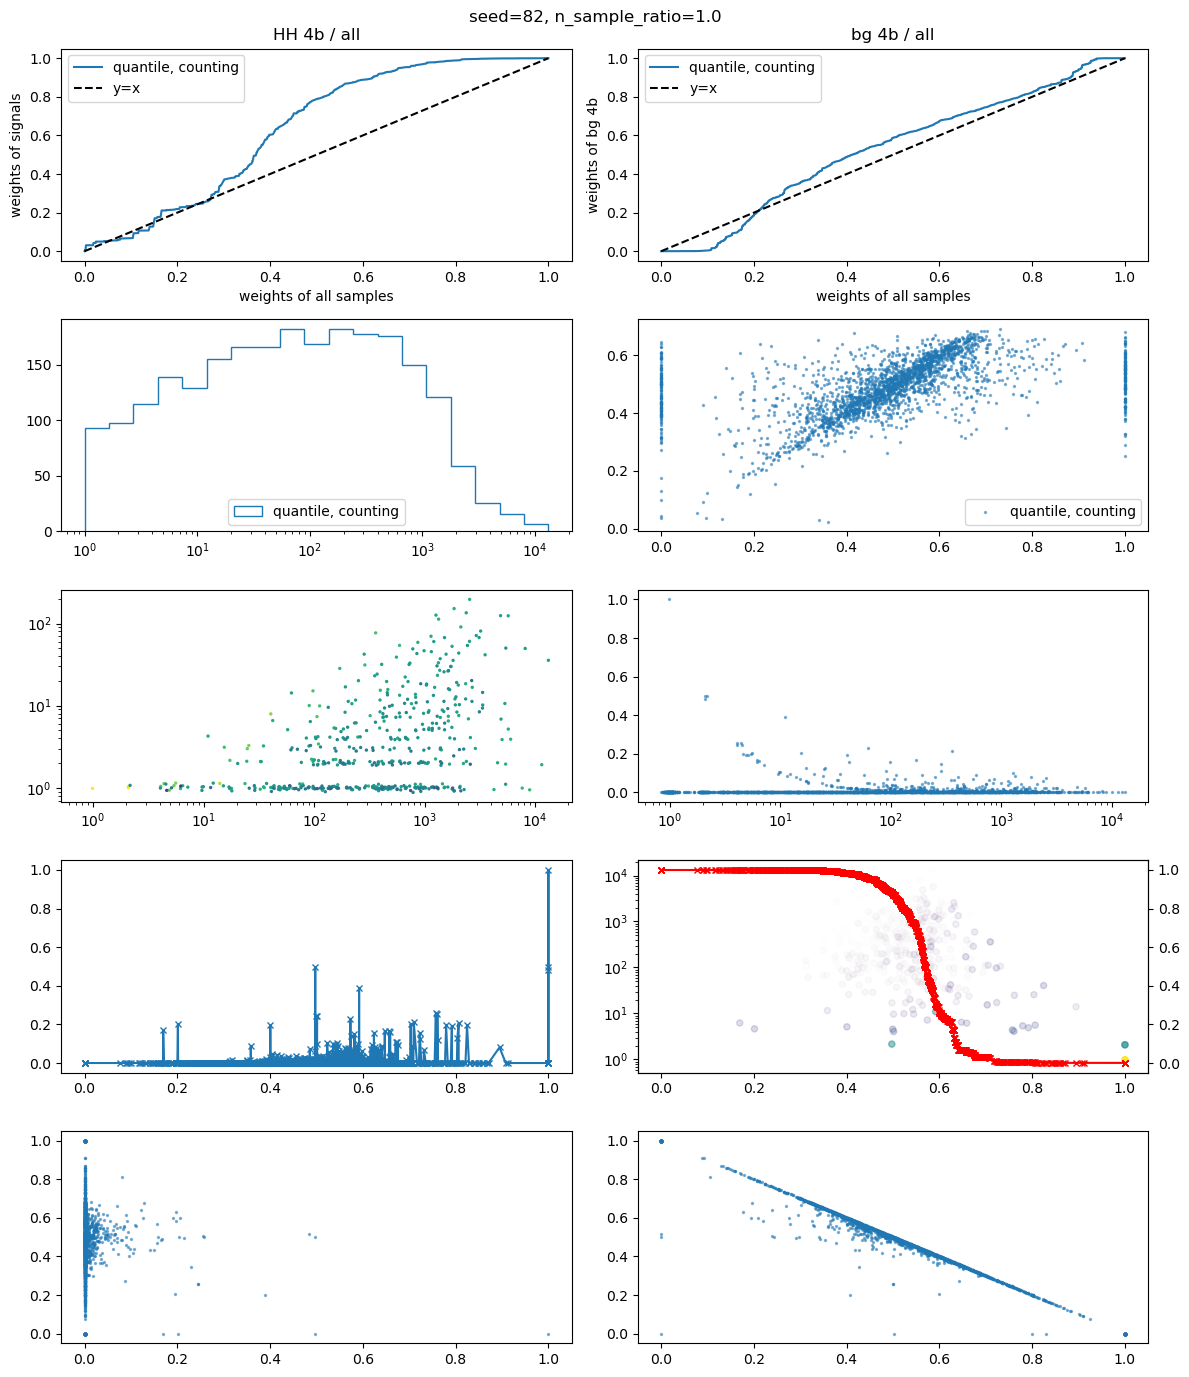

quantile
nonzero bins 1975
% nonzero bins 0.4822


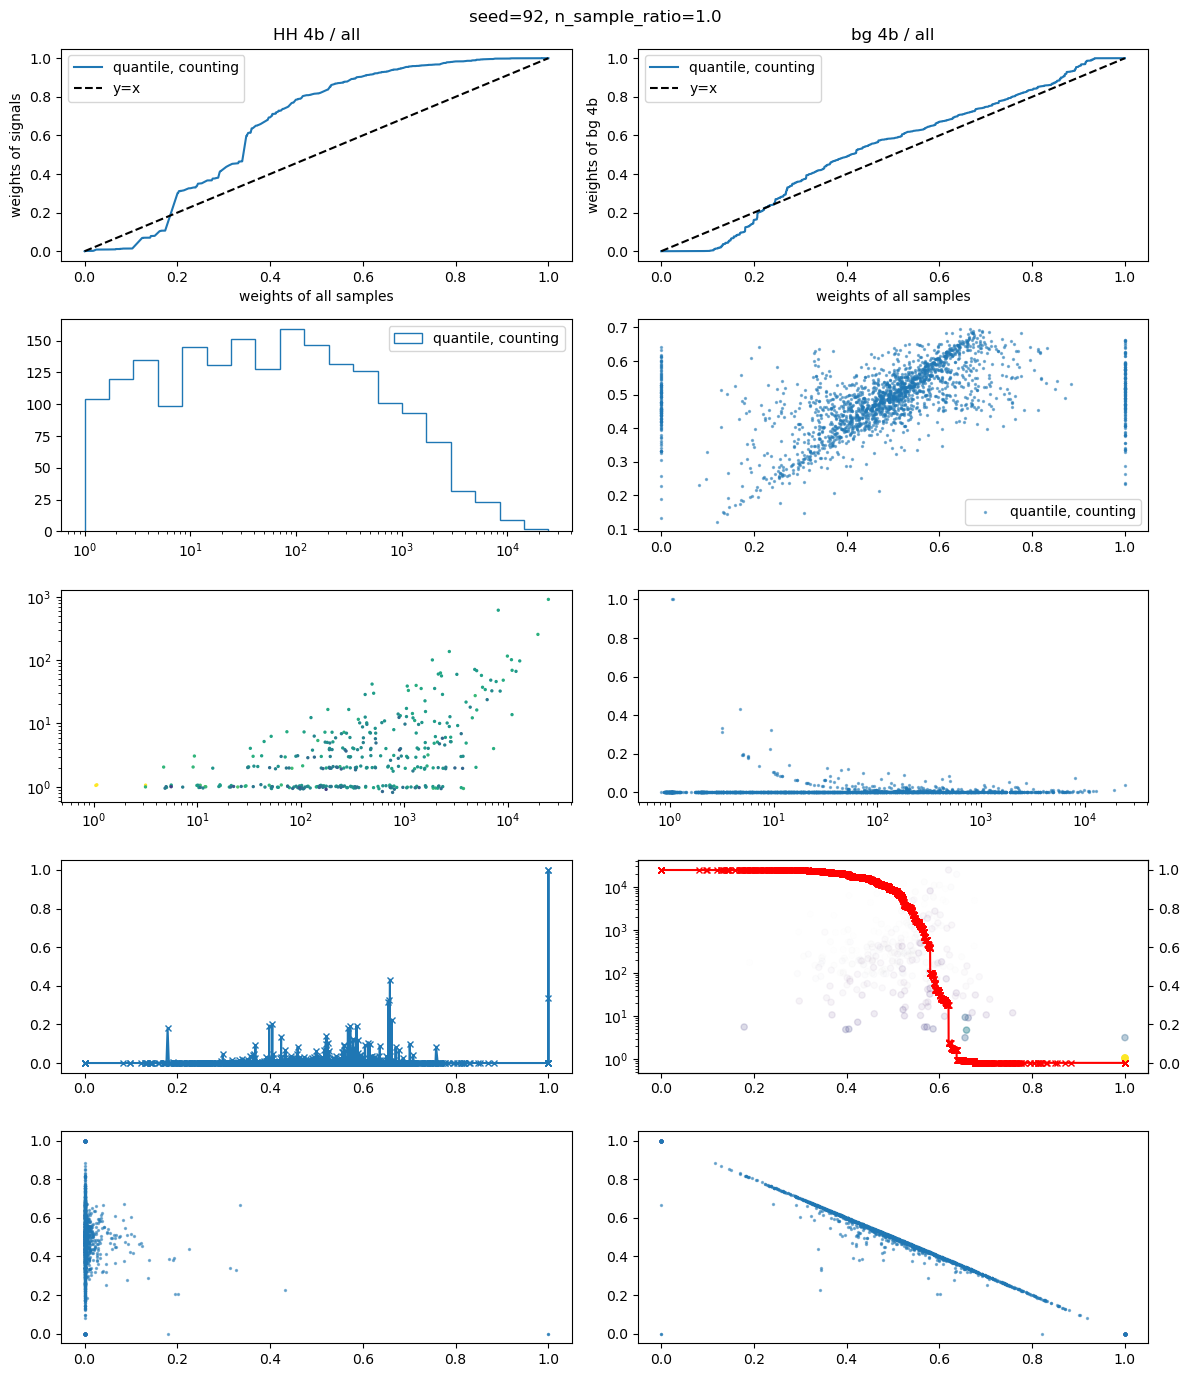

In [ ]:
n_sample_ratio = 1.0
using_features = [0, 1, 2, 3, 4, 5]
nbins = 5
p4b_method = "counting"

for seed in seeds:
    events = events_test_dict[seed]
    is_3b = events.is_3b
    is_bg4b = events.is_bg4b
    is_signal = events.is_signal
    is_4b = is_bg4b | is_signal
    att_q_repr = att_q_reprs_dict[seed][n_sample_ratio]

    fig, ax = plt.subplots(nrows=5, ncols=2, figsize=(12, 14))
    fig.suptitle(f"seed={seed}, n_sample_ratio={n_sample_ratio}")

    # for n_sample_ratio in n_sample_ratios:

    for binning_method in ["quantile"]:
        if binning_method == "uniform":
                bins_range = [np.linspace(np.min(att_q_repr[:, i]), np.max(att_q_repr[:, i]), nbins) 
                        for i in using_features]
        elif binning_method == "quantile":
            bins_range = [np.quantile(att_q_repr[:, i], np.linspace(0, 1, nbins)) for i in using_features]
        else:
            raise ValueError("Invalid binning method")
        
        hist_3b, _ = np.histogramdd(att_q_repr[is_3b][:, using_features], 
                                    bins=bins_range, weights=events.weights[is_3b])
        hist_bg4b, _ = np.histogramdd(att_q_repr[is_bg4b][:, using_features], 
                                    bins=bins_range, weights=events.weights[is_bg4b])
        hist_signal, _ = np.histogramdd(att_q_repr[is_signal][:, using_features], 
                                    bins=bins_range, weights=events.weights[is_signal])
        hist_fvt, _ = np.histogramdd(att_q_repr[:, using_features],
                                    bins=bins_range, weights=events.fvt_score * events.weights)
        hist_counts, _ = np.histogramdd(att_q_repr[:, using_features], bins=bins_range)
        hist_4b = hist_bg4b + hist_signal
        hist_all = hist_3b + hist_4b
        is_nonzero = hist_all > 0
        
        with np.errstate(divide="ignore", invalid="ignore"):
            ratio_4b = hist_4b / hist_all
            ratio_signal = hist_signal / hist_all

        print(binning_method)
        print("nonzero bins", np.sum(is_nonzero))
        print("% nonzero bins {:.4f}".format(np.sum(is_nonzero) / np.prod(hist_all.shape)))
        
        for p4b_method in ["counting"]:
            if p4b_method == "counting": 
                sorted_idx = np.argsort(ratio_4b[is_nonzero].flatten())[::-1]
            elif p4b_method == "fvt":
                sorted_idx = np.argsort((hist_fvt / hist_all)[is_nonzero].flatten())[::-1]
            else:
                raise ValueError("Invalid p4b_method")

            ax[0, 0].plot(
                np.cumsum(hist_all[is_nonzero][sorted_idx]) / np.sum(hist_all),
                np.cumsum(hist_signal[is_nonzero][sorted_idx]) / np.sum(hist_signal),
                label="{}, {}".format(binning_method, p4b_method)
            )

            ax[0, 1].plot(
                np.linspace(0, 1, np.sum(is_nonzero)),
                np.cumsum(hist_all[is_nonzero][sorted_idx]) / np.sum(hist_all),
                label="{}, {}".format(binning_method, p4b_method)
            )
            

            bins_range = np.geomspace(1, np.max(hist_all), 20)
            ax[1, 0].hist(hist_all[is_nonzero], label="{}, {}".format(binning_method, p4b_method), 
                          histtype="step", bins=bins_range)
            ax[1, 1].scatter(ratio_4b[is_nonzero], hist_fvt[is_nonzero] / hist_all[is_nonzero],
                            label="{}, {}".format(binning_method, p4b_method), s=2, alpha=0.5)
            
            
            ax[2, 0].scatter(hist_all[is_nonzero][sorted_idx], hist_signal[is_nonzero][sorted_idx],
                            label="{}, {}".format(binning_method, p4b_method), s=2, 
                            c=hist_4b[is_nonzero][sorted_idx] / hist_all[is_nonzero][sorted_idx])
            
            ax[2, 1].scatter(hist_all[is_nonzero], (hist_signal[is_nonzero] / hist_all[is_nonzero]),
                            label="{}, {}".format(binning_method, p4b_method), s=2, alpha=0.5)

            ax[3, 0].plot(hist_4b[is_nonzero][sorted_idx] / hist_all[is_nonzero][sorted_idx], 
                            hist_signal[is_nonzero][sorted_idx] / hist_all[is_nonzero][sorted_idx],
                            label="{}, {}".format(binning_method, p4b_method), 
                            marker="x", markersize=5)
            
            ax[3, 1].scatter(hist_4b[is_nonzero][sorted_idx] / hist_all[is_nonzero][sorted_idx], 
                            hist_all[is_nonzero][sorted_idx],
                            label="{}, {}".format(binning_method, p4b_method), 
                            c=hist_signal[is_nonzero][sorted_idx] / hist_all[is_nonzero][sorted_idx],
                            cmap="viridis", s=20, alpha=hist_signal[is_nonzero][sorted_idx] / hist_all[is_nonzero][sorted_idx])
            
            twinx = ax[3, 1].twinx()
            twinx.plot(hist_4b[is_nonzero][sorted_idx] / hist_all[is_nonzero][sorted_idx],
                       np.cumsum(hist_signal[is_nonzero][sorted_idx]) / np.sum(hist_signal),
                          color="red", label="cumulative signal efficiency", 
                          marker="x", markersize=5)
            
            ax[4, 0].scatter(hist_signal[is_nonzero] / hist_all[is_nonzero],
                            hist_bg4b[is_nonzero] / hist_all[is_nonzero],
                            label="{}, {}".format(binning_method, p4b_method), s=2, alpha=0.5)
            
            ax[4, 1].scatter(hist_3b[is_nonzero] / hist_all[is_nonzero],
                          hist_bg4b[is_nonzero] / hist_all[is_nonzero],
                            label="{}, {}".format(binning_method, p4b_method), s=2, alpha=0.5)

            

    ax[0, 0].set_title("HH 4b / all")
    ax[0, 0].set_xlabel("weights of all samples")
    ax[0, 0].set_ylabel("weights of signals")
    ax[0, 0].plot([0, 1], [0, 1], "--", color="black", label="y=x")

    ax[0, 1].set_title("bg 4b / all")
    ax[0, 1].set_xlabel("weights of all samples")
    ax[0, 1].set_ylabel("weights of bg 4b")
    ax[0, 1].plot([0, 1], [0, 1], "--", color="black", label="y=x")
    

    ax[1, 0].set_xscale("log")
    ax[2, 0].set_xscale("log")
    ax[2, 0].set_yscale("log")
    ax[2, 1].set_xscale("log")
    ax[3, 1].set_yscale("log")

    # ax[4, 0].plot([0, 1], [0, 1], "--", color="black", label="y=x")

    for ax_cnt in range(2):
        ax[ax_cnt, 0].legend()
        ax[ax_cnt, 1].legend()

    plt.tight_layout()
    plt.show()
    plt.close()

In [ ]:
from ancillary_features import jets_to_dijets
from signal_region import get_regions_via_probs_4b
from xgboost import XGBRegressor


seed = 42
n_sample_ratio = 1.0
using_features = [0, 1, 2, 3, 4, 5]
w_cuts = np.arange(0.01, 1.01, 0.01)
# nbins = 4
# binning_method = "quantile"

events = events_test_dict[seed]
att_q_repr = att_q_reprs_dict[seed][n_sample_ratio]


xgbreg = XGBRegressor(n_estimators=best_n_estimator, max_depth=best_max_depth, random_state=seed)
xgbreg.fit(att_q_repr, events.is_4b, sample_weight=events.weights)
probs_4b_est = xgbreg.predict(att_q_repr)
is_in_regions_list = get_regions_via_probs_4b(events, w_cuts, probs_4b_est)

jet0 = events.X_torch[:, [4*i for i in range(4)]]
jet1 = events.X_torch[:, [4*i + 1 for i in range(4)]]
jet2 = events.X_torch[:, [4*i + 2 for i in range(4)]]
jet3 = events.X_torch[:, [4*i + 3 for i in range(4)]]

dijet01, dijet23, dijet02, dijet13, dijet03, dijet12 = jets_to_dijets(jet0, jet1, jet2, jet3, dim=2)
M01, M23, M02, M13, M03, M12 = dijet01[:, 3], dijet23[:, 3], dijet02[:, 3], dijet13[:, 3], dijet03[:, 3], dijet12[:, 3]
M01, M23, M02, M13, M03, M12 = M01.cpu().numpy(), M23.cpu().numpy(), M02.cpu().numpy(), M13.cpu().numpy(), M03.cpu().numpy(), M12.cpu().numpy()

m_diff = np.stack(
    [M01 - M23, M02 - M13, M03 - M12],
    axis=1
)
m_diff_argmin = np.argmin(np.abs(m_diff), axis=1)

m_0 = np.where(m_diff_argmin == 0, M01, np.where(m_diff_argmin == 1, M02, M03))
m_1 = np.where(m_diff_argmin == 0, M23, np.where(m_diff_argmin == 1, M13, M12))

In [ ]:
import plotly.express as px
import plotly.graph_objects as go

plot_w_cuts = np.arange(0.05, 1.0, 0.05)

fig_m0m1 = go.Figure()

# 2d histogram of m_0[is_in_regions] vs m_1[is_in_regions] for each w_cut
# use plotly express to plot the 2d histogram
# make plot_w_cuts a slider

for w_cut in plot_w_cuts:
    is_in_regions = is_in_regions_list[int(w_cut * 100)]


    x_bins = np.linspace(0, 200, 50)
    y_bins = np.linspace(0, 200, 50)

    hist_sr, _, _ = np.histogram2d(m_0[is_in_regions], m_1[is_in_regions], bins=(x_bins, y_bins),
                                    weights=events.weights[is_in_regions])
    hist_sr = hist_sr.T
    hist_sr /= np.sum(hist_sr)

    fig_m0m1.add_trace(
        go.Heatmap(
            x=x_bins,
            y=y_bins,
            z=hist_sr,
            zmin=0,
            zmax=0.005,
            colorscale="Viridis",
            name=f"w_cut={w_cut:.1f}",
            visible=False,
        )
    )

fig_m0m1.data[0].visible = True

steps = []
for i in range(len(fig_m0m1.data)):
    step = dict(
        method="update",
        args=[{"visible": [False] * len(fig_m0m1.data)}],
        label=f"{plot_w_cuts[i]:.2f}",
    )
    step["args"][0]["visible"][i] = True
    steps.append(step)

sliders = [dict(
    active=0,
    currentvalue={"prefix": "w_cut: "},
    pad={"t": 50},
    steps=steps
)]


fig_m0m1.update_layout(
    sliders=sliders,
    title="M_0 vs M_1 in signal region",
    xaxis_title="M_0",
    yaxis_title="M_1",
    autosize=False,
    width=600,
    height=600,
    yaxis=dict(scaleanchor="x", scaleratio=1),
)


fig_m0m1.show()

In [ ]:
# fig = go.Figure()
# plot_w_cuts = np.arange(0.2, 1.0, 0.2)

# for w_cut in plot_w_cuts:
#     is_in_regions = is_in_regions_list[int(w_cut * 100)]

#     fig.add_trace(
#         go.Histogram(
#             x=events.fvt_score[is_in_regions],
#             xbins=dict(size=1/30),
#             histnorm="",
#             name=f"SR",
#             visible=False,
#         )
#     )

#     fig.add_trace(
#         go.Histogram(
#             x=events.fvt_score[~is_in_regions],
#             xbins=dict(size=1/30),
#             histnorm="",
#             name="not SR",
#             visible=False,
#         )
#     )

# fig.data[0].visible = True
# fig.data[1].visible = True

# steps = []
# for i in range(0, len(fig.data), 2):
#     step = dict(
#         method="update",
#         args=[{"visible": [False] * len(fig.data)}],
#         label=f"{plot_w_cuts[i // 2]:.2f}",
#     )
#     step["args"][0]["visible"][i] = True
#     step["args"][0]["visible"][i + 1] = True
#     steps.append(step)

# sliders = [dict(
#     active=0,
#     currentvalue={"prefix": "w_cut: "},
#     pad={"t": 50},
#     steps=steps
# )]

# fig.update_layout(
#     sliders=sliders,
#     title="FvT score in signal region",
#     xaxis_title="FvT score",
#     yaxis_title="Density",
# )

# fig.show()

In [ ]:
# instead of histogram, use kernel based classifier
# use att_q_repr as input
# use events.is_4b as target

seed = 42
n_sample_ratio = 1.0

events = events_test_dict[seed]
att_q_repr = att_q_reprs_dict[seed][n_sample_ratio]